In [1]:
import pandas as pd
import numpy as np
import tqdm
import os
import gc
import copy

import cv2
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# Extract data and Divide into train/test

Here, we will extract all the information regarding train and test data

In [2]:
file_path = "C:\\UMD\\Sem 2\\MSML605 Computing Systems\\Homeworks\\Project\\CUB_200_2011"

images = pd.read_csv(f"{file_path}\\images.txt", 
                     sep=' ', 
                     names=['image_id', 'image_name'])
train_test = pd.read_csv(f"{file_path}\\train_test_split.txt", 
                     sep=' ', 
                     names=['image_id', 'is_training_image'])
classes = pd.read_csv(f"{file_path}\\classes.txt", 
                     sep=' ', 
                     names=['class_id', 'class_name'])
image_class_labels = pd.read_csv(f"{file_path}\\image_class_labels.txt", 
                     sep=' ', 
                     names=['image_id', 'class_id'])

bounding_boxes = pd.read_csv(f'{file_path}\\bounding_boxes.txt',
                             sep=' ',
                             names=['image_id', 'x', 'y', 'width', 'height'])
bounding_boxes = bounding_boxes.astype(int)
#Merging the information given
image_data = images.merge(train_test, on='image_id', how='inner')

labels_data = classes.merge(image_class_labels, on='class_id', how='inner')

image_data = image_data.merge(labels_data, on='image_id', how='inner')

image_data = image_data.merge(bounding_boxes, on='image_id', how='inner')
image_data

,image_id,image_name,is_training_image,class_id,class_name,x,y,width,height
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,0,1,001.Black_footed_Albatross,60,27,325,304
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,139,30,153,264
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,0,1,001.Black_footed_Albatross,14,112,388,186
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,112,90,255,242
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,1,001.Black_footed_Albatross,70,50,134,303
...,...,...,...,...,...,...,...,...,...
11783,11784,200.Common_Yellowthroat/Common_Yellowthroat_00...,1,200,200.Common_Yellowthroat,89,95,354,250
11784,11785,200.Common_Yellowthroat/Common_Yellowthroat_00...,0,200,200.Common_Yellowthroat,157,62,184,219
11785,11786,200.Common_Yellowthroat/Common_Yellowthroat_00...,0,200,200.Common_Yellowthroat,190,102,198,202
11786,11787,200.Common_Yellowthroat/Common_Yellowthroat_00...,1,200,200.Common_Yellowthroat,3,20,408,307


Now, we divide into train and test data using the information given

In [3]:
# Set the first 24 training values in each group to 0 
grouped = image_data[image_data['is_training_image'] == 1].groupby('class_name')
validation_indices = []

for name, group in grouped: 
    validation_indices.extend(group.index[24:])

# Set the first 24 values in each group to 0
image_data['is_validation_image'] = 0
image_data.loc[validation_indices, 'is_validation_image'] = 1
image_data['is_validation_image'].value_counts()

is_validation_image
0    10594
1     1194
Name: count, dtype: int64

In [4]:
#Split the data into training and test
train_indices = (image_data['is_training_image'] == 1) & (image_data['is_validation_image'] == 0)
training_data = image_data[train_indices].reset_index()
validation_data = image_data[image_data['is_validation_image'] == 1].reset_index()
test_data = image_data[image_data['is_training_image'] == 0].reset_index()

#Setting three sets of images: training, validation, and test
X_temp_train = []
X_temp_validation = []
X_temp_test = []
temp = [X_temp_train, X_temp_validation, X_temp_test]

for p, dataframe in enumerate([training_data, validation_data, test_data]):
    #Get the paths for the images
    paths = 'CUB_200_2011/images/' + np.array(dataframe['image_name'])
    
    #Get the image arrays
    for i, img in tqdm.tqdm(enumerate(paths), total=dataframe.shape[0]):
        image = cv2.imread(img)
        x, y, width, height = dataframe.loc[i, ['x', 'y', 'width', 'height']]
        temp[p].append(image[y:y+height, x:x+width, :])
    
len(X_temp_train), len(X_temp_validation), len(X_temp_test)

100%|██████████| 5794/5794 [00:49<00:00, 116.47it/s]


(4800, 1194, 5794)

# Data Preprocessing

Padding all to square and then reshaping all to 224x224

In [5]:
def convert_to_PIL(image):
    return Image.fromarray(image)

# Define the transformation pipeline
transform = transforms.Compose([
    convert_to_PIL,
    # transforms.Resize(256),  # Resize the shorter side to 256, preserving aspect ratio
    # transforms.CenterCrop(224),  # Center crop to 224x224
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


final_image_size = (224, 224)


In [6]:
X_train, X_validation, X_test = [], [], []
for i, img in tqdm.tqdm(enumerate(X_temp_train), total=len(X_temp_train)):
    X_train.append(transform(img))

for i, img in tqdm.tqdm(enumerate(X_temp_validation), total=len(X_temp_validation)):
    X_validation.append(transform(img))

for i, img in tqdm.tqdm(enumerate(X_temp_test), total=len(X_temp_test)):
    X_test.append(transform(img))

100%|██████████| 5794/5794 [00:29<00:00, 197.08it/s]


In [7]:
y_train = np.array(image_data[train_indices]['class_id']) - 1

In [8]:
# train_transform = transforms.Compose([
#     convert_to_PIL,
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(10),
#     transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.RandomErasing(inplace=True),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# for i, img in tqdm.tqdm(enumerate(X_temp_train), total=len(X_temp_train)):
#     X_train.append(train_transform(img))

# y_train = np.array(image_data[train_indices]['class_id']) - 1
# y_train = np.concatenate([y_train, y_train])

In [9]:
# Convert the list of tensors to a 4D tensor (N, H, W, C)
X_train = torch.stack(X_train)   
print("Train done")

X_validation = torch.stack(X_validation) 
print("Validation done")

X_test = torch.stack(X_test)
print("Test done")   

print(X_train.shape, X_validation.shape, X_test.shape)

Train done
Validation done
Test done
torch.Size([4800, 3, 224, 224]) torch.Size([1194, 3, 224, 224]) torch.Size([5794, 3, 224, 224])


Setting labels

In [10]:
# Set the labels for training, validation and test
# y_validation = np.array(image_data[image_data['is_validation_image'] == 1]['class_id']) - 1
y_validation = np.array(image_data[image_data['is_validation_image'] == 1]['class_id']) - 1
y_test = np.array(image_data[image_data['is_training_image'] == 0]['class_id']) - 1

# dtype=torch.float, torch.long
y_train = torch.Tensor(y_train)
y_validation = torch.Tensor(y_validation).long()
y_test = torch.Tensor(y_test).long()
len(y_train), len(y_validation), len(y_test)

(4800, 1194, 5794)

Creating DataLoader

In [11]:
TrainDataset = data.TensorDataset(X_train, y_train)
ValidationDataset = data.TensorDataset(X_validation, y_validation)
TestDataset = data.TensorDataset(X_test, y_test)

batch_size = 2
TrainLoader = data.DataLoader(dataset=TrainDataset, batch_size=batch_size,
                               shuffle=True, num_workers=4, pin_memory=True)

ValidationLoader = data.DataLoader(dataset=ValidationDataset, batch_size=batch_size,
                               shuffle=True, num_workers=4, pin_memory=True)

TestLoader = data.DataLoader(dataset=TestDataset, batch_size=batch_size,
                               shuffle=True, num_workers=4, pin_memory=True)

len(TrainDataset), len(ValidationDataset), len(TestDataset)

(4800, 1194, 5794)

In [12]:
gc.collect()
torch.cuda.empty_cache()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


GroundTruth:  117.0 169.0


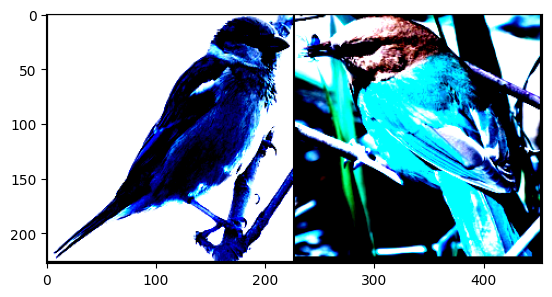

In [13]:
dataiter = iter(TrainLoader)
images, labels = next(dataiter)

# print images
plt.imshow(torchvision.utils.make_grid(images, nrow=10).permute(1, 2, 0))
print('GroundTruth: ', ' '.join(f'{labels[j]}' for j in range(2)))

Calculating accuracy function

In [22]:
def calculate_accuracy(model, loader, data_type='training'):
    model.eval() # Set model to evaluation mode

    correct = total = 0
    with torch.no_grad():
        for input_data in tqdm.tqdm(loader, total=len(loader)):
            # Move images to device (GPU if available)
            images, labels = input_data[0].to(device), input_data[1].to(device)
            
            #Predict values and convert to non-onehot vector
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            #For training, there will be onehot vector, so convert from onehot
            if data_type == 'training': 
                _, labels = torch.max(labels.data, 1)
            
            #Compare with ground truth
            correct += (predicted == labels).sum().item()

        print(f'Accuracy of the network on the {len(loader)} {data_type} images: {100 * correct / total}')
    return 100 * correct/total
    


# Model

In [15]:
# class Model(nn.Module):
#     def __init__(self, img_dim):
#         super().__init__()
#         #Assume input image is of size 224 x 224 are we are sending RGB (3 inputs)
#         #Input: RGB Image (3 inputs. Size: 224x224). 
#         #Output: 32 * (224 * 224). Since padding is same, no dimension change.
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, 
#                             kernel_size=3, padding='same')
#         #Since kernel size is 2 and no stride is given, stride = kernel_size.
#         #Output 32 * (112 * 112). Due to stride.
#         self.pool1 = nn.MaxPool2d(kernel_size=2)
        
#         #Input: 32 * (112 * 112). 32 inputs, size: 112 * 112 
#         #Output: 64 * (112 * 112). Since padding is same, no dimension change.
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64,
#                             kernel_size=3, padding='same')
#         #Since kernel size is 2 and no stride is given, stride = kernel_size.
#         #Output 64 * (56 * 56). Due to stride.
#         self.pool2 = nn.MaxPool2d(kernel_size=2)

        
#         #Input: 64 * (56 * 56). 32 inputs, size: 56 * 56 
#         #Output: 128 * (28 * 28). Since padding is same, no dimension change.
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=128,
#                             kernel_size=3, padding='same')
        
#         #Since kernel size is 2 and no stride is given, stride = kernel_size.
#         #Output 128 * (28 * 28). Due to stride.
#         self.pool3 = nn.MaxPool2d(kernel_size=2)
        
#         self.flatten = nn.Flatten()
#         self.d1 = nn.Linear(in_features=128 * img_dim[0]//8 * img_dim[1]//8, 
#                             out_features=512)
        
#         # self.dropout1 = nn.Dropout(p=0.4)
#         self.relu1 = nn.ReLU()
#         self.d2 = nn.Linear(in_features=512, out_features=200)
#         # self.dropout2 = nn.Dropout(p=0.4)
#         # self.d3 = nn.Linear(in_features=128, out_features=200)

#     def forward(self, x):
#         x = self.conv1(x)  
#         x = self.pool1(x)
#         x = self.conv2(x)
#         x = self.pool2(x)
#         x = self.conv3(x)
#         x = self.pool3(x)
#         x = self.flatten(x)
#         x = self.relu1(self.d1(x))
#         x = self.d2(x)
#         # x = nn.Softmax(self.d3(x))
#         return x
    

# Training

In [ ]:
# Load the pretrained ResNet-50 model
NewModel = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Modify the final fully connected layers
num_classes = 200  # Replace with the number of bird species

# Redefine the fc layers
NewModel.fc = nn.Sequential(
    nn.Linear(NewModel.fc.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, 200),
)
# NewModel.fc = nn.Linear(NewModel.fc.in_features, num_classes)

# Freeze all layers except the new fully connected layers
for param in NewModel.parameters():
    param.requires_grad = False

for param in NewModel.fc.parameters():
    param.requires_grad = True


# optimizer = optim.Adam(params=NewModel.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()


NewModel.to(device)


c:\UMD\.venv\Lib\site-packages\torch\nn\modules\module.py:1159: UserWarning: expandable_segments not supported on this platform (Triggered internally at ..\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
training_loss = []
training_accuracy = []
validation_accuracy = []

## Check Initial Loss

log(C) for softmax for C classes

In [17]:
def calculate_loss(model, loader, criterion):
    model.eval() # Set model to evaluation mode

    running_loss = 0
    with torch.no_grad():
        for input_data in tqdm.tqdm(loader, total=len(loader)):
            # Move images to device (GPU if available)
            images, labels = input_data[0].to(device), input_data[1].to(device)
            
            #Predict values and convert to non-onehot vector
            outputs = model(images)
            loss = criterion(outputs, labels.long())
            running_loss += loss.item()

    return running_loss / len(loader)

calculate_loss(NewModel, TrainLoader, criterion)


100%|██████████| 2400/2400 [00:22<00:00, 107.49it/s]


5.297024421493212

In [18]:
- np.log(1/200)

5.298317366548036

We can observe that the loss is nearly as expected. This means that our model is not making any mistake.

The loss should be $log(C)$ where $C$ is the number of classes.

The reason is that the cross entropy is defined as 
$$\frac{1}{N}\sum_{i = 1}^{N}-y_i log(p_i)$$ 
where $y_i = 1$ for correct $i$ and the probability $p_i = \frac{1}{C}$

## Overfit a small sample

We need to get 100% training accuracy on a small sample of training data (5 - 10 minibatches). No weight initialization and regularization.

Bad initialization conditions
- If loss is not going down, LR is too low 
- If loss explodes to `np.inf` or `NaN`, LR is too high

In [19]:
def overfit_model(NewModel, Loader, optimizer, criterion, num_epochs=30):
    training_loss = []
    training_accuracy = []

    for epoch in range(num_epochs):
        NewModel.train()

        running_loss = 0    
        for input_data, labels in tqdm.tqdm(Loader, total=len(Loader)):
            # Forward pass
            labels, input_data = labels.to(device), input_data.to(device)
            output = NewModel(input_data)
            
            # Compute loss
            loss = criterion(output, labels.long())
            running_loss += loss.item()
            # Backward pass
            optimizer.zero_grad()  # Zero the gradients
            loss.backward()  # Compute gradients
            optimizer.step()  # Update weights
            
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        training_loss.append(running_loss / len(Loader))
        training_accuracy.append(calculate_accuracy(NewModel, Loader, data_type='train'))
    
    return training_loss, training_accuracy

def plot_training_plots(training_loss, training_accuracy):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    ax[0].plot(range(len(training_loss)), training_loss)
    ax[1].plot(range(len(training_accuracy)), training_accuracy, label='Training Accuracy')
    ax[1].grid()
    ax[0].grid()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Training Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.show()

In [20]:

SampleDataset = data.TensorDataset(X_train[:batch_size * 10], y_train[:batch_size * 10])

SampleLoader = data.DataLoader(dataset=SampleDataset, batch_size=batch_size,
                               shuffle=True, num_workers=4, pin_memory=True)
len(SampleLoader)

10

100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


Epoch [1/10], Loss: 0.1351


100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Epoch [2/10], Loss: 0.0000


100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


Epoch [3/10], Loss: 0.0000


100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Epoch [4/10], Loss: 0.0000


100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


Epoch [5/10], Loss: 0.0000


100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Epoch [6/10], Loss: 0.0000


100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Epoch [7/10], Loss: 0.0000


100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Epoch [8/10], Loss: 0.0000


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


Epoch [9/10], Loss: 0.0000


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


Epoch [10/10], Loss: 0.0000


100%|██████████| 10/10 [00:02<00:00,  3.80it/s]

Accuracy of the network on the 10 train images: 100.0


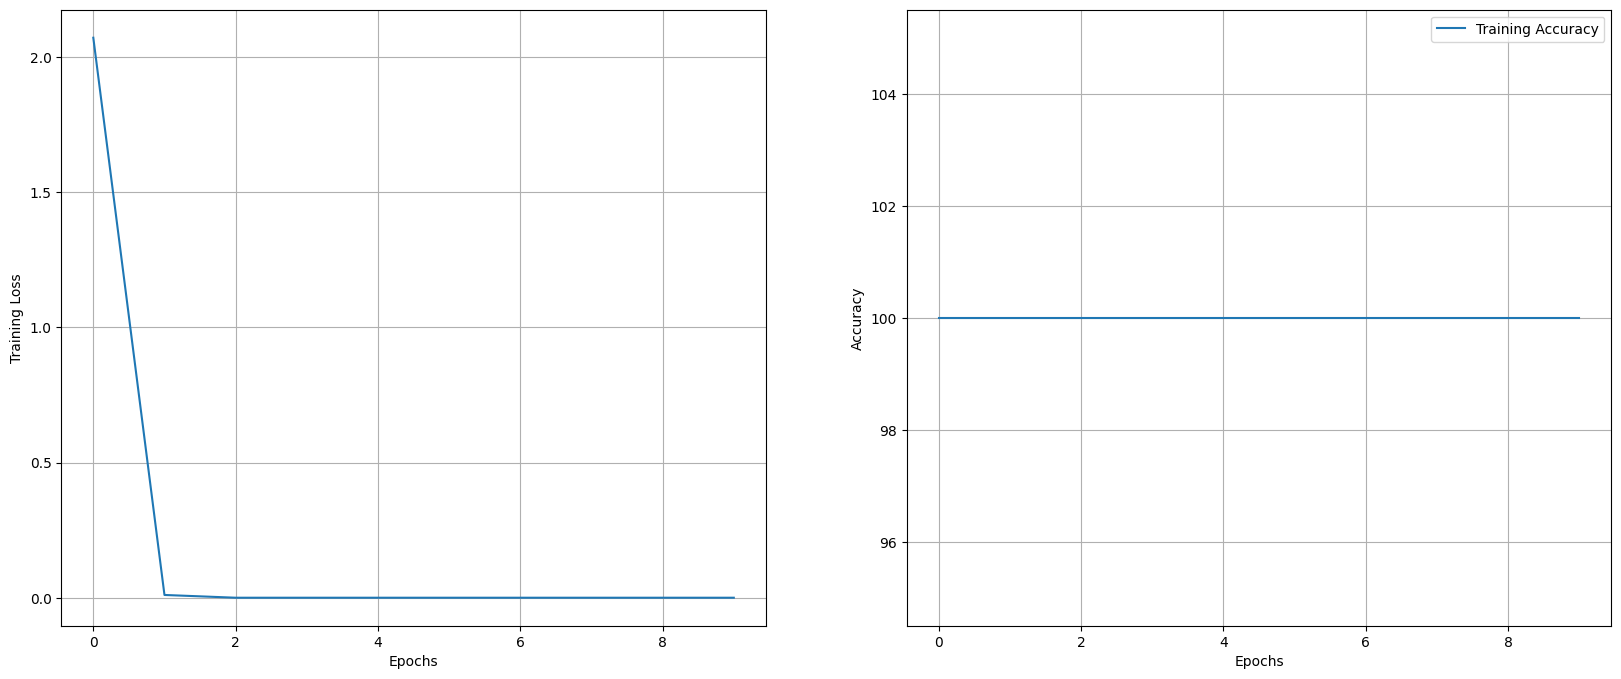

In [23]:
checkModel = copy.deepcopy(NewModel)
checkModel.to(device)

optimizer = optim.Adam(params=checkModel.parameters(), lr=0.001, weight_decay=0)

torch.cuda.empty_cache()
gc.collect()

adam_training_loss, adam_training_accuracy = overfit_model(checkModel, SampleLoader, optimizer, criterion, num_epochs=10)
plot_training_plots(adam_training_loss, adam_training_accuracy)

We can observe that Adam optimizer can overfit a sample with the given optimizers.

100%|██████████| 10/10 [00:15<00:00,  1.53s/it]


Epoch [1/10], Loss: 5.2949


100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


Accuracy of the network on the 10 train images: 0.0


100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


Epoch [2/10], Loss: 5.2395


100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


Accuracy of the network on the 10 train images: 0.0


100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


Epoch [3/10], Loss: 5.1775


100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Accuracy of the network on the 10 train images: 10.0


100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Epoch [4/10], Loss: 5.1509


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


Accuracy of the network on the 10 train images: 20.0


100%|██████████| 10/10 [00:02<00:00,  3.54it/s]


Epoch [5/10], Loss: 5.0952


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


Accuracy of the network on the 10 train images: 70.0


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


Epoch [6/10], Loss: 5.0607


100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


Accuracy of the network on the 10 train images: 95.0


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


Epoch [7/10], Loss: 5.0409


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


Epoch [8/10], Loss: 4.9162


100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


Epoch [9/10], Loss: 4.9531


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


Epoch [10/10], Loss: 4.9252


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


Accuracy of the network on the 10 train images: 100.0


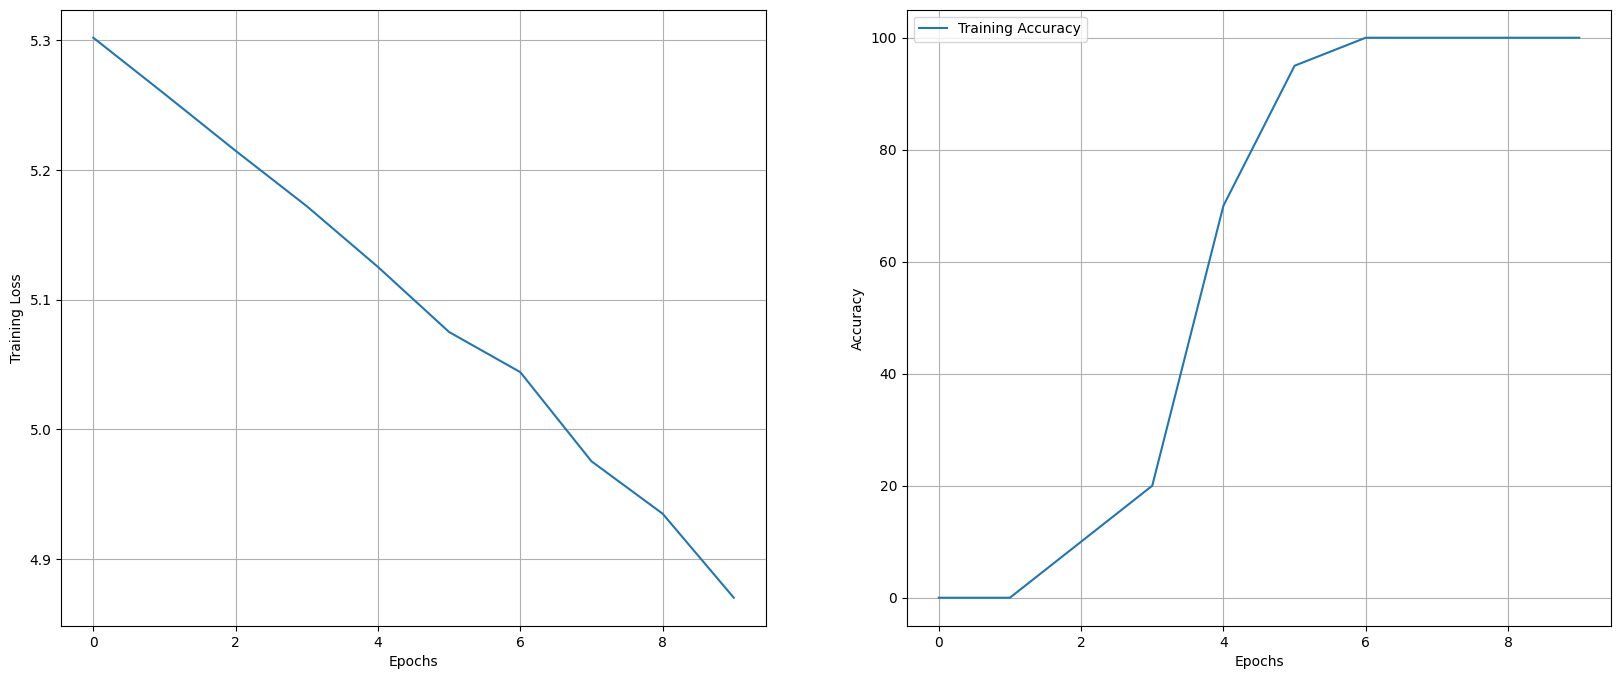

In [22]:
checkModel = copy.deepcopy(NewModel)
checkModel.to(device)
# Create a StepLR scheduler
optimizer = optim.SGD(params=checkModel.parameters(), lr=0.001, weight_decay=0)
#, momentum=0.9, weight_decay=0.0001)
# optimizer = optim.Adam(params=checkModel.parameters(), lr=0.0001, weight_decay=0)

torch.cuda.empty_cache()
gc.collect()

sgd_training_loss, sgd_training_accuracy = overfit_model(checkModel, SampleLoader, optimizer, criterion, num_epochs=10)
plot_training_plots(training_loss=sgd_training_loss, training_accuracy=sgd_training_accuracy)

100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


Epoch [1/10], Loss: 5.1362


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


Accuracy of the network on the 10 train images: 20.0


100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Epoch [2/10], Loss: 4.7632


100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Epoch [3/10], Loss: 4.2136


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


Epoch [4/10], Loss: 2.6731


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Epoch [5/10], Loss: 1.4715


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Epoch [6/10], Loss: 0.4118


100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Epoch [7/10], Loss: 0.0337


100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.84it/s]


Epoch [8/10], Loss: 0.0108


100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


Epoch [9/10], Loss: 0.0599


100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


Epoch [10/10], Loss: 0.0046


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

Accuracy of the network on the 10 train images: 100.0


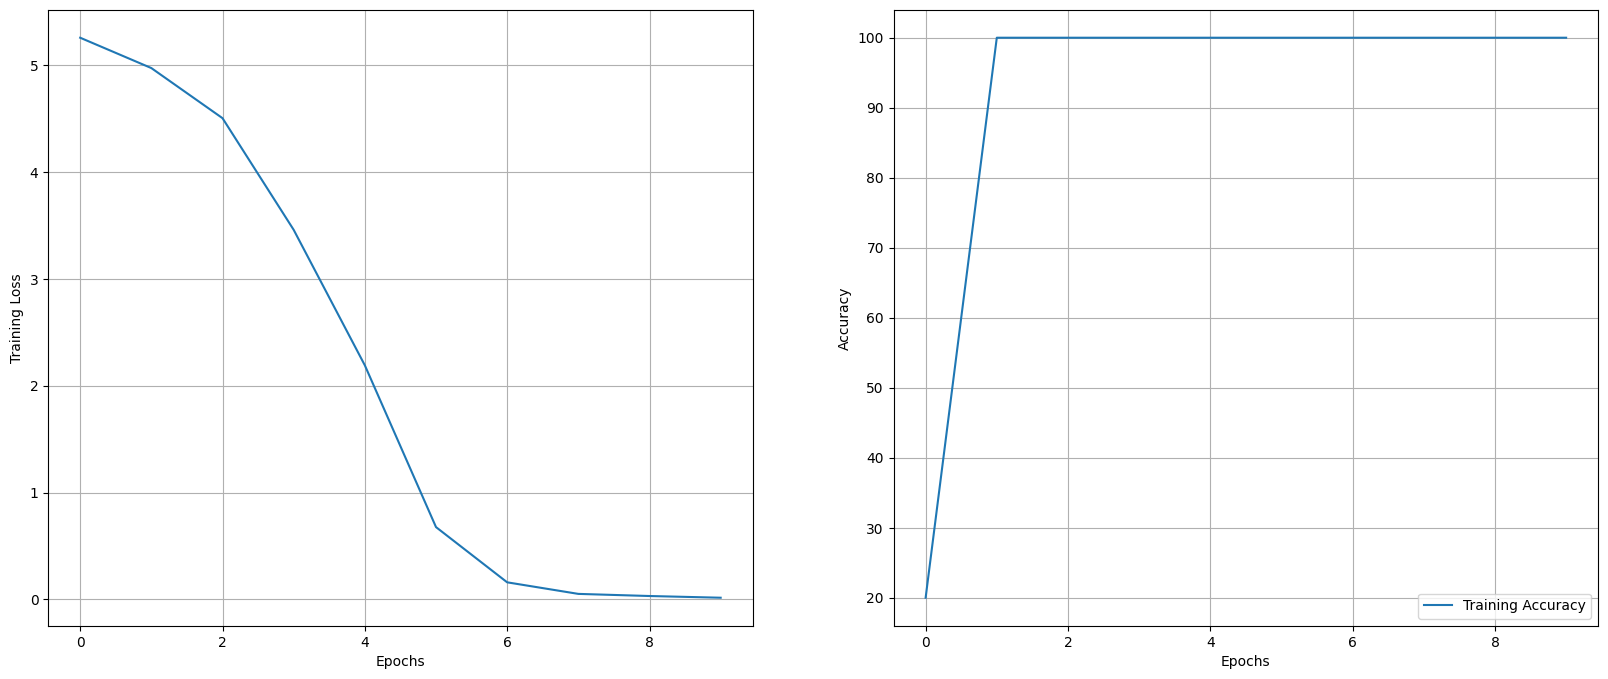

In [27]:
checkModel = copy.deepcopy(NewModel)
checkModel.to(device)
# Create a StepLR scheduler
optimizer = optim.SGD(params=checkModel.parameters(), lr=0.001, weight_decay=0, momentum=0.9)
#, momentum=0.9, weight_decay=0.0001)
# optimizer = optim.Adam(params=checkModel.parameters(), lr=0.0001, weight_decay=0)

torch.cuda.empty_cache()
gc.collect()

msgd_training_loss, msgd_training_accuracy = overfit_model(checkModel, SampleLoader, optimizer, criterion, num_epochs=10)
plot_training_plots(training_loss=msgd_training_loss, training_accuracy=msgd_training_accuracy)

100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


Epoch [1/10], Loss: 0.0131


100%|██████████| 10/10 [00:02<00:00,  3.91it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


Epoch [2/10], Loss: 0.0000


100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


Epoch [3/10], Loss: 0.0000


100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


Epoch [4/10], Loss: 0.0000


100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  4.01it/s]


Epoch [5/10], Loss: 0.0000


100%|██████████| 10/10 [00:02<00:00,  4.02it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


Epoch [6/10], Loss: 0.0000


100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


Epoch [7/10], Loss: 0.0000


100%|██████████| 10/10 [00:02<00:00,  4.16it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


Epoch [8/10], Loss: 0.0000


100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


Epoch [9/10], Loss: 0.0000


100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


Accuracy of the network on the 10 train images: 100.0


100%|██████████| 10/10 [00:02<00:00,  3.80it/s]


Epoch [10/10], Loss: 0.0000


100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

Accuracy of the network on the 10 train images: 100.0


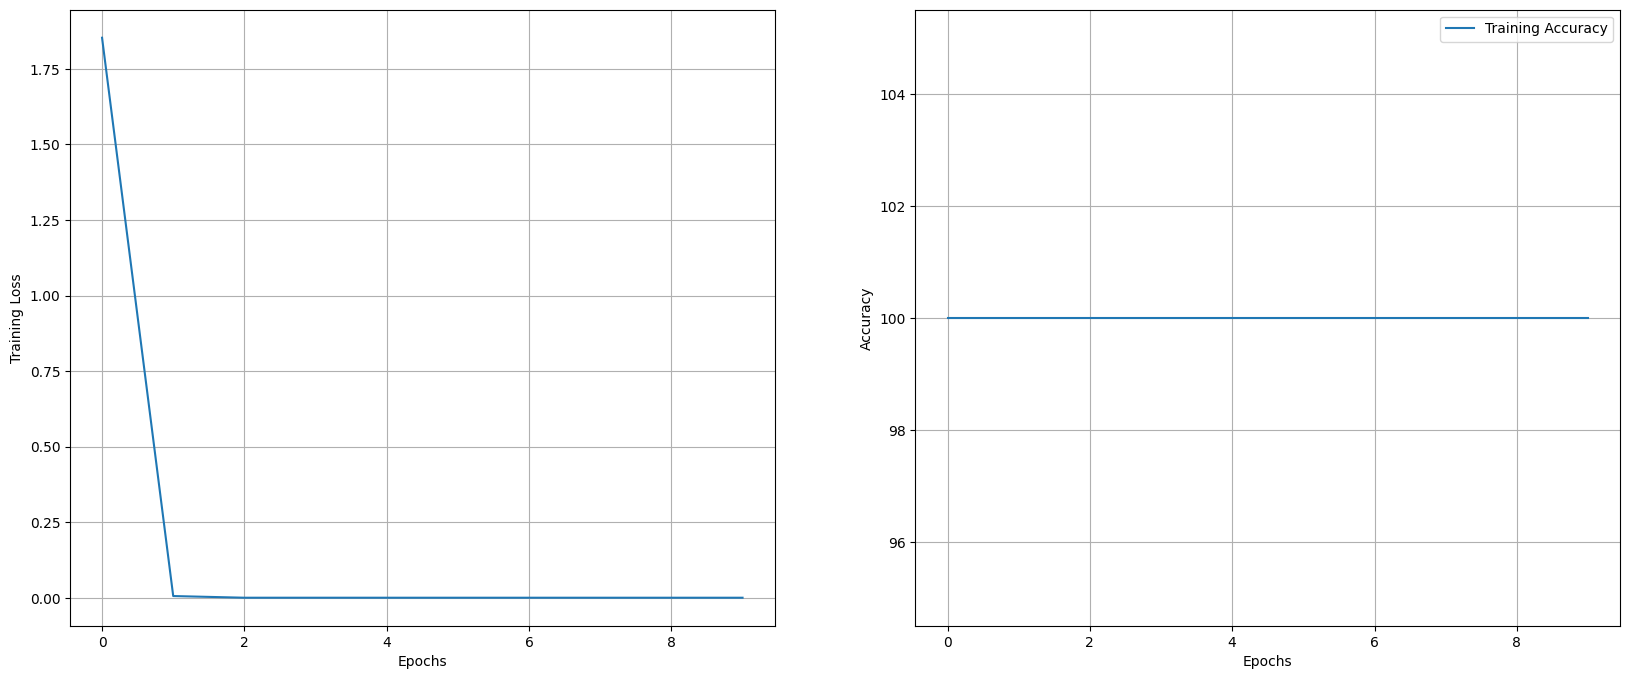

In [28]:
checkModel = copy.deepcopy(NewModel)
checkModel.to(device)
# Create a StepLR scheduler
optimizer = optim.AdamW(params=checkModel.parameters(), lr=0.001)
#, momentum=0.9, weight_decay=0.0001)
# optimizer = optim.Adam(params=checkModel.parameters(), lr=0.0001, weight_decay=0)

torch.cuda.empty_cache()
gc.collect()

adamW_training_loss, adamW_training_accuracy = overfit_model(checkModel, SampleLoader, optimizer, criterion, num_epochs=10)
plot_training_plots(training_loss=adamW_training_loss, training_accuracy=adamW_training_accuracy)

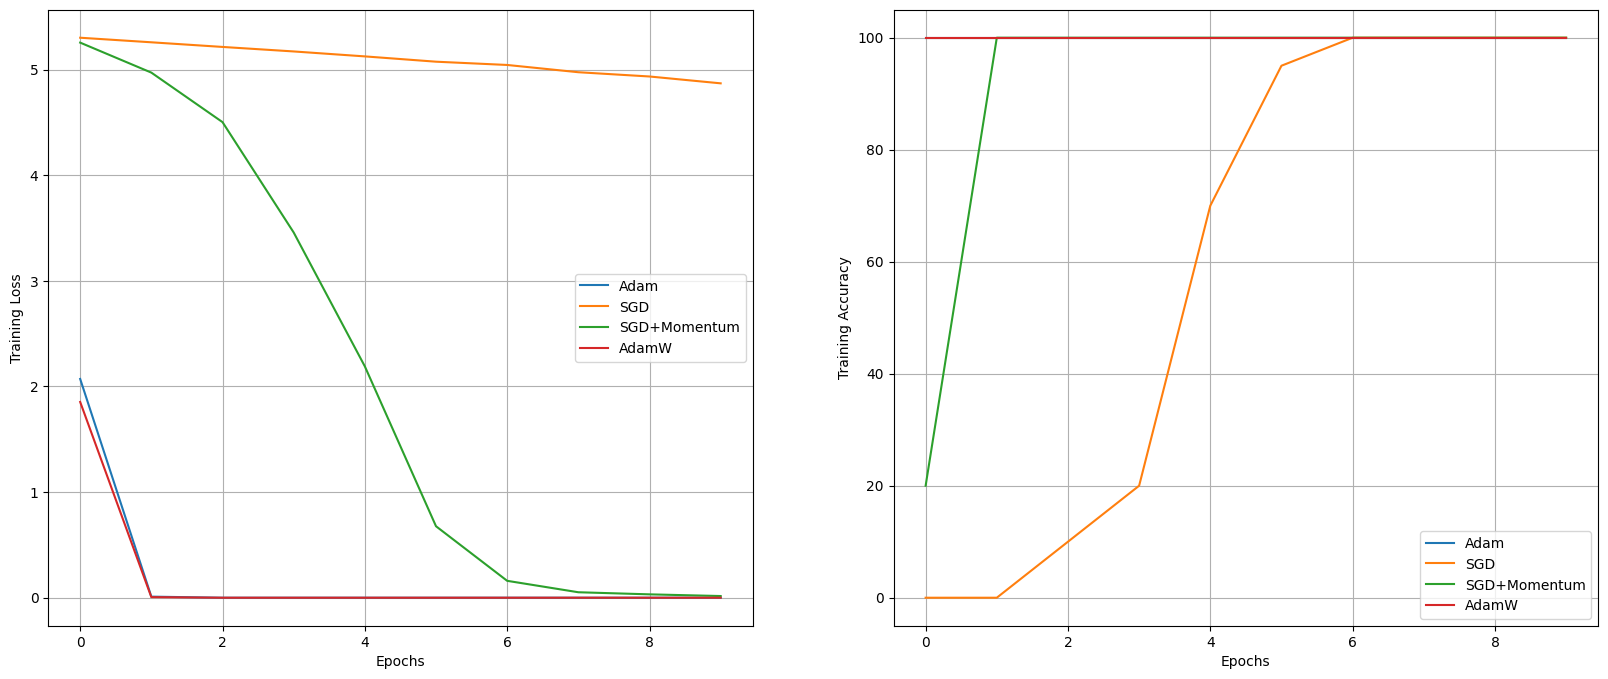

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(range(len(adam_training_loss)), adam_training_loss, label='Adam')
ax[0].plot(range(len(sgd_training_loss)), sgd_training_loss, label='SGD')
ax[0].plot(range(len(msgd_training_loss)), msgd_training_loss, label='SGD+Momentum')
ax[0].plot(range(len(adamW_training_loss)), adamW_training_loss, label='AdamW')

ax[1].plot(range(len(adam_training_accuracy)), adam_training_accuracy, label='Adam')
ax[1].plot(range(len(sgd_training_accuracy)), sgd_training_accuracy, label='SGD')
ax[1].plot(range(len(msgd_training_accuracy)), msgd_training_accuracy, label='SGD+Momentum')
ax[1].plot(range(len(adamW_training_accuracy)), adamW_training_accuracy, label='AdamW')

for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('Epochs')
    ax[i].legend()

ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Training Accuracy')

plt.show()

## Find Learning Rate that makes loss go down

Use the architecture from the previous step and use all training data, turn on small weight decay, find learning rate that makes the loss drop significantly (within 100 iterations)

Good learning rates: 1e-1, 1e-2, 1e-3, 1e-4

100%|██████████| 2400/2400 [00:28<00:00, 84.22it/s]


Epoch [1/10], Loss: 5.6597


100%|██████████| 2400/2400 [00:19<00:00, 124.89it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:24<00:00, 97.71it/s] 


Epoch [2/10], Loss: 5.5640


100%|██████████| 2400/2400 [00:19<00:00, 125.28it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:27<00:00, 86.45it/s] 


Epoch [3/10], Loss: 6.1217


100%|██████████| 2400/2400 [00:22<00:00, 105.76it/s]


Accuracy of the network on the 2400 train images: 0.5208333333333334


100%|██████████| 2400/2400 [00:29<00:00, 82.59it/s] 


Epoch [4/10], Loss: 5.5421


100%|██████████| 2400/2400 [00:18<00:00, 131.48it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:25<00:00, 95.74it/s] 


Epoch [5/10], Loss: 6.3537


100%|██████████| 2400/2400 [00:23<00:00, 103.74it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:35<00:00, 67.28it/s] 


Epoch [6/10], Loss: 5.0906


100%|██████████| 2400/2400 [00:29<00:00, 82.25it/s] 


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [01:05<00:00, 36.75it/s] 


Epoch [7/10], Loss: 5.7313


100%|██████████| 2400/2400 [00:28<00:00, 82.87it/s] 


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:59<00:00, 40.07it/s] 


Epoch [8/10], Loss: 6.0041


100%|██████████| 2400/2400 [00:37<00:00, 64.68it/s] 


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:27<00:00, 85.96it/s] 


Epoch [9/10], Loss: 5.0459


100%|██████████| 2400/2400 [00:19<00:00, 122.96it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:25<00:00, 92.46it/s] 


Epoch [10/10], Loss: 5.5351


100%|██████████| 2400/2400 [00:19<00:00, 123.10it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:33<00:00, 71.30it/s] 


Epoch [1/10], Loss: 5.2887


100%|██████████| 2400/2400 [00:21<00:00, 113.30it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:38<00:00, 62.65it/s] 


Epoch [2/10], Loss: 5.2508


100%|██████████| 2400/2400 [00:25<00:00, 92.68it/s] 


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:26<00:00, 92.22it/s] 


Epoch [3/10], Loss: 5.2623


100%|██████████| 2400/2400 [00:34<00:00, 70.07it/s] 


Accuracy of the network on the 2400 train images: 0.6875


100%|██████████| 2400/2400 [00:25<00:00, 94.99it/s] 


Epoch [4/10], Loss: 5.2326


100%|██████████| 2400/2400 [00:32<00:00, 74.81it/s] 


Accuracy of the network on the 2400 train images: 0.4791666666666667


100%|██████████| 2400/2400 [00:25<00:00, 95.25it/s] 


Epoch [5/10], Loss: 5.2276


100%|██████████| 2400/2400 [00:18<00:00, 129.11it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:24<00:00, 99.75it/s] 


Epoch [6/10], Loss: 5.5289


100%|██████████| 2400/2400 [00:18<00:00, 129.79it/s]


Accuracy of the network on the 2400 train images: 0.5208333333333334


100%|██████████| 2400/2400 [00:33<00:00, 71.00it/s] 


Epoch [7/10], Loss: 5.3588


100%|██████████| 2400/2400 [00:20<00:00, 118.06it/s]


Accuracy of the network on the 2400 train images: 0.9166666666666666


100%|██████████| 2400/2400 [00:26<00:00, 90.47it/s] 


Epoch [8/10], Loss: 5.2622


100%|██████████| 2400/2400 [00:21<00:00, 109.78it/s]


Accuracy of the network on the 2400 train images: 0.5416666666666666


100%|██████████| 2400/2400 [00:28<00:00, 84.85it/s] 


Epoch [9/10], Loss: 5.4161


100%|██████████| 2400/2400 [00:23<00:00, 102.36it/s]


Accuracy of the network on the 2400 train images: 1.25


100%|██████████| 2400/2400 [00:26<00:00, 91.37it/s] 


Epoch [10/10], Loss: 5.3698


100%|██████████| 2400/2400 [00:19<00:00, 124.77it/s]


Accuracy of the network on the 2400 train images: 0.7916666666666666


100%|██████████| 2400/2400 [00:26<00:00, 91.91it/s] 


Epoch [1/10], Loss: 5.2911


100%|██████████| 2400/2400 [00:19<00:00, 122.86it/s]


Accuracy of the network on the 2400 train images: 0.9791666666666666


100%|██████████| 2400/2400 [00:52<00:00, 45.65it/s] 


Epoch [2/10], Loss: 4.2415


100%|██████████| 2400/2400 [00:31<00:00, 75.69it/s] 


Accuracy of the network on the 2400 train images: 1.0416666666666667


100%|██████████| 2400/2400 [00:24<00:00, 97.85it/s] 


Epoch [3/10], Loss: 4.9428


100%|██████████| 2400/2400 [00:18<00:00, 126.91it/s]


Accuracy of the network on the 2400 train images: 1.2916666666666667


100%|██████████| 2400/2400 [00:24<00:00, 96.05it/s] 


Epoch [4/10], Loss: 4.8724


100%|██████████| 2400/2400 [00:18<00:00, 130.10it/s]


Accuracy of the network on the 2400 train images: 1.2708333333333333


100%|██████████| 2400/2400 [00:24<00:00, 97.94it/s] 


Epoch [5/10], Loss: 5.1359


100%|██████████| 2400/2400 [00:21<00:00, 113.49it/s]


Accuracy of the network on the 2400 train images: 1.6041666666666667


100%|██████████| 2400/2400 [00:26<00:00, 92.01it/s] 


Epoch [6/10], Loss: 4.9596


100%|██████████| 2400/2400 [00:20<00:00, 119.35it/s]


Accuracy of the network on the 2400 train images: 2.6666666666666665


100%|██████████| 2400/2400 [00:33<00:00, 71.62it/s] 


Epoch [7/10], Loss: 5.9951


100%|██████████| 2400/2400 [00:20<00:00, 119.35it/s]


Accuracy of the network on the 2400 train images: 4.958333333333333


100%|██████████| 2400/2400 [00:26<00:00, 91.79it/s] 


Epoch [8/10], Loss: 5.4435


100%|██████████| 2400/2400 [00:19<00:00, 120.46it/s]


Accuracy of the network on the 2400 train images: 8.104166666666666


100%|██████████| 2400/2400 [00:30<00:00, 78.69it/s] 


Epoch [9/10], Loss: 4.8390


100%|██████████| 2400/2400 [00:19<00:00, 120.86it/s]


Accuracy of the network on the 2400 train images: 12.229166666666666


100%|██████████| 2400/2400 [00:26<00:00, 91.81it/s] 


Epoch [10/10], Loss: 5.6787


100%|██████████| 2400/2400 [00:20<00:00, 118.57it/s]


Accuracy of the network on the 2400 train images: 12.9375


100%|██████████| 2400/2400 [00:37<00:00, 64.03it/s] 


Epoch [1/10], Loss: 5.2199


100%|██████████| 2400/2400 [00:52<00:00, 46.00it/s]


Accuracy of the network on the 2400 train images: 5.895833333333333


100%|██████████| 2400/2400 [01:01<00:00, 38.76it/s]


Epoch [2/10], Loss: 5.0072


100%|██████████| 2400/2400 [00:40<00:00, 59.23it/s]


Accuracy of the network on the 2400 train images: 10.770833333333334


100%|██████████| 2400/2400 [00:55<00:00, 43.23it/s]


Epoch [3/10], Loss: 3.9230


100%|██████████| 2400/2400 [00:42<00:00, 55.96it/s]


Accuracy of the network on the 2400 train images: 19.645833333333332


100%|██████████| 2400/2400 [00:57<00:00, 41.80it/s]


Epoch [4/10], Loss: 4.1380


100%|██████████| 2400/2400 [00:41<00:00, 57.15it/s]


Accuracy of the network on the 2400 train images: 25.125


100%|██████████| 2400/2400 [00:53<00:00, 44.85it/s]


Epoch [5/10], Loss: 4.0232


100%|██████████| 2400/2400 [00:46<00:00, 51.92it/s]


Accuracy of the network on the 2400 train images: 29.541666666666668


100%|██████████| 2400/2400 [00:58<00:00, 40.72it/s]


Epoch [6/10], Loss: 3.6896


100%|██████████| 2400/2400 [00:41<00:00, 57.20it/s]


Accuracy of the network on the 2400 train images: 33.791666666666664


100%|██████████| 2400/2400 [00:48<00:00, 49.39it/s]


Epoch [7/10], Loss: 4.2541


100%|██████████| 2400/2400 [00:36<00:00, 65.84it/s]


Accuracy of the network on the 2400 train images: 37.979166666666664


100%|██████████| 2400/2400 [00:48<00:00, 49.67it/s]


Epoch [8/10], Loss: 4.8829


100%|██████████| 2400/2400 [00:35<00:00, 67.62it/s]


Accuracy of the network on the 2400 train images: 40.229166666666664


100%|██████████| 2400/2400 [00:46<00:00, 51.52it/s]


Epoch [9/10], Loss: 2.4026


100%|██████████| 2400/2400 [00:34<00:00, 69.74it/s]


Accuracy of the network on the 2400 train images: 40.854166666666664


100%|██████████| 2400/2400 [00:46<00:00, 51.89it/s]


Epoch [10/10], Loss: 1.9099


100%|██████████| 2400/2400 [00:34<00:00, 70.01it/s]


Accuracy of the network on the 2400 train images: 43.958333333333336


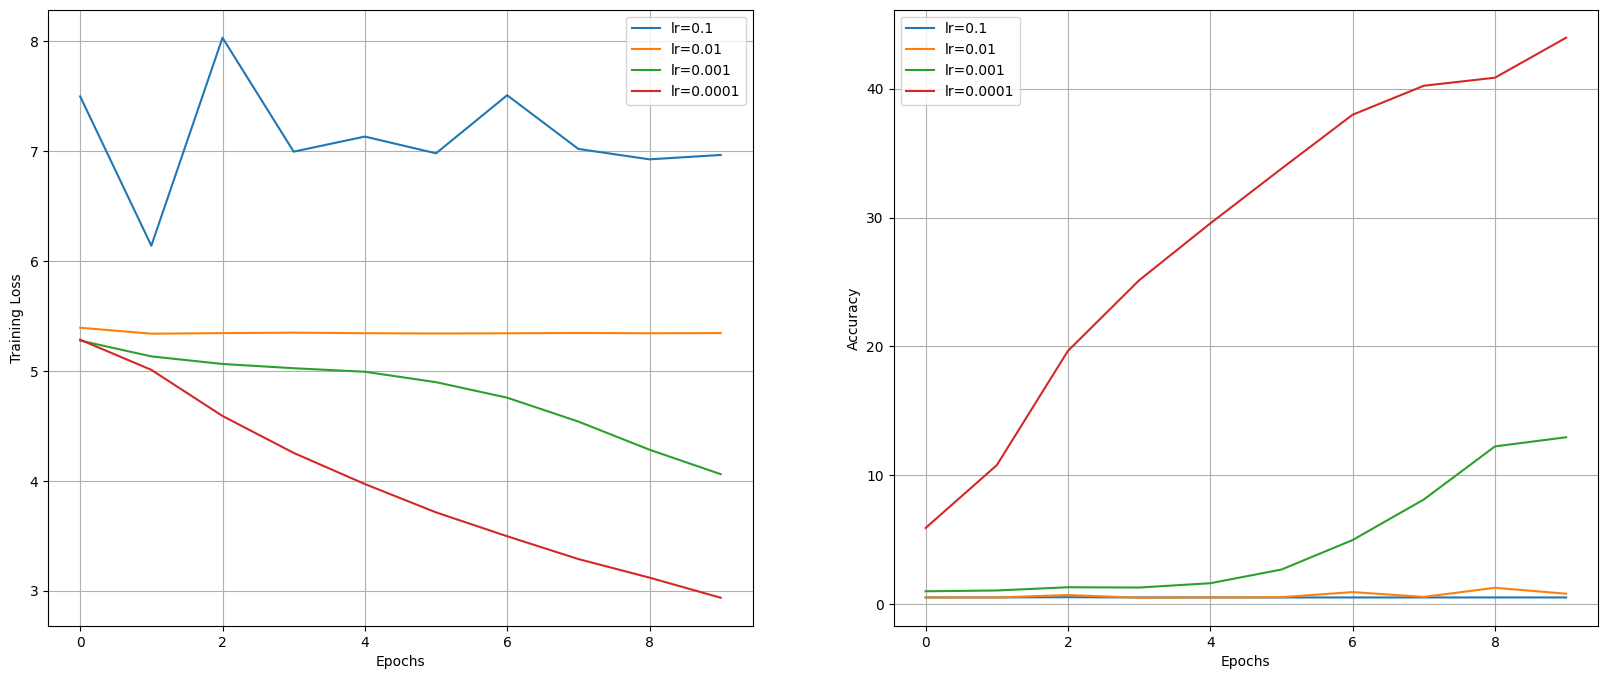

In [30]:
adam_lr_loss, adam_lr_accuracy = [], []
lr_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
for lr in lr_rates:
    print(lr)
    checkModel = copy.deepcopy(NewModel)
    checkModel.to(device)

    optimizer = optim.Adam(params=checkModel.parameters(), lr=lr, weight_decay=0.0001)

    torch.cuda.empty_cache()
    gc.collect()

    training_loss, training_accuracy = overfit_model(checkModel, TrainLoader, 
                                                        optimizer, criterion, num_epochs=10)

    adam_lr_loss.append(training_loss)
    adam_lr_accuracy.append(training_accuracy)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
for i in range(len(lr_rates)):
    ax[0].plot(range(len(adam_lr_loss[i])), adam_lr_loss[i], label=f"lr={lr_rates[i]}")
    ax[1].plot(range(len(adam_lr_accuracy[i])), adam_lr_accuracy[i], label=f"lr={lr_rates[i]}")

for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('Epochs')
    ax[i].legend()

ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Accuracy')
plt.show()

In [32]:
checkModel = copy.deepcopy(NewModel)
checkModel.to(device)

optimizer = optim.Adam(params=checkModel.parameters(), lr=1e-5, weight_decay=0.0001)

torch.cuda.empty_cache()
gc.collect()

training_loss, training_accuracy = overfit_model(checkModel, TrainLoader, 
                                                    optimizer, criterion, num_epochs=10)

adam_lr_loss.append(training_loss)
adam_lr_accuracy.append(training_accuracy)

100%|██████████| 2400/2400 [00:45<00:00, 52.83it/s]


Epoch [1/10], Loss: 5.3369


100%|██████████| 2400/2400 [00:34<00:00, 70.35it/s]


Accuracy of the network on the 2400 train images: 1.6041666666666667


100%|██████████| 2400/2400 [00:46<00:00, 51.12it/s]


Epoch [2/10], Loss: 5.3326


100%|██████████| 2400/2400 [00:38<00:00, 62.26it/s]


Accuracy of the network on the 2400 train images: 4.333333333333333


100%|██████████| 2400/2400 [00:46<00:00, 51.61it/s]


Epoch [3/10], Loss: 5.2485


100%|██████████| 2400/2400 [00:34<00:00, 68.69it/s]


Accuracy of the network on the 2400 train images: 6.958333333333333


100%|██████████| 2400/2400 [00:46<00:00, 51.36it/s]


Epoch [4/10], Loss: 5.3783


100%|██████████| 2400/2400 [00:34<00:00, 70.04it/s]


Accuracy of the network on the 2400 train images: 11.583333333333334


100%|██████████| 2400/2400 [00:46<00:00, 51.85it/s]


Epoch [5/10], Loss: 5.1270


100%|██████████| 2400/2400 [00:34<00:00, 68.66it/s]


Accuracy of the network on the 2400 train images: 17.166666666666668


100%|██████████| 2400/2400 [00:45<00:00, 52.28it/s]


Epoch [6/10], Loss: 5.1924


100%|██████████| 2400/2400 [00:34<00:00, 68.96it/s]


Accuracy of the network on the 2400 train images: 20.416666666666668


100%|██████████| 2400/2400 [00:45<00:00, 52.24it/s]


Epoch [7/10], Loss: 5.1116


100%|██████████| 2400/2400 [00:34<00:00, 68.58it/s]


Accuracy of the network on the 2400 train images: 21.1875


100%|██████████| 2400/2400 [00:45<00:00, 52.66it/s]


Epoch [8/10], Loss: 5.0930


100%|██████████| 2400/2400 [00:36<00:00, 66.64it/s]


Accuracy of the network on the 2400 train images: 23.604166666666668


100%|██████████| 2400/2400 [00:46<00:00, 51.92it/s]


Epoch [9/10], Loss: 5.1136


100%|██████████| 2400/2400 [00:34<00:00, 68.58it/s]


Accuracy of the network on the 2400 train images: 24.916666666666668


100%|██████████| 2400/2400 [00:45<00:00, 52.29it/s]


Epoch [10/10], Loss: 4.8853


100%|██████████| 2400/2400 [00:34<00:00, 68.67it/s]

Accuracy of the network on the 2400 train images: 25.020833333333332


In [37]:
lr_rates.append(1e-5)

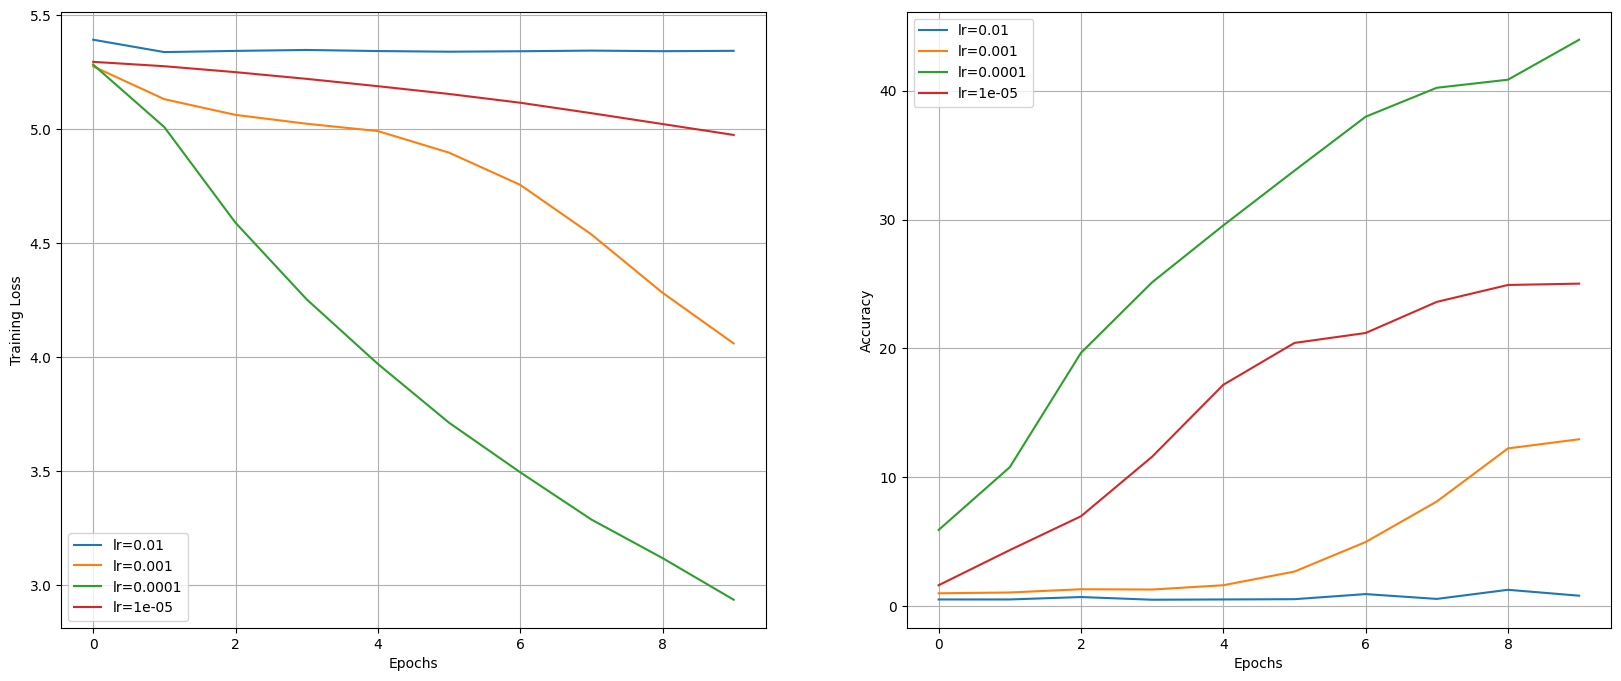

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
for i in range(1, len(lr_rates)):
    ax[0].plot(range(len(adam_lr_loss[i])), adam_lr_loss[i], label=f"lr={lr_rates[i]}")
    ax[1].plot(range(len(adam_lr_accuracy[i])), adam_lr_accuracy[i], label=f"lr={lr_rates[i]}")

for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('Epochs')
    ax[i].legend()

ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Accuracy')
plt.show()

100%|██████████| 2400/2400 [00:31<00:00, 76.25it/s] 


Epoch [1/10], Loss: 31.9649


100%|██████████| 2400/2400 [00:22<00:00, 107.03it/s]


Accuracy of the network on the 2400 train images: 26.291666666666668


100%|██████████| 2400/2400 [00:41<00:00, 58.48it/s] 


Epoch [2/10], Loss: 81.1383


100%|██████████| 2400/2400 [00:24<00:00, 98.84it/s] 


Accuracy of the network on the 2400 train images: 44.333333333333336


100%|██████████| 2400/2400 [00:26<00:00, 91.78it/s] 


Epoch [3/10], Loss: 69.7160


100%|██████████| 2400/2400 [00:25<00:00, 94.87it/s] 


Accuracy of the network on the 2400 train images: 51.020833333333336


100%|██████████| 2400/2400 [00:33<00:00, 71.15it/s] 


Epoch [4/10], Loss: 36.7288


100%|██████████| 2400/2400 [00:21<00:00, 113.65it/s]


Accuracy of the network on the 2400 train images: 57.1875


100%|██████████| 2400/2400 [00:45<00:00, 53.12it/s] 


Epoch [5/10], Loss: 13.5097


100%|██████████| 2400/2400 [00:39<00:00, 60.28it/s] 


Accuracy of the network on the 2400 train images: 60.0625


100%|██████████| 2400/2400 [00:52<00:00, 45.84it/s]


Epoch [6/10], Loss: 34.1976


100%|██████████| 2400/2400 [00:29<00:00, 81.28it/s] 


Accuracy of the network on the 2400 train images: 63.145833333333336


100%|██████████| 2400/2400 [00:37<00:00, 63.92it/s] 


Epoch [7/10], Loss: 54.5175


100%|██████████| 2400/2400 [00:20<00:00, 115.26it/s]


Accuracy of the network on the 2400 train images: 61.479166666666664


100%|██████████| 2400/2400 [00:41<00:00, 57.82it/s] 


Epoch [8/10], Loss: 124.2061


100%|██████████| 2400/2400 [00:20<00:00, 117.05it/s]


Accuracy of the network on the 2400 train images: 65.25


100%|██████████| 2400/2400 [00:25<00:00, 94.19it/s] 


Epoch [9/10], Loss: 148.6052


100%|██████████| 2400/2400 [00:27<00:00, 87.53it/s] 


Accuracy of the network on the 2400 train images: 66.75


100%|██████████| 2400/2400 [00:28<00:00, 84.59it/s] 


Epoch [10/10], Loss: 0.0000


100%|██████████| 2400/2400 [00:19<00:00, 120.09it/s]


Accuracy of the network on the 2400 train images: 63.5625


100%|██████████| 2400/2400 [00:46<00:00, 51.33it/s]


Epoch [1/10], Loss: 11.1295


100%|██████████| 2400/2400 [00:24<00:00, 99.20it/s] 


Accuracy of the network on the 2400 train images: 42.125


100%|██████████| 2400/2400 [00:31<00:00, 77.21it/s] 


Epoch [2/10], Loss: 1.9648


100%|██████████| 2400/2400 [00:20<00:00, 114.44it/s]


Accuracy of the network on the 2400 train images: 57.1875


100%|██████████| 2400/2400 [00:27<00:00, 86.15it/s] 


Epoch [3/10], Loss: 4.2366


100%|██████████| 2400/2400 [00:27<00:00, 88.30it/s] 


Accuracy of the network on the 2400 train images: 53.208333333333336


100%|██████████| 2400/2400 [00:28<00:00, 84.39it/s] 


Epoch [4/10], Loss: 1.1697


100%|██████████| 2400/2400 [00:32<00:00, 73.15it/s] 


Accuracy of the network on the 2400 train images: 64.58333333333333


100%|██████████| 2400/2400 [00:27<00:00, 87.92it/s] 


Epoch [5/10], Loss: 1.2057


100%|██████████| 2400/2400 [00:33<00:00, 71.79it/s] 


Accuracy of the network on the 2400 train images: 67.89583333333333


100%|██████████| 2400/2400 [00:29<00:00, 82.62it/s] 


Epoch [6/10], Loss: 6.7032


100%|██████████| 2400/2400 [00:30<00:00, 78.70it/s] 


Accuracy of the network on the 2400 train images: 61.729166666666664


100%|██████████| 2400/2400 [00:29<00:00, 81.12it/s] 


Epoch [7/10], Loss: 5.8771


100%|██████████| 2400/2400 [00:22<00:00, 106.64it/s]


Accuracy of the network on the 2400 train images: 67.625


100%|██████████| 2400/2400 [00:25<00:00, 94.97it/s] 


Epoch [8/10], Loss: 1.0275


100%|██████████| 2400/2400 [00:20<00:00, 119.55it/s]


Accuracy of the network on the 2400 train images: 70.20833333333333


100%|██████████| 2400/2400 [00:50<00:00, 47.79it/s] 


Epoch [9/10], Loss: 0.0006


100%|██████████| 2400/2400 [00:19<00:00, 120.01it/s]


Accuracy of the network on the 2400 train images: 70.04166666666667


100%|██████████| 2400/2400 [00:42<00:00, 56.66it/s] 


Epoch [10/10], Loss: 12.1858


100%|██████████| 2400/2400 [00:22<00:00, 105.80it/s]


Accuracy of the network on the 2400 train images: 71.79166666666667


100%|██████████| 2400/2400 [00:28<00:00, 85.34it/s] 


Epoch [1/10], Loss: 4.2083


100%|██████████| 2400/2400 [00:28<00:00, 84.62it/s] 


Accuracy of the network on the 2400 train images: 38.0


100%|██████████| 2400/2400 [00:30<00:00, 79.58it/s] 


Epoch [2/10], Loss: 3.4515


100%|██████████| 2400/2400 [00:22<00:00, 105.56it/s]


Accuracy of the network on the 2400 train images: 53.875


100%|██████████| 2400/2400 [00:29<00:00, 80.75it/s] 


Epoch [3/10], Loss: 1.3928


100%|██████████| 2400/2400 [00:30<00:00, 78.16it/s] 


Accuracy of the network on the 2400 train images: 63.625


100%|██████████| 2400/2400 [00:27<00:00, 88.51it/s] 


Epoch [4/10], Loss: 0.6179


100%|██████████| 2400/2400 [00:19<00:00, 122.26it/s]


Accuracy of the network on the 2400 train images: 71.54166666666667


100%|██████████| 2400/2400 [00:33<00:00, 72.52it/s] 


Epoch [5/10], Loss: 2.7021


100%|██████████| 2400/2400 [00:28<00:00, 83.96it/s] 


Accuracy of the network on the 2400 train images: 76.3125


100%|██████████| 2400/2400 [00:46<00:00, 51.55it/s] 


Epoch [6/10], Loss: 1.0078


100%|██████████| 2400/2400 [00:24<00:00, 96.23it/s] 


Accuracy of the network on the 2400 train images: 76.64583333333333


100%|██████████| 2400/2400 [00:32<00:00, 73.70it/s] 


Epoch [7/10], Loss: 0.6216


100%|██████████| 2400/2400 [00:26<00:00, 89.72it/s] 


Accuracy of the network on the 2400 train images: 78.375


100%|██████████| 2400/2400 [00:28<00:00, 85.24it/s] 


Epoch [8/10], Loss: 0.2145


100%|██████████| 2400/2400 [00:19<00:00, 120.84it/s]


Accuracy of the network on the 2400 train images: 82.77083333333333


100%|██████████| 2400/2400 [00:26<00:00, 90.73it/s] 


Epoch [9/10], Loss: 1.0770


100%|██████████| 2400/2400 [00:28<00:00, 83.74it/s] 


Accuracy of the network on the 2400 train images: 81.60416666666667


100%|██████████| 2400/2400 [00:38<00:00, 62.01it/s] 


Epoch [10/10], Loss: 4.1554


100%|██████████| 2400/2400 [00:23<00:00, 101.47it/s]


Accuracy of the network on the 2400 train images: 80.10416666666667


100%|██████████| 2400/2400 [00:28<00:00, 84.07it/s] 


Epoch [1/10], Loss: 5.1068


100%|██████████| 2400/2400 [00:20<00:00, 115.44it/s]


Accuracy of the network on the 2400 train images: 14.25


100%|██████████| 2400/2400 [00:28<00:00, 83.67it/s] 


Epoch [2/10], Loss: 4.9186


100%|██████████| 2400/2400 [00:20<00:00, 116.71it/s]


Accuracy of the network on the 2400 train images: 30.458333333333332


100%|██████████| 2400/2400 [00:27<00:00, 88.76it/s] 


Epoch [3/10], Loss: 4.4385


100%|██████████| 2400/2400 [00:21<00:00, 114.21it/s]


Accuracy of the network on the 2400 train images: 35.1875


100%|██████████| 2400/2400 [00:27<00:00, 87.52it/s] 


Epoch [4/10], Loss: 3.4635


100%|██████████| 2400/2400 [00:20<00:00, 115.81it/s]


Accuracy of the network on the 2400 train images: 42.145833333333336


100%|██████████| 2400/2400 [00:27<00:00, 88.06it/s] 


Epoch [5/10], Loss: 4.3180


100%|██████████| 2400/2400 [00:21<00:00, 110.59it/s]


Accuracy of the network on the 2400 train images: 43.875


100%|██████████| 2400/2400 [00:26<00:00, 89.69it/s] 


Epoch [6/10], Loss: 4.4993


100%|██████████| 2400/2400 [00:21<00:00, 113.53it/s]


Accuracy of the network on the 2400 train images: 49.0625


100%|██████████| 2400/2400 [00:41<00:00, 58.52it/s] 


Epoch [7/10], Loss: 4.0887


100%|██████████| 2400/2400 [00:20<00:00, 114.91it/s]


Accuracy of the network on the 2400 train images: 49.979166666666664


100%|██████████| 2400/2400 [00:27<00:00, 87.16it/s] 


Epoch [8/10], Loss: 3.3455


100%|██████████| 2400/2400 [00:20<00:00, 118.86it/s]


Accuracy of the network on the 2400 train images: 53.604166666666664


100%|██████████| 2400/2400 [00:27<00:00, 87.65it/s] 


Epoch [9/10], Loss: 3.2028


100%|██████████| 2400/2400 [00:25<00:00, 94.62it/s] 


Accuracy of the network on the 2400 train images: 56.604166666666664


100%|██████████| 2400/2400 [00:26<00:00, 91.39it/s] 


Epoch [10/10], Loss: 3.6453


100%|██████████| 2400/2400 [00:19<00:00, 121.41it/s]


Accuracy of the network on the 2400 train images: 58.791666666666664


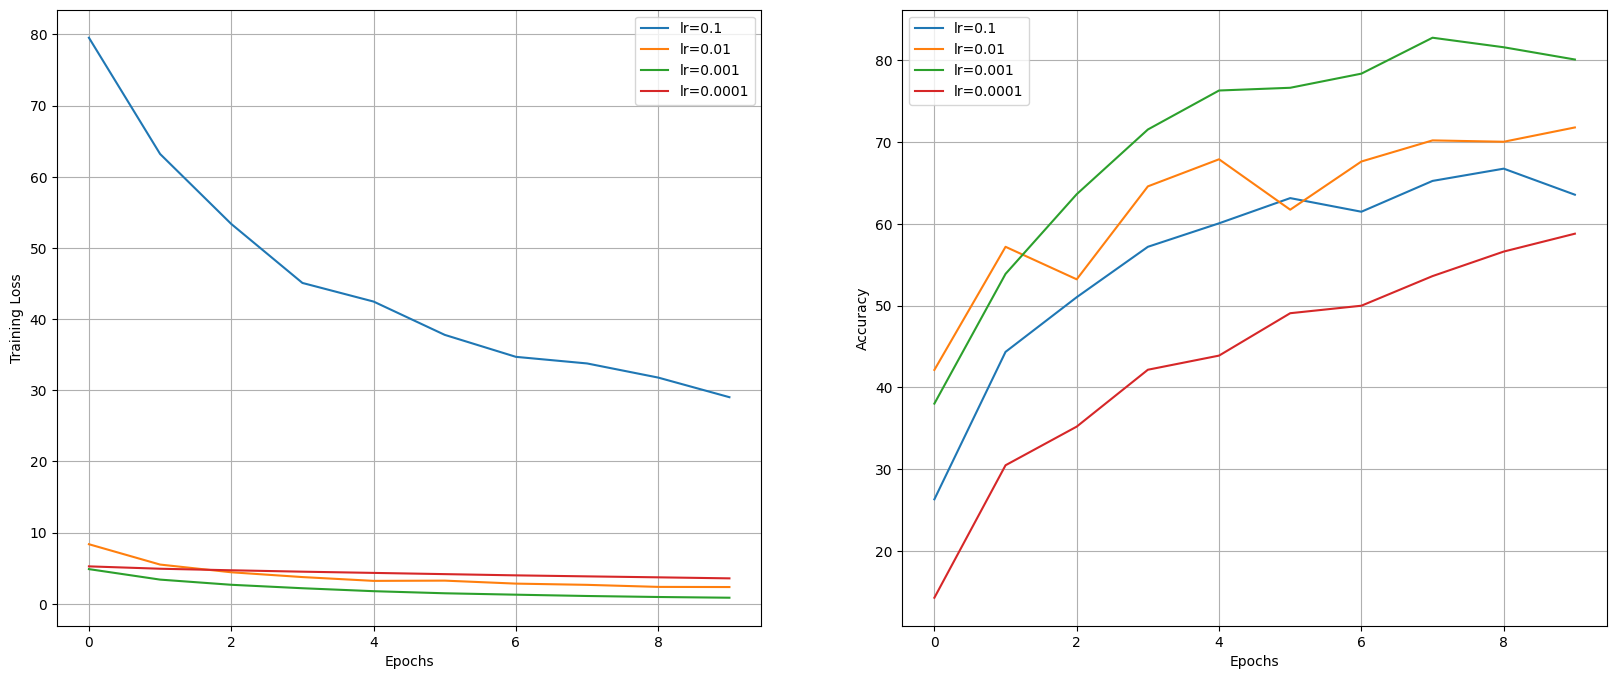

In [21]:
adamW_lr_loss, adamW_lr_accuracy = [], []
lr_rates = [1e-1, 1e-2, 1e-3, 1e-4]
for lr in lr_rates:
    checkModel = copy.deepcopy(NewModel)
    checkModel.to(device)

    optimizer = optim.AdamW(params=checkModel.parameters(), lr=lr, weight_decay=0.0001)

    torch.cuda.empty_cache()
    gc.collect()

    training_loss, training_accuracy = overfit_model(checkModel, TrainLoader, 
                                                        optimizer, criterion, num_epochs=10)

    adamW_lr_loss.append(training_loss)
    adamW_lr_accuracy.append(training_accuracy)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))
for i in range(len(lr_rates)):
    ax[0].plot(range(len(adamW_lr_loss[i])), adamW_lr_loss[i], label=f"lr={lr_rates[i]}")
    ax[1].plot(range(len(adamW_lr_accuracy[i])), adamW_lr_accuracy[i], label=f"lr={lr_rates[i]}")

for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('Epochs')
    ax[i].legend()

ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Accuracy')
plt.show()

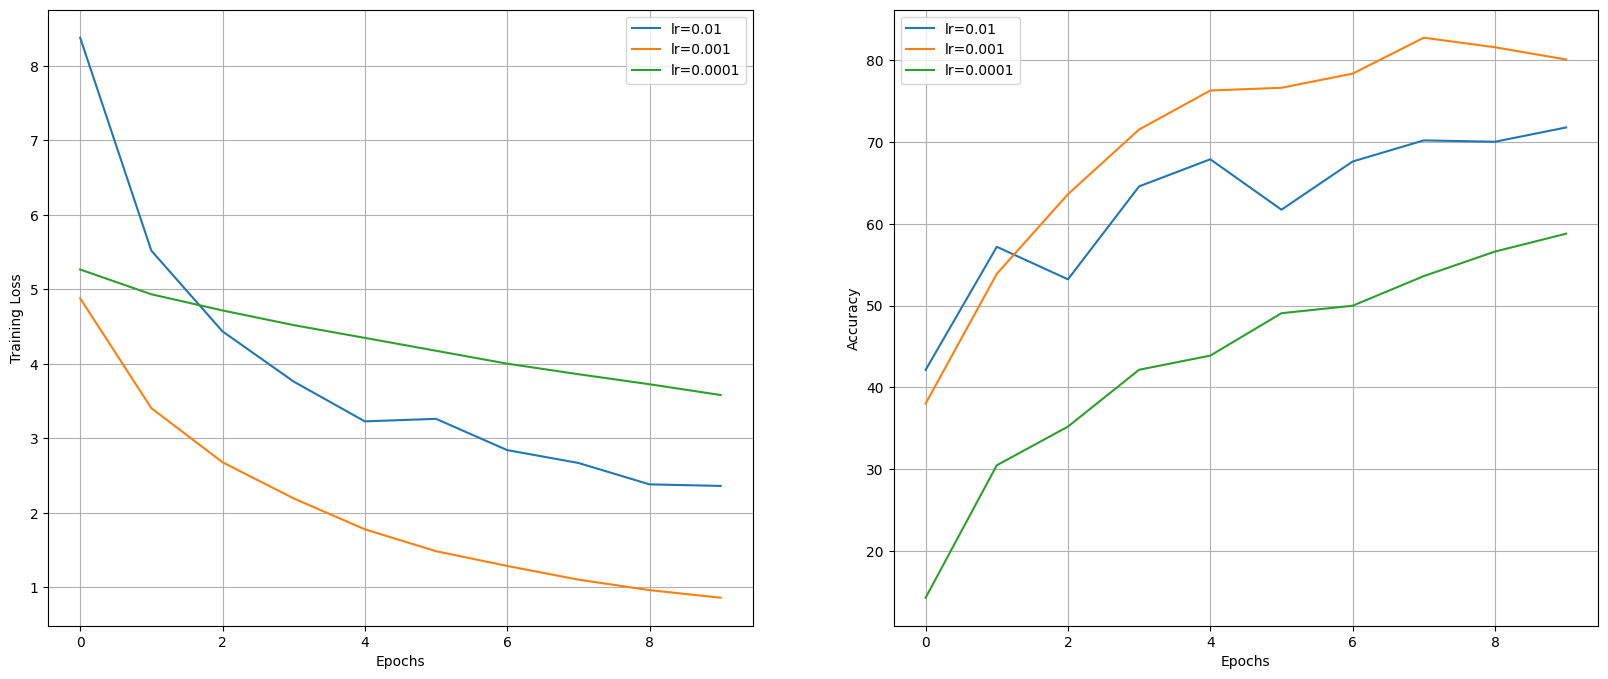

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
for i in range(1, len(lr_rates)):
    ax[0].plot(range(len(adamW_lr_loss[i])), adamW_lr_loss[i], label=f"lr={lr_rates[i]}")
    ax[1].plot(range(len(adamW_lr_accuracy[i])), adamW_lr_accuracy[i], label=f"lr={lr_rates[i]}")

for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('Epochs')
    ax[i].legend()

ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Accuracy')
plt.show()

## Coarse grid (train for 1-5 epochs)

Choose a few values of learning rate and weight decay around what worked on step 3, tain a few models for 1-5 epochs

Good weight decay to try: 1e-4, 1e-5, 0

In [46]:
np.random.uniform(3/4 * 1e-3, 4/3 * 1e-3, size=9)

array([0.00117511, 0.00099065, 0.0012461 , 0.00084475, 0.00132516,
       0.00120026, 0.00081308, 0.00130678, 0.00112064])

In [40]:
adam_lr_wd_loss, adam_lr_wd_accuracy = [], []
# lr_rates = np.random.uniform(3/4 * 1e-3, 4/3 * 1e-3, size=9)
# lr_rates = [1e-2, 1e-3, 1e-4, 1e-5]
weight_decay = np.array([0, 1e-4, 1e-5])

for lr in lr_rates:
    for wd in weight_decay:
        print(f"lr={lr}, wd={wd}")
        checkModel = copy.deepcopy(NewModel)
        checkModel.to(device)

        optimizer = optim.Adam(params=checkModel.parameters(), lr=lr, weight_decay=wd)

        torch.cuda.empty_cache()
        gc.collect()

        training_loss, training_accuracy = overfit_model(checkModel, TrainLoader, 
                                                            optimizer, criterion, num_epochs=5)

        adam_lr_wd_loss.append(training_loss)
        adam_lr_wd_accuracy.append(training_accuracy)
        print()


lr=0.1, wd=0.0


100%|██████████| 2400/2400 [00:50<00:00, 47.50it/s]


Epoch [1/5], Loss: 4.7980


100%|██████████| 2400/2400 [00:34<00:00, 69.31it/s]


Accuracy of the network on the 2400 train images: 0.4375


100%|██████████| 2400/2400 [00:47<00:00, 50.90it/s]


Epoch [2/5], Loss: 5.5865


100%|██████████| 2400/2400 [00:36<00:00, 65.18it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:47<00:00, 50.19it/s]


Epoch [3/5], Loss: 5.4701


100%|██████████| 2400/2400 [00:36<00:00, 65.42it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:47<00:00, 50.21it/s]


Epoch [4/5], Loss: 5.5074


100%|██████████| 2400/2400 [00:35<00:00, 66.97it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:48<00:00, 49.42it/s]


Epoch [5/5], Loss: 5.1914


100%|██████████| 2400/2400 [00:37<00:00, 64.67it/s]


Accuracy of the network on the 2400 train images: 0.5

lr=0.1, wd=0.0001


100%|██████████| 2400/2400 [00:48<00:00, 49.89it/s]


Epoch [1/5], Loss: 15.1603


100%|██████████| 2400/2400 [00:35<00:00, 66.80it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:48<00:00, 49.36it/s]


Epoch [2/5], Loss: 5.2134


100%|██████████| 2400/2400 [00:40<00:00, 59.63it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:48<00:00, 49.79it/s]


Epoch [3/5], Loss: 5.6563


100%|██████████| 2400/2400 [00:38<00:00, 61.90it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:48<00:00, 49.97it/s]


Epoch [4/5], Loss: 5.5805


100%|██████████| 2400/2400 [00:37<00:00, 64.73it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:53<00:00, 44.95it/s]


Epoch [5/5], Loss: 5.9833


100%|██████████| 2400/2400 [00:30<00:00, 78.84it/s] 


Accuracy of the network on the 2400 train images: 0.5

lr=0.1, wd=1e-05


100%|██████████| 2400/2400 [00:26<00:00, 89.41it/s] 


Epoch [1/5], Loss: 5.6442


100%|██████████| 2400/2400 [00:18<00:00, 130.94it/s]


Accuracy of the network on the 2400 train images: 0.6041666666666666


100%|██████████| 2400/2400 [00:27<00:00, 85.94it/s] 


Epoch [2/5], Loss: 5.5965


100%|██████████| 2400/2400 [00:19<00:00, 123.81it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:28<00:00, 83.02it/s] 


Epoch [3/5], Loss: 5.9316


100%|██████████| 2400/2400 [00:20<00:00, 119.19it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:28<00:00, 83.91it/s] 


Epoch [4/5], Loss: 6.5599


100%|██████████| 2400/2400 [00:20<00:00, 117.05it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:28<00:00, 85.21it/s] 


Epoch [5/5], Loss: 5.5559


100%|██████████| 2400/2400 [00:19<00:00, 120.05it/s]


Accuracy of the network on the 2400 train images: 0.5

lr=0.01, wd=0.0


100%|██████████| 2400/2400 [00:28<00:00, 84.85it/s] 


Epoch [1/5], Loss: 5.3755


100%|██████████| 2400/2400 [00:19<00:00, 123.97it/s]


Accuracy of the network on the 2400 train images: 0.625


100%|██████████| 2400/2400 [00:28<00:00, 82.87it/s] 


Epoch [2/5], Loss: 5.2667


100%|██████████| 2400/2400 [00:19<00:00, 120.91it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:25<00:00, 92.43it/s] 


Epoch [3/5], Loss: 5.4902


100%|██████████| 2400/2400 [00:18<00:00, 127.80it/s]


Accuracy of the network on the 2400 train images: 0.5208333333333334


100%|██████████| 2400/2400 [00:26<00:00, 91.06it/s] 


Epoch [4/5], Loss: 5.3635


100%|██████████| 2400/2400 [00:20<00:00, 117.52it/s]


Accuracy of the network on the 2400 train images: 0.5208333333333334


100%|██████████| 2400/2400 [00:25<00:00, 93.70it/s] 


Epoch [5/5], Loss: 5.4357


100%|██████████| 2400/2400 [00:20<00:00, 119.84it/s]


Accuracy of the network on the 2400 train images: 0.5

lr=0.01, wd=0.0001


100%|██████████| 2400/2400 [00:25<00:00, 92.71it/s] 


Epoch [1/5], Loss: 5.3228


100%|██████████| 2400/2400 [00:20<00:00, 118.65it/s]


Accuracy of the network on the 2400 train images: 0.5416666666666666


100%|██████████| 2400/2400 [00:25<00:00, 92.59it/s] 


Epoch [2/5], Loss: 5.4248


100%|██████████| 2400/2400 [00:20<00:00, 117.24it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:25<00:00, 92.88it/s] 


Epoch [3/5], Loss: 5.4357


100%|██████████| 2400/2400 [00:19<00:00, 120.33it/s]


Accuracy of the network on the 2400 train images: 0.4583333333333333


100%|██████████| 2400/2400 [00:27<00:00, 88.77it/s] 


Epoch [4/5], Loss: 5.2664


100%|██████████| 2400/2400 [00:21<00:00, 112.42it/s]


Accuracy of the network on the 2400 train images: 0.6041666666666666


100%|██████████| 2400/2400 [00:26<00:00, 89.51it/s] 


Epoch [5/5], Loss: 5.2017


100%|██████████| 2400/2400 [00:21<00:00, 113.26it/s]


Accuracy of the network on the 2400 train images: 0.6666666666666666

lr=0.01, wd=1e-05


100%|██████████| 2400/2400 [00:27<00:00, 88.60it/s] 


Epoch [1/5], Loss: 5.3592


100%|██████████| 2400/2400 [00:21<00:00, 111.37it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:27<00:00, 88.80it/s] 


Epoch [2/5], Loss: 5.1473


100%|██████████| 2400/2400 [00:21<00:00, 113.14it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:27<00:00, 88.52it/s] 


Epoch [3/5], Loss: 5.2774


100%|██████████| 2400/2400 [00:21<00:00, 113.22it/s]


Accuracy of the network on the 2400 train images: 0.5208333333333334


100%|██████████| 2400/2400 [00:27<00:00, 87.76it/s] 


Epoch [4/5], Loss: 5.3913


100%|██████████| 2400/2400 [00:21<00:00, 112.31it/s]


Accuracy of the network on the 2400 train images: 0.5


100%|██████████| 2400/2400 [00:25<00:00, 94.89it/s] 


Epoch [5/5], Loss: 5.2592


100%|██████████| 2400/2400 [00:21<00:00, 113.95it/s]


Accuracy of the network on the 2400 train images: 0.4166666666666667

lr=0.001, wd=0.0


100%|██████████| 2400/2400 [00:25<00:00, 95.46it/s] 


Epoch [1/5], Loss: 5.3371


100%|██████████| 2400/2400 [00:21<00:00, 112.80it/s]


Accuracy of the network on the 2400 train images: 0.4166666666666667


100%|██████████| 2400/2400 [00:25<00:00, 93.44it/s] 


Epoch [2/5], Loss: 5.3235


100%|██████████| 2400/2400 [00:20<00:00, 117.76it/s]


Accuracy of the network on the 2400 train images: 0.7916666666666666


100%|██████████| 2400/2400 [00:25<00:00, 93.49it/s] 


Epoch [3/5], Loss: 4.0855


100%|██████████| 2400/2400 [00:20<00:00, 115.90it/s]


Accuracy of the network on the 2400 train images: 1.2291666666666667


100%|██████████| 2400/2400 [00:26<00:00, 92.13it/s] 


Epoch [4/5], Loss: 4.9484


100%|██████████| 2400/2400 [00:20<00:00, 117.66it/s]


Accuracy of the network on the 2400 train images: 1.6666666666666667


100%|██████████| 2400/2400 [00:25<00:00, 93.32it/s] 


Epoch [5/5], Loss: 6.1743


100%|██████████| 2400/2400 [00:20<00:00, 114.83it/s]


Accuracy of the network on the 2400 train images: 2.0208333333333335

lr=0.001, wd=0.0001


100%|██████████| 2400/2400 [00:29<00:00, 82.65it/s] 


Epoch [1/5], Loss: 5.3364


100%|██████████| 2400/2400 [00:19<00:00, 121.21it/s]


Accuracy of the network on the 2400 train images: 0.625


100%|██████████| 2400/2400 [00:29<00:00, 82.42it/s] 


Epoch [2/5], Loss: 5.3262


100%|██████████| 2400/2400 [00:19<00:00, 120.99it/s]


Accuracy of the network on the 2400 train images: 0.875


100%|██████████| 2400/2400 [00:29<00:00, 82.52it/s] 


Epoch [3/5], Loss: 5.3064


100%|██████████| 2400/2400 [00:20<00:00, 118.46it/s]


Accuracy of the network on the 2400 train images: 0.6666666666666666


100%|██████████| 2400/2400 [00:29<00:00, 82.18it/s]


Epoch [4/5], Loss: 5.3103


100%|██████████| 2400/2400 [00:20<00:00, 119.87it/s]


Accuracy of the network on the 2400 train images: 1.9791666666666667


100%|██████████| 2400/2400 [00:28<00:00, 82.80it/s] 


Epoch [5/5], Loss: 5.0626


100%|██████████| 2400/2400 [00:20<00:00, 119.99it/s]


Accuracy of the network on the 2400 train images: 3.6666666666666665

lr=0.001, wd=1e-05


100%|██████████| 2400/2400 [00:29<00:00, 82.47it/s]


Epoch [1/5], Loss: 5.4436


100%|██████████| 2400/2400 [00:19<00:00, 126.17it/s]


Accuracy of the network on the 2400 train images: 1.0208333333333333


100%|██████████| 2400/2400 [00:26<00:00, 90.25it/s] 


Epoch [2/5], Loss: 5.3532


100%|██████████| 2400/2400 [00:18<00:00, 130.71it/s]


Accuracy of the network on the 2400 train images: 1.1458333333333333


100%|██████████| 2400/2400 [00:27<00:00, 88.39it/s] 


Epoch [3/5], Loss: 4.2520


100%|██████████| 2400/2400 [00:19<00:00, 120.49it/s]


Accuracy of the network on the 2400 train images: 1.1666666666666667


100%|██████████| 2400/2400 [00:26<00:00, 91.19it/s] 


Epoch [4/5], Loss: 5.2503


100%|██████████| 2400/2400 [00:18<00:00, 129.24it/s]


Accuracy of the network on the 2400 train images: 0.9583333333333334


100%|██████████| 2400/2400 [00:28<00:00, 85.27it/s] 


Epoch [5/5], Loss: 5.1668


100%|██████████| 2400/2400 [00:18<00:00, 128.11it/s]


Accuracy of the network on the 2400 train images: 2.0833333333333335

lr=0.0001, wd=0.0


100%|██████████| 2400/2400 [00:26<00:00, 90.42it/s] 


Epoch [1/5], Loss: 5.2953


100%|██████████| 2400/2400 [00:21<00:00, 112.99it/s]


Accuracy of the network on the 2400 train images: 5.3125


100%|██████████| 2400/2400 [00:26<00:00, 89.54it/s] 


Epoch [2/5], Loss: 4.3768


100%|██████████| 2400/2400 [00:19<00:00, 121.31it/s]


Accuracy of the network on the 2400 train images: 13.270833333333334


100%|██████████| 2400/2400 [00:28<00:00, 84.10it/s] 


Epoch [3/5], Loss: 3.2767


100%|██████████| 2400/2400 [00:19<00:00, 123.35it/s]


Accuracy of the network on the 2400 train images: 20.6875


100%|██████████| 2400/2400 [00:28<00:00, 83.81it/s] 


Epoch [4/5], Loss: 4.1222


100%|██████████| 2400/2400 [00:19<00:00, 122.38it/s]


Accuracy of the network on the 2400 train images: 24.25


100%|██████████| 2400/2400 [00:28<00:00, 83.83it/s] 


Epoch [5/5], Loss: 2.8631


100%|██████████| 2400/2400 [00:19<00:00, 120.40it/s]


Accuracy of the network on the 2400 train images: 29.6875

lr=0.0001, wd=0.0001


100%|██████████| 2400/2400 [00:28<00:00, 83.22it/s] 


Epoch [1/5], Loss: 5.4416


100%|██████████| 2400/2400 [00:19<00:00, 121.53it/s]


Accuracy of the network on the 2400 train images: 6.5625


100%|██████████| 2400/2400 [00:29<00:00, 82.32it/s]


Epoch [2/5], Loss: 4.9625


100%|██████████| 2400/2400 [00:19<00:00, 123.49it/s]


Accuracy of the network on the 2400 train images: 10.916666666666666


100%|██████████| 2400/2400 [00:27<00:00, 86.62it/s] 


Epoch [3/5], Loss: 3.5018


100%|██████████| 2400/2400 [00:18<00:00, 128.12it/s]


Accuracy of the network on the 2400 train images: 19.625


100%|██████████| 2400/2400 [00:27<00:00, 88.49it/s] 


Epoch [4/5], Loss: 4.7126


100%|██████████| 2400/2400 [00:21<00:00, 112.10it/s]


Accuracy of the network on the 2400 train images: 21.604166666666668


100%|██████████| 2400/2400 [00:27<00:00, 88.65it/s] 


Epoch [5/5], Loss: 3.8363


100%|██████████| 2400/2400 [00:18<00:00, 127.43it/s]


Accuracy of the network on the 2400 train images: 27.75

lr=0.0001, wd=1e-05


100%|██████████| 2400/2400 [00:26<00:00, 89.84it/s] 


Epoch [1/5], Loss: 5.2184


100%|██████████| 2400/2400 [00:19<00:00, 125.71it/s]


Accuracy of the network on the 2400 train images: 5.145833333333333


100%|██████████| 2400/2400 [00:26<00:00, 89.90it/s] 


Epoch [2/5], Loss: 4.4727


100%|██████████| 2400/2400 [00:20<00:00, 118.03it/s]


Accuracy of the network on the 2400 train images: 10.104166666666666


100%|██████████| 2400/2400 [00:26<00:00, 90.85it/s] 


Epoch [3/5], Loss: 4.5122


100%|██████████| 2400/2400 [00:19<00:00, 124.27it/s]


Accuracy of the network on the 2400 train images: 17.291666666666668


100%|██████████| 2400/2400 [00:28<00:00, 84.18it/s]


Epoch [4/5], Loss: 4.4735


100%|██████████| 2400/2400 [00:19<00:00, 126.04it/s]


Accuracy of the network on the 2400 train images: 21.083333333333332


100%|██████████| 2400/2400 [00:28<00:00, 84.16it/s] 


Epoch [5/5], Loss: 3.0539


100%|██████████| 2400/2400 [00:20<00:00, 118.56it/s]


Accuracy of the network on the 2400 train images: 25.375

lr=1e-05, wd=0.0


100%|██████████| 2400/2400 [00:29<00:00, 82.51it/s] 


Epoch [1/5], Loss: 5.3404


100%|██████████| 2400/2400 [00:19<00:00, 122.37it/s]


Accuracy of the network on the 2400 train images: 1.7291666666666667


100%|██████████| 2400/2400 [00:28<00:00, 83.47it/s] 


Epoch [2/5], Loss: 5.2776


100%|██████████| 2400/2400 [00:20<00:00, 117.35it/s]


Accuracy of the network on the 2400 train images: 4.458333333333333


100%|██████████| 2400/2400 [00:29<00:00, 82.37it/s] 


Epoch [3/5], Loss: 5.2004


100%|██████████| 2400/2400 [00:19<00:00, 120.94it/s]


Accuracy of the network on the 2400 train images: 8.208333333333334


100%|██████████| 2400/2400 [00:28<00:00, 83.07it/s]


Epoch [4/5], Loss: 5.1269


100%|██████████| 2400/2400 [00:19<00:00, 121.39it/s]


Accuracy of the network on the 2400 train images: 13.354166666666666


100%|██████████| 2400/2400 [00:26<00:00, 89.91it/s] 


Epoch [5/5], Loss: 5.1006


100%|██████████| 2400/2400 [00:18<00:00, 128.88it/s]


Accuracy of the network on the 2400 train images: 15.5625

lr=1e-05, wd=0.0001


100%|██████████| 2400/2400 [00:26<00:00, 89.02it/s] 


Epoch [1/5], Loss: 5.3416


100%|██████████| 2400/2400 [00:18<00:00, 127.13it/s]


Accuracy of the network on the 2400 train images: 1.75


100%|██████████| 2400/2400 [00:26<00:00, 89.89it/s] 


Epoch [2/5], Loss: 5.2473


100%|██████████| 2400/2400 [00:18<00:00, 127.04it/s]


Accuracy of the network on the 2400 train images: 3.625


100%|██████████| 2400/2400 [00:26<00:00, 89.95it/s] 


Epoch [3/5], Loss: 5.2555


100%|██████████| 2400/2400 [00:20<00:00, 118.83it/s]


Accuracy of the network on the 2400 train images: 6.5625


100%|██████████| 2400/2400 [00:26<00:00, 89.41it/s] 


Epoch [4/5], Loss: 5.2348


100%|██████████| 2400/2400 [00:18<00:00, 127.12it/s]


Accuracy of the network on the 2400 train images: 11.979166666666666


100%|██████████| 2400/2400 [00:26<00:00, 90.33it/s] 


Epoch [5/5], Loss: 5.1422


100%|██████████| 2400/2400 [00:20<00:00, 115.82it/s]


Accuracy of the network on the 2400 train images: 14.916666666666666

lr=1e-05, wd=1e-05


100%|██████████| 2400/2400 [00:28<00:00, 83.05it/s] 


Epoch [1/5], Loss: 5.2732


100%|██████████| 2400/2400 [00:19<00:00, 121.82it/s]


Accuracy of the network on the 2400 train images: 1.875


100%|██████████| 2400/2400 [00:28<00:00, 83.77it/s] 


Epoch [2/5], Loss: 5.1772


100%|██████████| 2400/2400 [00:19<00:00, 121.51it/s]


Accuracy of the network on the 2400 train images: 3.7708333333333335


100%|██████████| 2400/2400 [00:26<00:00, 91.35it/s] 


Epoch [3/5], Loss: 5.1852


100%|██████████| 2400/2400 [00:21<00:00, 113.21it/s]


Accuracy of the network on the 2400 train images: 7.083333333333333


100%|██████████| 2400/2400 [00:26<00:00, 89.49it/s] 


Epoch [4/5], Loss: 5.2470


100%|██████████| 2400/2400 [00:21<00:00, 113.21it/s]


Accuracy of the network on the 2400 train images: 9.979166666666666


100%|██████████| 2400/2400 [00:26<00:00, 89.46it/s] 


Epoch [5/5], Loss: 5.0145


100%|██████████| 2400/2400 [00:21<00:00, 112.95it/s]

Accuracy of the network on the 2400 train images: 16.020833333333332



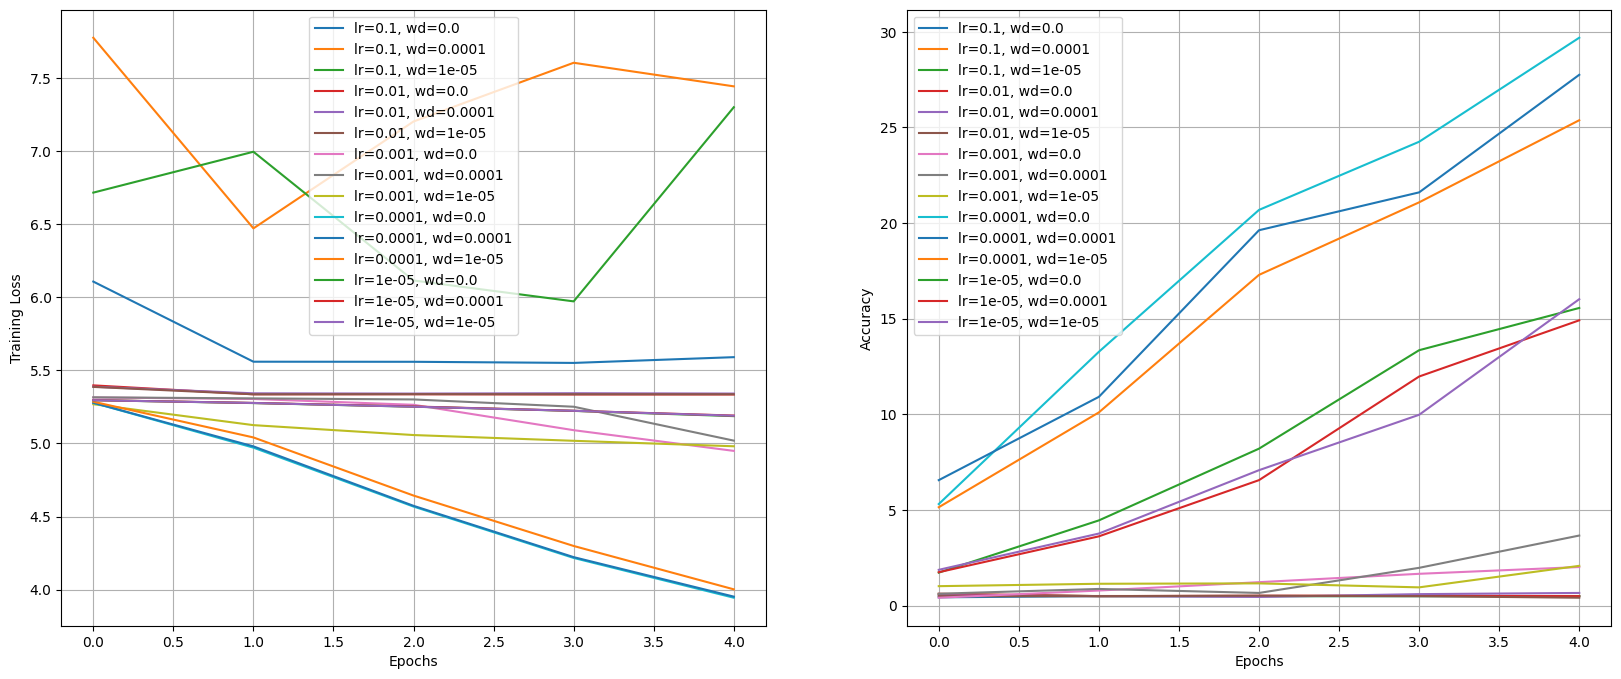

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
for i in range(len(lr_rates)):
    for j in range(len(weight_decay)):
        ax[0].plot(range(len(adam_lr_wd_loss[i * len(weight_decay) + j])), 
                   adam_lr_wd_loss[i * len(weight_decay) + j], 
                   label=f"lr={lr_rates[i]}, 
                   wd={weight_decay[j]}")
        
        ax[1].plot(range(len(adam_lr_wd_accuracy[i * len(weight_decay) + j])), 
                   adam_lr_wd_accuracy[i * len(weight_decay) + j], 
                   label=f"lr={lr_rates[i]}, 
                   wd={weight_decay[j]}")

for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('Epochs')
    ax[i].legend()

ax[0].set_ylabel('Training Loss')
ax[1].set_ylabel('Accuracy')
plt.show()

## Refine grid, train longer

Pick best models from coarse grid, train them for longer (~10-20 epochs) without learning decay.

Check for
- Loss curves bad initialization:
    - if there is a plateau at the initial stage of the curve.
    - if there is a plateau at the end of the curve (implying the need for learning decay).
- Train and Validation accuracy curves:
    - Overfitting
    - Underfitting

In [44]:
adam_wd_loss, adam_wd_accuracy = [], []
weight_decay = np.array([0, 1e-4, 1e-5])

lr=1e-4
for wd in weight_decay:
    print(f"lr={lr}, wd={wd}")
    checkModel = copy.deepcopy(NewModel)
    checkModel.to(device)

    optimizer = optim.Adam(params=checkModel.parameters(), lr=lr, weight_decay=wd)

    torch.cuda.empty_cache()
    gc.collect()

    training_loss, training_accuracy = overfit_model(checkModel, TrainLoader, 
                                                        optimizer, criterion, num_epochs=20)

    adam_wd_loss.append(training_loss)
    adam_wd_accuracy.append(training_accuracy)
    print()

lr=0.0001, wd=0.0


100%|██████████| 2400/2400 [00:29<00:00, 82.74it/s] 


Epoch [1/20], Loss: 5.2292


100%|██████████| 2400/2400 [00:22<00:00, 106.77it/s]


Accuracy of the network on the 2400 train images: 5.75


100%|██████████| 2400/2400 [00:26<00:00, 89.79it/s] 


Epoch [2/20], Loss: 4.9836


100%|██████████| 2400/2400 [00:21<00:00, 113.81it/s]


Accuracy of the network on the 2400 train images: 11.8125


100%|██████████| 2400/2400 [00:27<00:00, 87.91it/s] 


Epoch [3/20], Loss: 4.3873


100%|██████████| 2400/2400 [00:20<00:00, 115.38it/s]


Accuracy of the network on the 2400 train images: 18.5


100%|██████████| 2400/2400 [00:26<00:00, 90.41it/s] 


Epoch [4/20], Loss: 3.5456


100%|██████████| 2400/2400 [00:21<00:00, 113.24it/s]


Accuracy of the network on the 2400 train images: 19.708333333333332


100%|██████████| 2400/2400 [00:27<00:00, 88.02it/s] 


Epoch [5/20], Loss: 3.3890


100%|██████████| 2400/2400 [00:22<00:00, 105.12it/s]


Accuracy of the network on the 2400 train images: 30.291666666666668


100%|██████████| 2400/2400 [00:32<00:00, 74.70it/s] 


Epoch [6/20], Loss: 4.8680


100%|██████████| 2400/2400 [00:21<00:00, 109.84it/s]


Accuracy of the network on the 2400 train images: 30.125


100%|██████████| 2400/2400 [00:47<00:00, 50.38it/s] 


Epoch [7/20], Loss: 2.8538


100%|██████████| 2400/2400 [01:56<00:00, 20.59it/s]


Accuracy of the network on the 2400 train images: 37.270833333333336


100%|██████████| 2400/2400 [00:57<00:00, 42.03it/s] 


Epoch [8/20], Loss: 1.6279


100%|██████████| 2400/2400 [00:23<00:00, 100.20it/s]


Accuracy of the network on the 2400 train images: 41.9375


100%|██████████| 2400/2400 [00:33<00:00, 72.03it/s] 


Epoch [9/20], Loss: 2.4570


100%|██████████| 2400/2400 [00:21<00:00, 111.12it/s]


Accuracy of the network on the 2400 train images: 44.270833333333336


100%|██████████| 2400/2400 [00:25<00:00, 92.46it/s] 


Epoch [10/20], Loss: 3.8750


100%|██████████| 2400/2400 [00:19<00:00, 124.78it/s]


Accuracy of the network on the 2400 train images: 49.416666666666664


100%|██████████| 2400/2400 [00:25<00:00, 93.08it/s] 


Epoch [11/20], Loss: 1.6722


100%|██████████| 2400/2400 [00:19<00:00, 121.53it/s]


Accuracy of the network on the 2400 train images: 48.458333333333336


100%|██████████| 2400/2400 [00:37<00:00, 63.73it/s] 


Epoch [12/20], Loss: 3.1614


100%|██████████| 2400/2400 [00:19<00:00, 120.74it/s]


Accuracy of the network on the 2400 train images: 46.520833333333336


100%|██████████| 2400/2400 [00:53<00:00, 44.80it/s] 


Epoch [13/20], Loss: 1.2937


100%|██████████| 2400/2400 [00:19<00:00, 121.55it/s]


Accuracy of the network on the 2400 train images: 53.291666666666664


100%|██████████| 2400/2400 [00:25<00:00, 94.49it/s] 


Epoch [14/20], Loss: 2.5838


100%|██████████| 2400/2400 [00:19<00:00, 124.21it/s]


Accuracy of the network on the 2400 train images: 50.75


100%|██████████| 2400/2400 [01:00<00:00, 39.66it/s] 


Epoch [15/20], Loss: 1.7844


 12%|█▏        | 296/2400 [00:05<00:37, 56.46it/s] 


KeyboardInterrupt: 

Weight Decay: 0


100%|██████████| 2400/2400 [00:28<00:00, 84.80it/s] 


Epoch [1/20], Loss: 5.2043


100%|██████████| 2400/2400 [00:21<00:00, 109.83it/s]


Accuracy of the network on the 2400 train images: 5.666666666666667


100%|██████████| 597/597 [00:11<00:00, 52.53it/s] 


Accuracy of the network on the 597 validation images: 4.690117252931323


100%|██████████| 2400/2400 [00:27<00:00, 88.34it/s] 


Epoch [2/20], Loss: 4.0744


100%|██████████| 2400/2400 [00:38<00:00, 61.64it/s] 


Accuracy of the network on the 2400 train images: 14.916666666666666


100%|██████████| 597/597 [00:26<00:00, 22.58it/s] 


Accuracy of the network on the 597 validation images: 11.725293132328309


100%|██████████| 2400/2400 [00:30<00:00, 79.06it/s] 


Epoch [3/20], Loss: 4.8151


100%|██████████| 2400/2400 [00:28<00:00, 83.60it/s] 


Accuracy of the network on the 2400 train images: 17.875


100%|██████████| 597/597 [00:33<00:00, 18.05it/s] 


Accuracy of the network on the 597 validation images: 13.484087102177554


100%|██████████| 2400/2400 [02:12<00:00, 18.07it/s]


Epoch [4/20], Loss: 3.6455


100%|██████████| 2400/2400 [00:20<00:00, 115.16it/s]


Accuracy of the network on the 2400 train images: 22.9375


100%|██████████| 597/597 [00:06<00:00, 87.56it/s] 


Accuracy of the network on the 597 validation images: 17.169179229480736


100%|██████████| 2400/2400 [00:45<00:00, 52.67it/s] 


Epoch [5/20], Loss: 3.3500


100%|██████████| 2400/2400 [00:41<00:00, 57.26it/s] 


Accuracy of the network on the 2400 train images: 28.770833333333332


100%|██████████| 597/597 [00:06<00:00, 85.72it/s] 


Accuracy of the network on the 597 validation images: 22.19430485762144


100%|██████████| 2400/2400 [00:54<00:00, 44.42it/s] 


Epoch [6/20], Loss: 3.2184


100%|██████████| 2400/2400 [00:45<00:00, 52.50it/s] 


Accuracy of the network on the 2400 train images: 36.0


100%|██████████| 597/597 [00:47<00:00, 12.61it/s]


Accuracy of the network on the 597 validation images: 28.8107202680067


100%|██████████| 2400/2400 [01:18<00:00, 30.41it/s] 


Epoch [7/20], Loss: 3.8738


100%|██████████| 2400/2400 [00:34<00:00, 69.82it/s] 


Accuracy of the network on the 2400 train images: 36.25


100%|██████████| 597/597 [00:07<00:00, 78.53it/s] 


Accuracy of the network on the 597 validation images: 26.96817420435511


100%|██████████| 2400/2400 [00:26<00:00, 91.81it/s] 


Epoch [8/20], Loss: 2.6606


100%|██████████| 2400/2400 [00:21<00:00, 113.27it/s]


Accuracy of the network on the 2400 train images: 38.645833333333336


100%|██████████| 597/597 [00:07<00:00, 77.44it/s] 


Accuracy of the network on the 597 validation images: 29.396984924623116


100%|██████████| 2400/2400 [01:15<00:00, 31.76it/s]


Epoch [9/20], Loss: 3.4157


100%|██████████| 2400/2400 [00:45<00:00, 53.02it/s] 


Accuracy of the network on the 2400 train images: 40.895833333333336


100%|██████████| 597/597 [00:07<00:00, 77.00it/s] 


Accuracy of the network on the 597 validation images: 31.825795644891123


100%|██████████| 2400/2400 [01:08<00:00, 35.24it/s] 


Epoch [10/20], Loss: 3.2524


100%|██████████| 2400/2400 [00:29<00:00, 80.61it/s] 


Accuracy of the network on the 2400 train images: 42.145833333333336


100%|██████████| 597/597 [00:23<00:00, 25.62it/s] 


Accuracy of the network on the 597 validation images: 33.24958123953099


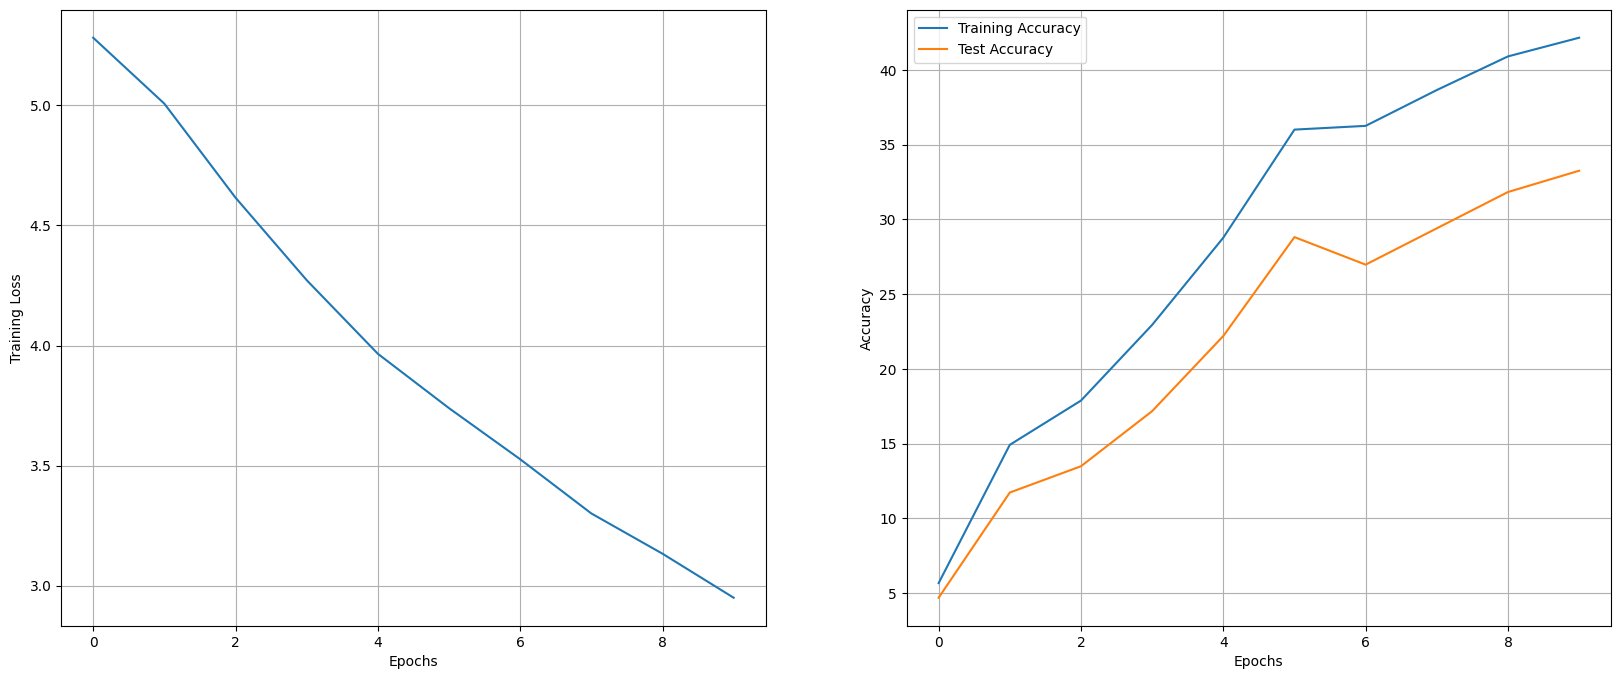

100%|██████████| 2400/2400 [00:55<00:00, 43.29it/s] 


Epoch [11/20], Loss: 2.2242


100%|██████████| 2400/2400 [00:54<00:00, 43.75it/s] 


Accuracy of the network on the 2400 train images: 48.1875


100%|██████████| 597/597 [00:08<00:00, 69.42it/s] 


Accuracy of the network on the 597 validation images: 37.185929648241206


100%|██████████| 2400/2400 [00:58<00:00, 41.27it/s]


Epoch [12/20], Loss: 1.8003


100%|██████████| 2400/2400 [00:30<00:00, 77.81it/s] 


Accuracy of the network on the 2400 train images: 48.0


100%|██████████| 597/597 [00:07<00:00, 80.46it/s] 


Accuracy of the network on the 597 validation images: 36.59966499162479


100%|██████████| 2400/2400 [00:30<00:00, 79.03it/s]


Epoch [13/20], Loss: 3.4424


100%|██████████| 2400/2400 [00:39<00:00, 60.91it/s] 


Accuracy of the network on the 2400 train images: 53.75


100%|██████████| 597/597 [00:28<00:00, 20.90it/s] 


Accuracy of the network on the 597 validation images: 41.87604690117253


100%|██████████| 2400/2400 [01:08<00:00, 35.24it/s]


Epoch [14/20], Loss: 2.4403


100%|██████████| 2400/2400 [00:26<00:00, 90.27it/s] 


Accuracy of the network on the 2400 train images: 50.458333333333336


100%|██████████| 597/597 [00:13<00:00, 45.81it/s] 


Accuracy of the network on the 597 validation images: 37.26968174204355


100%|██████████| 2400/2400 [00:38<00:00, 62.92it/s] 


Epoch [15/20], Loss: 3.8388


100%|██████████| 2400/2400 [00:40<00:00, 59.37it/s] 


Accuracy of the network on the 2400 train images: 55.208333333333336


100%|██████████| 597/597 [00:07<00:00, 79.09it/s] 


Accuracy of the network on the 597 validation images: 40.36850921273032


100%|██████████| 2400/2400 [00:30<00:00, 78.31it/s] 


Epoch [16/20], Loss: 1.0689


100%|██████████| 2400/2400 [00:22<00:00, 105.80it/s]


Accuracy of the network on the 2400 train images: 58.270833333333336


100%|██████████| 597/597 [00:07<00:00, 84.26it/s] 


Accuracy of the network on the 597 validation images: 43.63484087102177


100%|██████████| 2400/2400 [00:28<00:00, 84.73it/s] 


Epoch [17/20], Loss: 3.4051


100%|██████████| 2400/2400 [00:22<00:00, 107.38it/s]


Accuracy of the network on the 2400 train images: 57.083333333333336


100%|██████████| 597/597 [00:10<00:00, 56.25it/s] 


Accuracy of the network on the 597 validation images: 43.38358458961474


100%|██████████| 2400/2400 [00:43<00:00, 55.38it/s]


Epoch [18/20], Loss: 2.7331


100%|██████████| 2400/2400 [00:24<00:00, 98.47it/s] 


Accuracy of the network on the 2400 train images: 61.833333333333336


100%|██████████| 597/597 [00:08<00:00, 74.21it/s] 


Accuracy of the network on the 597 validation images: 43.71859296482412


100%|██████████| 2400/2400 [00:28<00:00, 84.98it/s] 


Epoch [19/20], Loss: 0.4930


100%|██████████| 2400/2400 [00:22<00:00, 108.78it/s]


Accuracy of the network on the 2400 train images: 61.520833333333336


100%|██████████| 597/597 [00:07<00:00, 80.93it/s] 


Accuracy of the network on the 597 validation images: 44.97487437185929


100%|██████████| 2400/2400 [00:28<00:00, 83.14it/s]


Epoch [20/20], Loss: 1.1978


100%|██████████| 2400/2400 [00:20<00:00, 115.49it/s]


Accuracy of the network on the 2400 train images: 59.833333333333336


100%|██████████| 597/597 [00:07<00:00, 85.17it/s] 


Accuracy of the network on the 597 validation images: 44.221105527638194


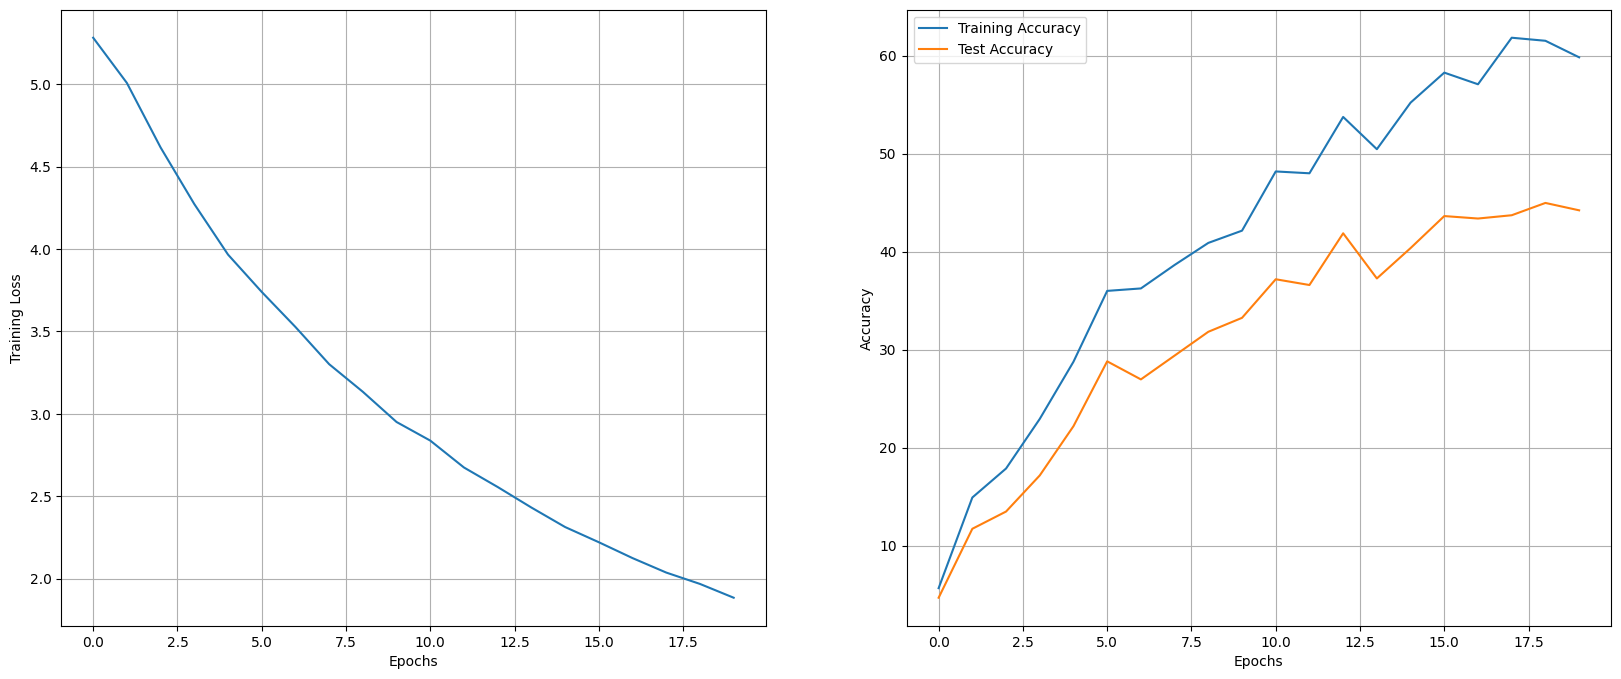

100%|██████████| 2897/2897 [01:23<00:00, 34.62it/s] 


Accuracy of the network on the 2897 test images: 42.57852951328961

Weight Decay: 0.0001


100%|██████████| 2400/2400 [00:44<00:00, 53.57it/s]


Epoch [1/20], Loss: 5.3096


100%|██████████| 2400/2400 [00:24<00:00, 99.16it/s] 


Accuracy of the network on the 2400 train images: 6.041666666666667


100%|██████████| 597/597 [00:07<00:00, 80.04it/s] 


Accuracy of the network on the 597 validation images: 5.108877721943049


100%|██████████| 2400/2400 [00:29<00:00, 81.45it/s]


Epoch [2/20], Loss: 4.5615


100%|██████████| 2400/2400 [00:21<00:00, 113.72it/s]


Accuracy of the network on the 2400 train images: 11.5


100%|██████████| 597/597 [00:07<00:00, 77.55it/s] 


Accuracy of the network on the 597 validation images: 9.045226130653266


100%|██████████| 2400/2400 [00:29<00:00, 81.15it/s]


Epoch [3/20], Loss: 4.1563


100%|██████████| 2400/2400 [00:22<00:00, 106.37it/s]


Accuracy of the network on the 2400 train images: 16.875


100%|██████████| 597/597 [00:07<00:00, 78.84it/s] 


Accuracy of the network on the 597 validation images: 12.814070351758794


100%|██████████| 2400/2400 [00:51<00:00, 46.96it/s]


Epoch [4/20], Loss: 6.0970


100%|██████████| 2400/2400 [00:31<00:00, 77.26it/s] 


Accuracy of the network on the 2400 train images: 21.625


100%|██████████| 597/597 [00:07<00:00, 77.77it/s] 


Accuracy of the network on the 597 validation images: 16.834170854271356


100%|██████████| 2400/2400 [00:31<00:00, 77.13it/s]


Epoch [5/20], Loss: 2.6633


100%|██████████| 2400/2400 [00:38<00:00, 62.18it/s] 


Accuracy of the network on the 2400 train images: 28.166666666666668


100%|██████████| 597/597 [00:09<00:00, 62.06it/s] 


Accuracy of the network on the 597 validation images: 21.775544388609717


100%|██████████| 2400/2400 [00:29<00:00, 81.75it/s]


Epoch [6/20], Loss: 4.1601


100%|██████████| 2400/2400 [00:24<00:00, 96.32it/s] 


Accuracy of the network on the 2400 train images: 29.979166666666668


100%|██████████| 597/597 [00:13<00:00, 43.76it/s] 


Accuracy of the network on the 597 validation images: 23.701842546063652


100%|██████████| 2400/2400 [00:40<00:00, 58.85it/s]


Epoch [7/20], Loss: 2.5901


100%|██████████| 2400/2400 [00:23<00:00, 103.98it/s]


Accuracy of the network on the 2400 train images: 37.520833333333336


100%|██████████| 597/597 [00:07<00:00, 76.19it/s] 


Accuracy of the network on the 597 validation images: 28.726968174204355


100%|██████████| 2400/2400 [00:45<00:00, 52.77it/s]


Epoch [8/20], Loss: 4.5466


100%|██████████| 2400/2400 [00:26<00:00, 90.00it/s] 


Accuracy of the network on the 2400 train images: 37.916666666666664


100%|██████████| 597/597 [00:07<00:00, 74.66it/s] 


Accuracy of the network on the 597 validation images: 28.47571189279732


100%|██████████| 2400/2400 [00:29<00:00, 81.81it/s]


Epoch [9/20], Loss: 2.4516


100%|██████████| 2400/2400 [00:22<00:00, 105.34it/s]


Accuracy of the network on the 2400 train images: 44.625


100%|██████████| 597/597 [00:07<00:00, 80.24it/s] 


Accuracy of the network on the 597 validation images: 34.58961474036851


100%|██████████| 2400/2400 [00:30<00:00, 79.76it/s] 


Epoch [10/20], Loss: 2.5248


100%|██████████| 2400/2400 [00:48<00:00, 49.34it/s] 


Accuracy of the network on the 2400 train images: 43.25


100%|██████████| 597/597 [00:09<00:00, 62.76it/s] 


Accuracy of the network on the 597 validation images: 33.333333333333336


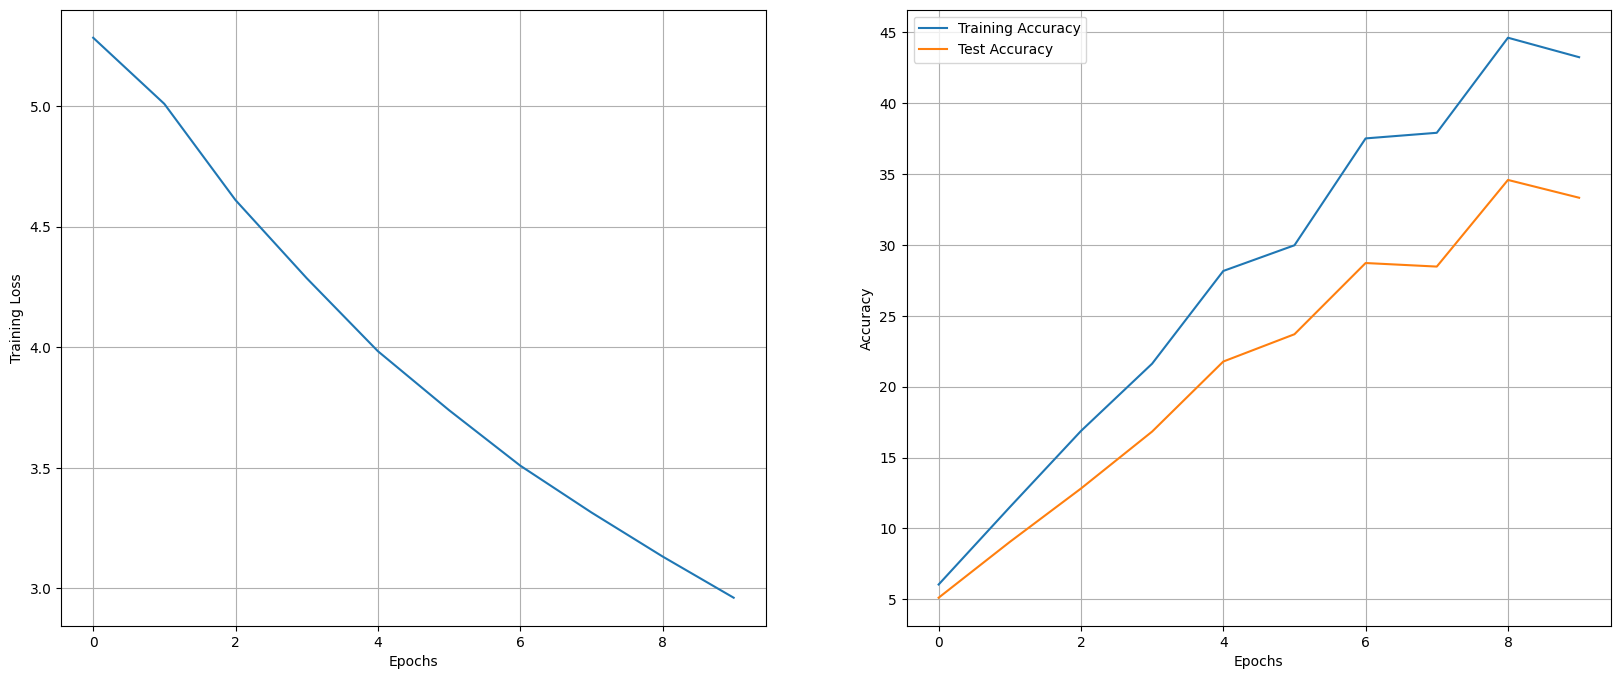

100%|██████████| 2400/2400 [00:30<00:00, 78.78it/s]


Epoch [11/20], Loss: 2.6772


100%|██████████| 2400/2400 [00:23<00:00, 103.50it/s]


Accuracy of the network on the 2400 train images: 48.354166666666664


100%|██████████| 597/597 [00:07<00:00, 78.03it/s] 


Accuracy of the network on the 597 validation images: 36.515912897822446


100%|██████████| 2400/2400 [00:46<00:00, 51.91it/s]


Epoch [12/20], Loss: 2.3375


100%|██████████| 2400/2400 [00:30<00:00, 78.81it/s] 


Accuracy of the network on the 2400 train images: 46.854166666666664


100%|██████████| 597/597 [00:37<00:00, 16.06it/s]


Accuracy of the network on the 597 validation images: 36.09715242881072


100%|██████████| 2400/2400 [00:43<00:00, 55.29it/s]


Epoch [13/20], Loss: 3.8523


100%|██████████| 2400/2400 [00:40<00:00, 58.80it/s] 


Accuracy of the network on the 2400 train images: 50.291666666666664


100%|██████████| 597/597 [00:20<00:00, 28.55it/s] 


Accuracy of the network on the 597 validation images: 36.85092127303182


100%|██████████| 2400/2400 [00:34<00:00, 69.59it/s]


Epoch [14/20], Loss: 2.4378


100%|██████████| 2400/2400 [00:29<00:00, 81.29it/s] 


Accuracy of the network on the 2400 train images: 52.916666666666664


100%|██████████| 597/597 [00:21<00:00, 27.82it/s]


Accuracy of the network on the 597 validation images: 38.94472361809045


100%|██████████| 2400/2400 [00:43<00:00, 55.05it/s]


Epoch [15/20], Loss: 1.0505


100%|██████████| 2400/2400 [00:25<00:00, 92.87it/s] 


Accuracy of the network on the 2400 train images: 54.020833333333336


100%|██████████| 597/597 [00:09<00:00, 61.54it/s] 


Accuracy of the network on the 597 validation images: 39.7822445561139


100%|██████████| 2400/2400 [00:38<00:00, 62.27it/s]


Epoch [16/20], Loss: 1.6526


100%|██████████| 2400/2400 [00:23<00:00, 101.38it/s]


Accuracy of the network on the 2400 train images: 53.3125


100%|██████████| 597/597 [00:08<00:00, 70.49it/s] 


Accuracy of the network on the 597 validation images: 40.117252931323286


100%|██████████| 2400/2400 [00:30<00:00, 77.54it/s] 


Epoch [17/20], Loss: 1.7309


100%|██████████| 2400/2400 [00:27<00:00, 87.99it/s] 


Accuracy of the network on the 2400 train images: 52.8125


100%|██████████| 597/597 [00:16<00:00, 36.83it/s] 


Accuracy of the network on the 597 validation images: 40.36850921273032


100%|██████████| 2400/2400 [00:36<00:00, 65.03it/s] 


Epoch [18/20], Loss: 1.6304


100%|██████████| 2400/2400 [00:24<00:00, 99.93it/s] 


Accuracy of the network on the 2400 train images: 58.333333333333336


100%|██████████| 597/597 [00:07<00:00, 80.13it/s] 


Accuracy of the network on the 597 validation images: 42.79731993299833


100%|██████████| 2400/2400 [00:31<00:00, 75.59it/s]


Epoch [19/20], Loss: 1.0123


100%|██████████| 2400/2400 [00:30<00:00, 79.13it/s] 


Accuracy of the network on the 2400 train images: 60.520833333333336


100%|██████████| 597/597 [00:09<00:00, 61.11it/s] 


Accuracy of the network on the 597 validation images: 42.96482412060301


100%|██████████| 2400/2400 [00:44<00:00, 53.78it/s]


Epoch [20/20], Loss: 2.1038


100%|██████████| 2400/2400 [00:27<00:00, 86.69it/s] 


Accuracy of the network on the 2400 train images: 60.416666666666664


100%|██████████| 597/597 [00:14<00:00, 41.53it/s] 


Accuracy of the network on the 597 validation images: 44.97487437185929


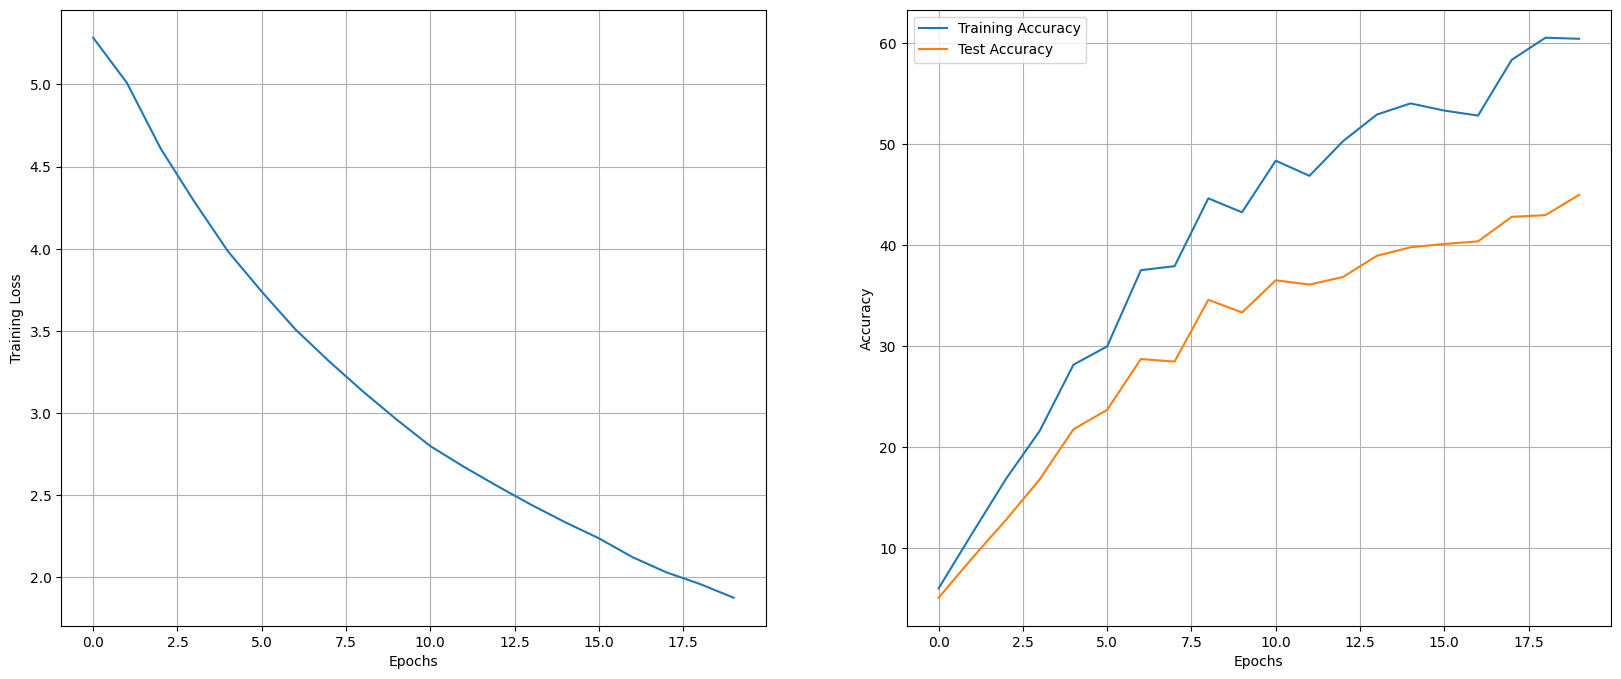

100%|██████████| 2897/2897 [00:29<00:00, 97.00it/s] 


Accuracy of the network on the 2897 test images: 42.90645495340007

Weight Decay: 1e-05


100%|██████████| 2400/2400 [00:39<00:00, 60.38it/s]


Epoch [1/20], Loss: 5.0311


100%|██████████| 2400/2400 [00:21<00:00, 113.04it/s]


Accuracy of the network on the 2400 train images: 4.333333333333333


100%|██████████| 597/597 [00:07<00:00, 82.44it/s] 


Accuracy of the network on the 597 validation images: 3.3500837520938025


100%|██████████| 2400/2400 [00:32<00:00, 73.67it/s] 


Epoch [2/20], Loss: 5.0093


100%|██████████| 2400/2400 [00:29<00:00, 80.24it/s] 


Accuracy of the network on the 2400 train images: 12.020833333333334


100%|██████████| 597/597 [00:08<00:00, 68.40it/s] 


Accuracy of the network on the 597 validation images: 9.128978224455611


100%|██████████| 2400/2400 [00:29<00:00, 82.65it/s] 


Epoch [3/20], Loss: 3.7242


100%|██████████| 2400/2400 [00:20<00:00, 118.32it/s]


Accuracy of the network on the 2400 train images: 17.979166666666668


100%|██████████| 597/597 [00:07<00:00, 81.88it/s] 


Accuracy of the network on the 597 validation images: 14.07035175879397


100%|██████████| 2400/2400 [00:42<00:00, 56.12it/s] 


Epoch [4/20], Loss: 5.3575


100%|██████████| 2400/2400 [00:25<00:00, 94.51it/s] 


Accuracy of the network on the 2400 train images: 22.416666666666668


100%|██████████| 597/597 [00:09<00:00, 63.11it/s] 


Accuracy of the network on the 597 validation images: 18.09045226130653


100%|██████████| 2400/2400 [00:28<00:00, 83.14it/s] 


Epoch [5/20], Loss: 4.6999


100%|██████████| 2400/2400 [00:21<00:00, 113.61it/s]


Accuracy of the network on the 2400 train images: 28.354166666666668


100%|██████████| 597/597 [00:06<00:00, 91.43it/s] 


Accuracy of the network on the 597 validation images: 22.36180904522613


100%|██████████| 2400/2400 [00:26<00:00, 90.53it/s] 


Epoch [6/20], Loss: 4.1174


100%|██████████| 2400/2400 [00:20<00:00, 114.39it/s]


Accuracy of the network on the 2400 train images: 31.729166666666668


100%|██████████| 597/597 [00:07<00:00, 80.54it/s] 


Accuracy of the network on the 597 validation images: 23.785594639865998


100%|██████████| 2400/2400 [00:26<00:00, 89.35it/s] 


Epoch [7/20], Loss: 3.4739


100%|██████████| 2400/2400 [00:23<00:00, 104.10it/s]


Accuracy of the network on the 2400 train images: 33.854166666666664


100%|██████████| 597/597 [00:07<00:00, 82.22it/s] 


Accuracy of the network on the 597 validation images: 26.298157453936348


100%|██████████| 2400/2400 [00:31<00:00, 75.28it/s] 


Epoch [8/20], Loss: 2.9367


100%|██████████| 2400/2400 [00:20<00:00, 116.19it/s]


Accuracy of the network on the 2400 train images: 35.833333333333336


100%|██████████| 597/597 [00:06<00:00, 89.28it/s] 


Accuracy of the network on the 597 validation images: 26.298157453936348


100%|██████████| 2400/2400 [00:26<00:00, 89.07it/s] 


Epoch [9/20], Loss: 2.0281


100%|██████████| 2400/2400 [00:19<00:00, 124.77it/s]


Accuracy of the network on the 2400 train images: 43.479166666666664


100%|██████████| 597/597 [00:06<00:00, 89.23it/s] 


Accuracy of the network on the 597 validation images: 31.742043551088777


100%|██████████| 2400/2400 [00:25<00:00, 93.61it/s] 


Epoch [10/20], Loss: 4.4007


100%|██████████| 2400/2400 [00:19<00:00, 125.34it/s]


Accuracy of the network on the 2400 train images: 44.791666666666664


100%|██████████| 597/597 [00:06<00:00, 90.05it/s] 


Accuracy of the network on the 597 validation images: 33.75209380234506


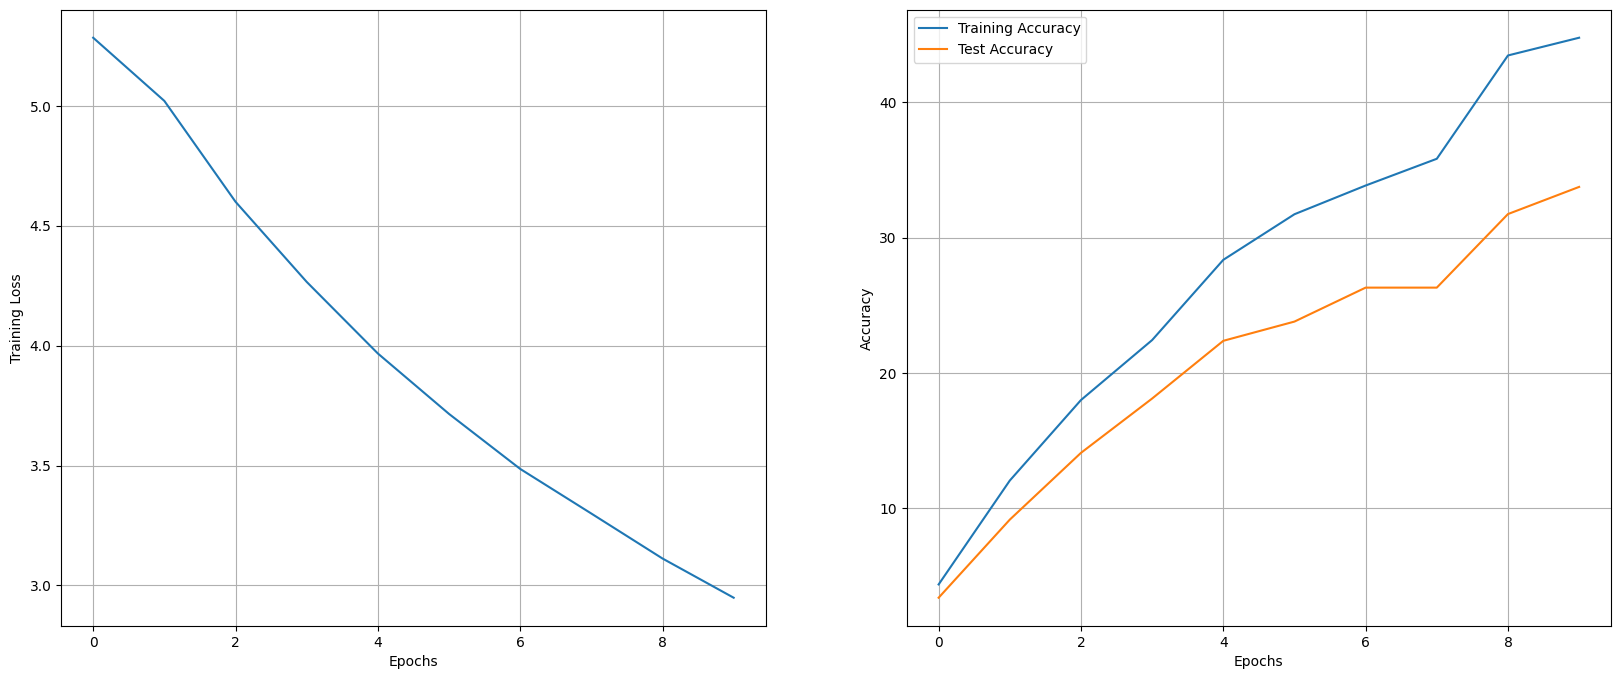

100%|██████████| 2400/2400 [00:28<00:00, 84.93it/s] 


Epoch [11/20], Loss: 2.4578


100%|██████████| 2400/2400 [00:22<00:00, 106.85it/s]


Accuracy of the network on the 2400 train images: 49.770833333333336


100%|██████████| 597/597 [00:11<00:00, 54.10it/s] 


Accuracy of the network on the 597 validation images: 37.10217755443886


100%|██████████| 2400/2400 [00:32<00:00, 73.80it/s] 


Epoch [12/20], Loss: 3.5672


100%|██████████| 2400/2400 [00:23<00:00, 103.80it/s]


Accuracy of the network on the 2400 train images: 48.0


100%|██████████| 597/597 [00:07<00:00, 80.14it/s] 


Accuracy of the network on the 597 validation images: 34.003350083752096


100%|██████████| 2400/2400 [00:30<00:00, 79.93it/s]


Epoch [13/20], Loss: 1.5679


100%|██████████| 2400/2400 [00:22<00:00, 105.83it/s]


Accuracy of the network on the 2400 train images: 53.125


100%|██████████| 597/597 [00:08<00:00, 70.04it/s] 


Accuracy of the network on the 597 validation images: 38.27470686767169


100%|██████████| 2400/2400 [00:38<00:00, 62.45it/s]


Epoch [14/20], Loss: 0.6587


100%|██████████| 2400/2400 [00:22<00:00, 108.26it/s]


Accuracy of the network on the 2400 train images: 57.541666666666664


100%|██████████| 597/597 [00:09<00:00, 61.78it/s] 


Accuracy of the network on the 597 validation images: 41.12227805695142


100%|██████████| 2400/2400 [00:36<00:00, 65.73it/s]


Epoch [15/20], Loss: 5.4809


100%|██████████| 2400/2400 [00:28<00:00, 83.27it/s] 


Accuracy of the network on the 2400 train images: 53.416666666666664


100%|██████████| 597/597 [00:07<00:00, 75.33it/s] 


Accuracy of the network on the 597 validation images: 39.028475711892796


100%|██████████| 2400/2400 [00:39<00:00, 61.19it/s] 


Epoch [16/20], Loss: 2.5321


100%|██████████| 2400/2400 [00:21<00:00, 113.24it/s]


Accuracy of the network on the 2400 train images: 57.833333333333336


100%|██████████| 597/597 [00:07<00:00, 81.46it/s] 


Accuracy of the network on the 597 validation images: 42.54606365159129


100%|██████████| 2400/2400 [00:29<00:00, 82.69it/s]


Epoch [17/20], Loss: 2.3684


100%|██████████| 2400/2400 [00:20<00:00, 114.31it/s]


Accuracy of the network on the 2400 train images: 56.25


100%|██████████| 597/597 [00:07<00:00, 78.32it/s] 


Accuracy of the network on the 597 validation images: 39.949748743718594


100%|██████████| 2400/2400 [00:29<00:00, 81.07it/s]


Epoch [18/20], Loss: 1.4888


100%|██████████| 2400/2400 [00:35<00:00, 67.39it/s] 


Accuracy of the network on the 2400 train images: 60.875


100%|██████████| 597/597 [00:08<00:00, 73.40it/s] 


Accuracy of the network on the 597 validation images: 44.0536013400335


100%|██████████| 2400/2400 [00:29<00:00, 81.99it/s]


Epoch [19/20], Loss: 1.9993


100%|██████████| 2400/2400 [00:27<00:00, 85.98it/s] 


Accuracy of the network on the 2400 train images: 60.541666666666664


100%|██████████| 597/597 [00:16<00:00, 35.71it/s] 


Accuracy of the network on the 597 validation images: 42.88107202680067


100%|██████████| 2400/2400 [00:40<00:00, 59.52it/s] 


Epoch [20/20], Loss: 1.6904


100%|██████████| 2400/2400 [00:20<00:00, 115.29it/s]


Accuracy of the network on the 2400 train images: 61.479166666666664


100%|██████████| 597/597 [00:06<00:00, 86.86it/s] 


Accuracy of the network on the 597 validation images: 43.63484087102177


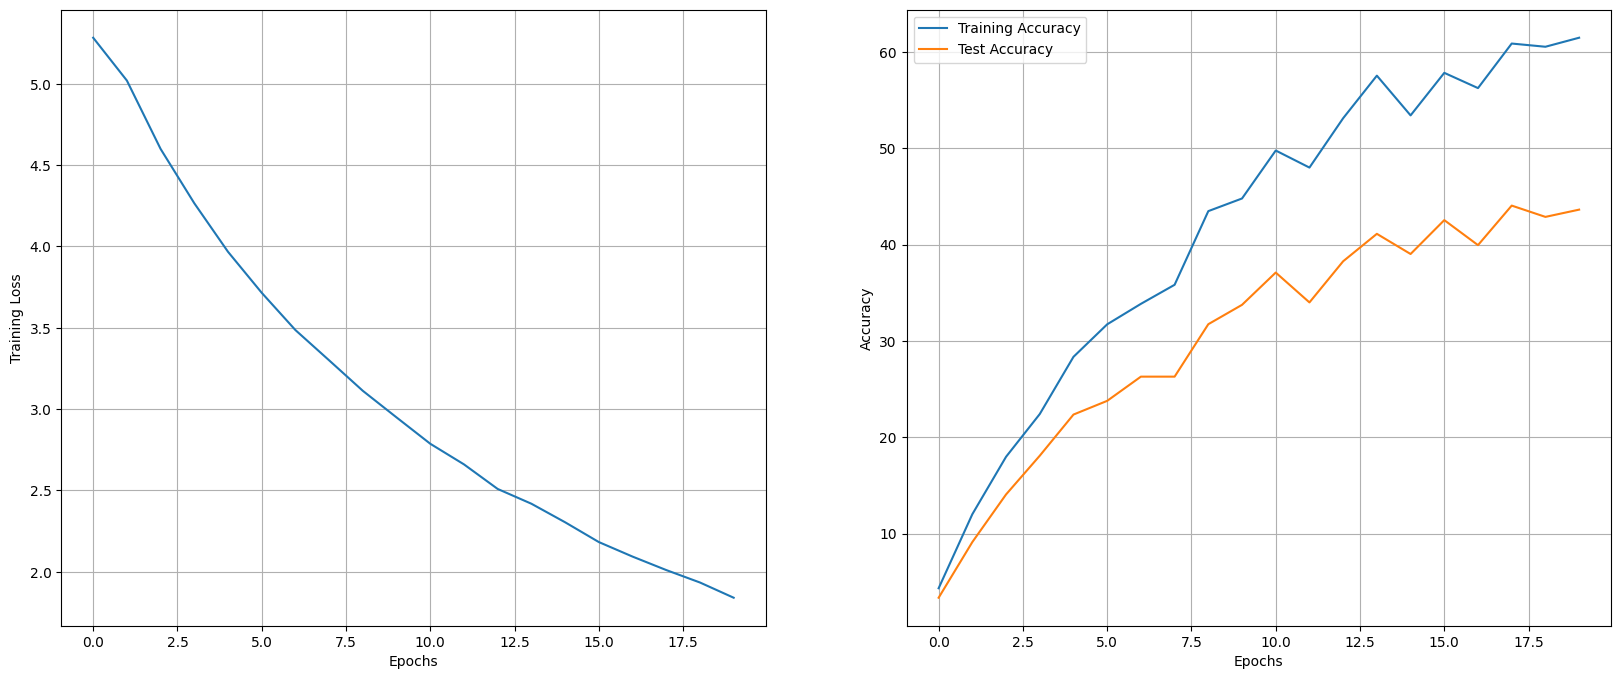

100%|██████████| 2897/2897 [00:21<00:00, 131.69it/s]

Accuracy of the network on the 2897 test images: 43.82119433897135



In [46]:
adam_wd_loss, adam_wd_training_accuracy, adam_w_validation_accuracy = [], [], []
weight_decay = [0, 1e-4, 1e-5]

for wd in weight_decay:
    checkModel = copy.deepcopy(NewModel)
    checkModel.to(device)
    
    torch.cuda.empty_cache()
    gc.collect()
    
    training_accuracy = []
    training_loss = []
    validation_accuracy = []
    
    # Number of epochs
    num_epochs = 20

    optimizer = optim.Adam(params=checkModel.parameters(), lr=1e-4, weight_decay=wd)

    print('Weight Decay:', wd)
    for epoch in range(num_epochs):
        checkModel.train()

        running_loss = 0    
        for input_data, labels in tqdm.tqdm(TrainLoader, total=len(TrainLoader)):
            # Forward pass
            labels, input_data = labels.to(device), input_data.to(device)
            output = checkModel(input_data)
            
            # Compute loss
            loss = criterion(output, labels.long())
            running_loss += loss.item()
            # Backward pass
            optimizer.zero_grad()  # Zero the gradients
            loss.backward()  # Compute gradients
            optimizer.step()  # Update weights
        # scheduler.step(running_loss)  # Update learning rate
            
        # Print training progress
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        training_loss.append(running_loss / len(TrainLoader))

        training_accuracy.append(calculate_accuracy(checkModel, TrainLoader, data_type='train'))
        validation_accuracy.append(calculate_accuracy(checkModel, ValidationLoader, data_type='validation'))
        

        if (epoch + 1) % 10 == 0:
            fig, ax = plt.subplots(1, 2, figsize=(20, 8))
            ax[0].plot(range(len(training_loss)), training_loss)
            ax[1].plot(range(len(training_accuracy)), training_accuracy, label='Training Accuracy')
            ax[1].plot(range(len(validation_accuracy)), validation_accuracy, label='Test Accuracy')
            ax[1].grid()
            ax[0].grid()
            ax[0].set_xlabel('Epochs')
            ax[0].set_ylabel('Training Loss')
            ax[1].set_xlabel('Epochs')
            ax[1].set_ylabel('Accuracy')
            ax[1].legend()
            plt.show()
    adam_wd_loss.append(training_loss)
    adam_wd_training_accuracy.append(training_accuracy)
    adam_w_validation_accuracy.append(validation_accuracy)

    calculate_accuracy(checkModel, TestLoader, data_type='test')
    print()

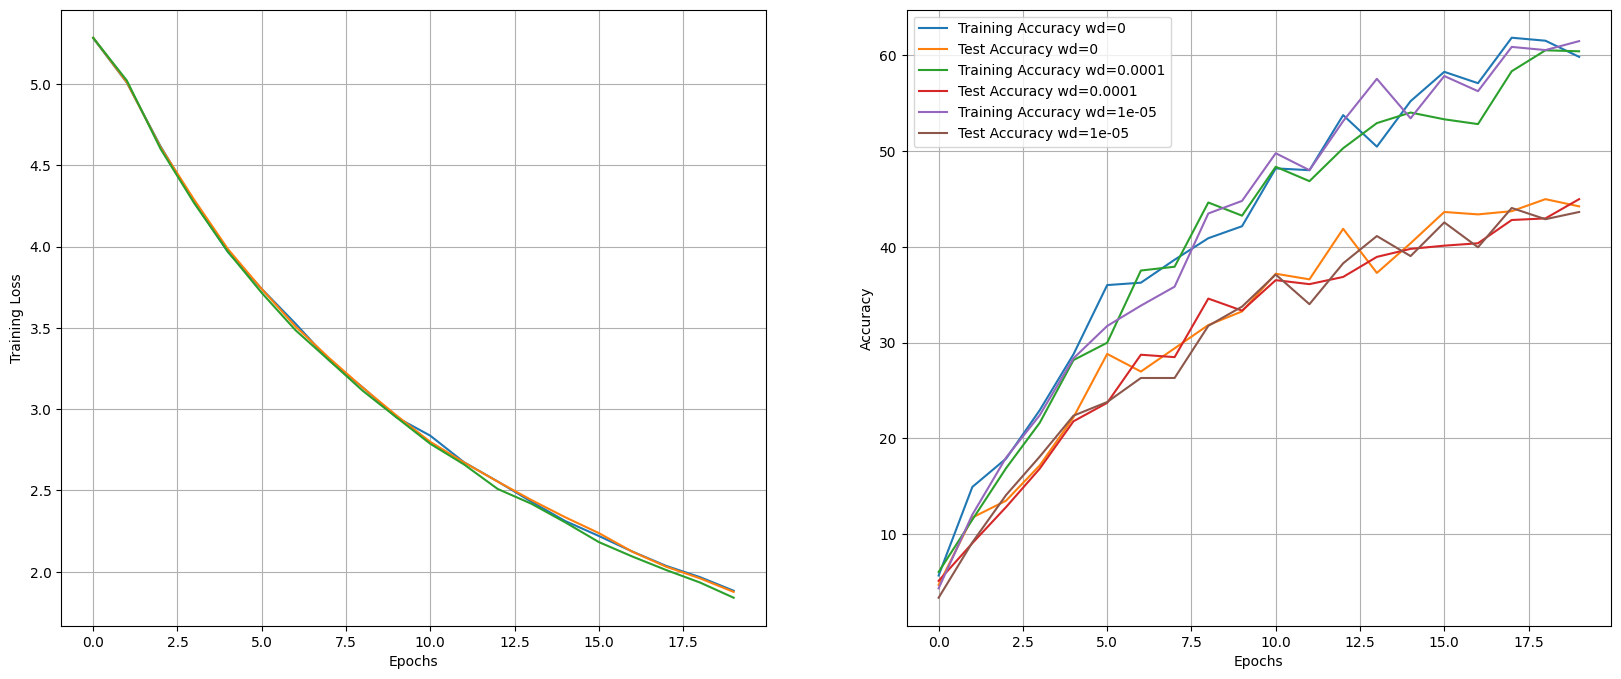

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
# adam_wd_loss, adam_wd_training_accuracy, adam_w_validation_accuracy 
for i in range(len(weight_decay)):
    ax[0].plot(range(len(adam_wd_loss[i])), 
               adam_wd_loss[i], 
               label=f"wd={weight_decay[i]}")
    ax[1].plot(range(len(adam_wd_training_accuracy[i])), 
               adam_wd_training_accuracy[i], 
               label=f'Training Accuracy wd={weight_decay[i]}')
    
    ax[1].plot(range(len(adam_w_validation_accuracy[i])), 
               adam_w_validation_accuracy[i], 
               label=f'Test Accuracy wd={weight_decay[i]}')
    
ax[1].grid()
ax[0].grid()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()

Adam is showing good result irrespective of weight decay. So, not using weight decay.

# Training
There is a small error while printing loss. I printed final batch's loss after an epoch instead of whole batches' loss.

100%|██████████| 2400/2400 [00:27<00:00, 87.79it/s] 


Epoch [1/50], Loss: 5.2241


100%|██████████| 2400/2400 [00:21<00:00, 109.60it/s]


Accuracy of the network on the 2400 train images: 6.020833333333333


100%|██████████| 597/597 [00:07<00:00, 79.08it/s] 


Accuracy of the network on the 597 validation images: 4.941373534338358


100%|██████████| 2400/2400 [00:28<00:00, 83.03it/s] 


Epoch [2/50], Loss: 5.0207


100%|██████████| 2400/2400 [00:20<00:00, 115.63it/s]


Accuracy of the network on the 2400 train images: 11.854166666666666


100%|██████████| 597/597 [00:07<00:00, 83.30it/s] 


Accuracy of the network on the 597 validation images: 8.961474036850921


100%|██████████| 2400/2400 [00:28<00:00, 82.89it/s] 


Epoch [3/50], Loss: 4.7623


100%|██████████| 2400/2400 [00:20<00:00, 118.24it/s]


Accuracy of the network on the 2400 train images: 15.958333333333334


100%|██████████| 597/597 [00:07<00:00, 83.99it/s] 


Accuracy of the network on the 597 validation images: 12.646566164154104


100%|██████████| 2400/2400 [00:27<00:00, 88.24it/s] 


Epoch [4/50], Loss: 3.6902


100%|██████████| 2400/2400 [00:21<00:00, 110.31it/s]


Accuracy of the network on the 2400 train images: 25.1875


100%|██████████| 597/597 [00:06<00:00, 89.33it/s] 


Accuracy of the network on the 597 validation images: 19.849246231155778


100%|██████████| 2400/2400 [00:27<00:00, 86.69it/s] 


Epoch [5/50], Loss: 3.2752


100%|██████████| 2400/2400 [00:20<00:00, 118.62it/s]


Accuracy of the network on the 2400 train images: 29.833333333333332


100%|██████████| 597/597 [00:07<00:00, 81.57it/s] 


Accuracy of the network on the 597 validation images: 22.278056951423785


100%|██████████| 2400/2400 [00:27<00:00, 88.40it/s] 


Epoch [6/50], Loss: 3.0733


100%|██████████| 2400/2400 [00:21<00:00, 112.74it/s]


Accuracy of the network on the 2400 train images: 31.291666666666668


100%|██████████| 597/597 [00:07<00:00, 84.58it/s] 


Accuracy of the network on the 597 validation images: 24.288107202680067


100%|██████████| 2400/2400 [00:26<00:00, 90.62it/s] 


Epoch [7/50], Loss: 2.8394


100%|██████████| 2400/2400 [00:18<00:00, 127.70it/s]


Accuracy of the network on the 2400 train images: 36.979166666666664


100%|██████████| 597/597 [00:06<00:00, 86.13it/s] 


Accuracy of the network on the 597 validation images: 28.30820770519263


100%|██████████| 2400/2400 [00:25<00:00, 93.96it/s] 


Epoch [8/50], Loss: 4.0985


100%|██████████| 2400/2400 [00:20<00:00, 117.49it/s]


Accuracy of the network on the 2400 train images: 41.354166666666664


100%|██████████| 597/597 [00:06<00:00, 88.05it/s] 


Accuracy of the network on the 597 validation images: 31.742043551088777


100%|██████████| 2400/2400 [00:26<00:00, 89.82it/s] 


Epoch [9/50], Loss: 2.4338


100%|██████████| 2400/2400 [00:18<00:00, 126.72it/s]


Accuracy of the network on the 2400 train images: 45.020833333333336


100%|██████████| 597/597 [00:06<00:00, 85.70it/s] 


Accuracy of the network on the 597 validation images: 33.75209380234506


100%|██████████| 2400/2400 [00:25<00:00, 93.72it/s] 


Epoch [10/50], Loss: 2.6415


100%|██████████| 2400/2400 [00:20<00:00, 117.76it/s]


Accuracy of the network on the 2400 train images: 48.208333333333336


100%|██████████| 597/597 [00:06<00:00, 89.33it/s] 

Accuracy of the network on the 597 validation images: 35.09212730318258


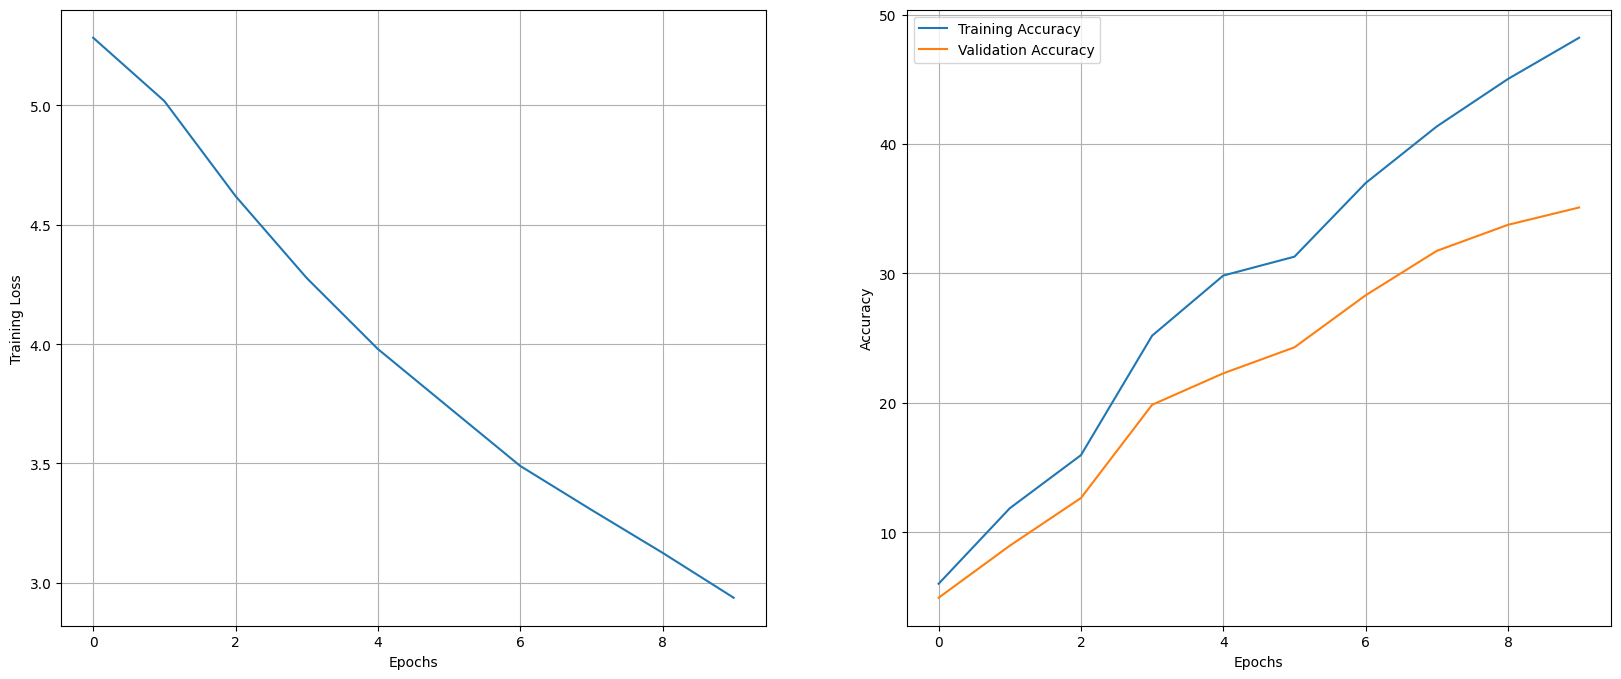

100%|██████████| 2400/2400 [00:26<00:00, 90.66it/s] 


Epoch [11/50], Loss: 2.7939


100%|██████████| 2400/2400 [00:26<00:00, 90.33it/s] 


Accuracy of the network on the 2400 train images: 47.0625


100%|██████████| 597/597 [00:07<00:00, 77.39it/s] 


Accuracy of the network on the 597 validation images: 35.845896147403685


100%|██████████| 2400/2400 [00:26<00:00, 88.90it/s] 


Epoch [12/50], Loss: 1.6294


100%|██████████| 2400/2400 [00:21<00:00, 111.89it/s]


Accuracy of the network on the 2400 train images: 50.916666666666664


100%|██████████| 597/597 [00:06<00:00, 86.73it/s] 


Accuracy of the network on the 597 validation images: 39.028475711892796


100%|██████████| 2400/2400 [00:28<00:00, 82.87it/s] 


Epoch [13/50], Loss: 0.9291


100%|██████████| 2400/2400 [00:19<00:00, 120.78it/s]


Accuracy of the network on the 2400 train images: 46.270833333333336


100%|██████████| 597/597 [00:07<00:00, 84.92it/s] 


Accuracy of the network on the 597 validation images: 33.91959798994975


100%|██████████| 2400/2400 [00:27<00:00, 87.67it/s] 


Epoch [14/50], Loss: 2.6807


100%|██████████| 2400/2400 [00:21<00:00, 113.95it/s]


Accuracy of the network on the 2400 train images: 55.083333333333336


100%|██████████| 597/597 [00:06<00:00, 85.86it/s] 


Accuracy of the network on the 597 validation images: 41.20603015075377


100%|██████████| 2400/2400 [00:28<00:00, 84.08it/s] 


Epoch [15/50], Loss: 2.2441


100%|██████████| 2400/2400 [00:20<00:00, 119.56it/s]


Accuracy of the network on the 2400 train images: 57.125


100%|██████████| 597/597 [00:07<00:00, 82.62it/s] 


Accuracy of the network on the 597 validation images: 42.29480737018425


100%|██████████| 2400/2400 [00:27<00:00, 87.89it/s] 


Epoch [16/50], Loss: 2.9010


100%|██████████| 2400/2400 [00:21<00:00, 112.27it/s]


Accuracy of the network on the 2400 train images: 55.208333333333336


100%|██████████| 597/597 [00:06<00:00, 89.12it/s] 


Accuracy of the network on the 597 validation images: 41.289782244556115


100%|██████████| 2400/2400 [00:29<00:00, 82.65it/s] 


Epoch [17/50], Loss: 1.4391


100%|██████████| 2400/2400 [00:19<00:00, 125.13it/s]


Accuracy of the network on the 2400 train images: 58.645833333333336


100%|██████████| 597/597 [00:07<00:00, 85.10it/s] 


Accuracy of the network on the 597 validation images: 42.12730318257957


100%|██████████| 2400/2400 [00:27<00:00, 87.21it/s] 


Epoch [18/50], Loss: 2.8106


100%|██████████| 2400/2400 [00:19<00:00, 125.86it/s]


Accuracy of the network on the 2400 train images: 58.479166666666664


100%|██████████| 597/597 [00:07<00:00, 83.22it/s] 


Accuracy of the network on the 597 validation images: 41.54103852596315


100%|██████████| 2400/2400 [00:25<00:00, 94.32it/s] 


Epoch [19/50], Loss: 1.1167


100%|██████████| 2400/2400 [00:20<00:00, 117.17it/s]


Accuracy of the network on the 2400 train images: 58.0


100%|██████████| 597/597 [00:06<00:00, 87.56it/s] 


Accuracy of the network on the 597 validation images: 42.54606365159129


100%|██████████| 2400/2400 [00:27<00:00, 88.18it/s] 


Epoch [20/50], Loss: 0.6500


100%|██████████| 2400/2400 [00:18<00:00, 127.08it/s]


Accuracy of the network on the 2400 train images: 59.708333333333336


100%|██████████| 597/597 [00:07<00:00, 84.21it/s] 

Accuracy of the network on the 597 validation images: 43.299832495812396


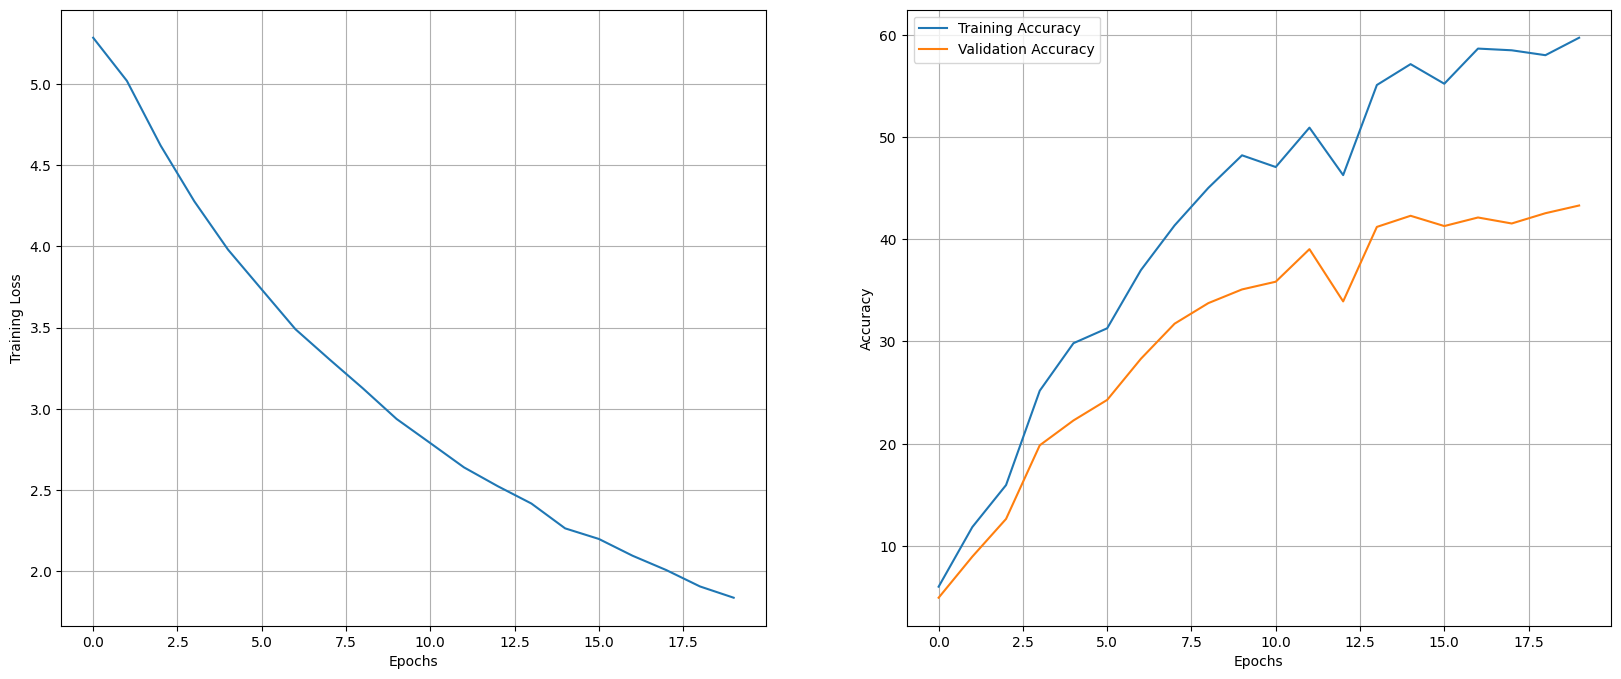

100%|██████████| 2400/2400 [00:25<00:00, 94.44it/s] 


Epoch [21/50], Loss: 1.9293


100%|██████████| 2400/2400 [00:20<00:00, 116.80it/s]


Accuracy of the network on the 2400 train images: 60.895833333333336


100%|██████████| 597/597 [00:06<00:00, 88.67it/s] 


Accuracy of the network on the 597 validation images: 42.88107202680067


100%|██████████| 2400/2400 [00:26<00:00, 89.28it/s] 


Epoch [22/50], Loss: 3.3003


100%|██████████| 2400/2400 [00:18<00:00, 128.46it/s]


Accuracy of the network on the 2400 train images: 63.583333333333336


100%|██████████| 597/597 [00:07<00:00, 81.34it/s] 


Accuracy of the network on the 597 validation images: 44.891122278056955


100%|██████████| 2400/2400 [00:27<00:00, 86.25it/s] 


Epoch [23/50], Loss: 0.3834


100%|██████████| 2400/2400 [00:21<00:00, 111.85it/s]


Accuracy of the network on the 2400 train images: 66.85416666666667


100%|██████████| 597/597 [00:07<00:00, 84.99it/s] 


Accuracy of the network on the 597 validation images: 48.57621440536013


100%|██████████| 2400/2400 [00:29<00:00, 82.12it/s] 


Epoch [24/50], Loss: 1.5969


100%|██████████| 2400/2400 [00:20<00:00, 118.65it/s]


Accuracy of the network on the 2400 train images: 64.52083333333333


100%|██████████| 597/597 [00:07<00:00, 84.96it/s] 


Accuracy of the network on the 597 validation images: 45.644891122278054


100%|██████████| 2400/2400 [00:27<00:00, 87.00it/s] 


Epoch [25/50], Loss: 2.0348


100%|██████████| 2400/2400 [00:21<00:00, 112.03it/s]


Accuracy of the network on the 2400 train images: 68.47916666666667


100%|██████████| 597/597 [00:07<00:00, 76.13it/s] 


Accuracy of the network on the 597 validation images: 48.24120603015076


100%|██████████| 2400/2400 [00:28<00:00, 82.97it/s] 


Epoch [26/50], Loss: 0.9100


100%|██████████| 2400/2400 [00:19<00:00, 124.79it/s]


Accuracy of the network on the 2400 train images: 69.97916666666667


100%|██████████| 597/597 [00:06<00:00, 86.94it/s] 


Accuracy of the network on the 597 validation images: 48.91122278056952


100%|██████████| 2400/2400 [00:27<00:00, 87.81it/s] 


Epoch [27/50], Loss: 1.7277


100%|██████████| 2400/2400 [00:21<00:00, 111.77it/s]


Accuracy of the network on the 2400 train images: 69.75


100%|██████████| 597/597 [00:06<00:00, 85.37it/s] 


Accuracy of the network on the 597 validation images: 47.73869346733668


100%|██████████| 2400/2400 [00:27<00:00, 85.91it/s] 


Epoch [28/50], Loss: 5.5918


100%|██████████| 2400/2400 [00:19<00:00, 122.32it/s]


Accuracy of the network on the 2400 train images: 66.89583333333333


100%|██████████| 597/597 [00:07<00:00, 84.01it/s] 


Accuracy of the network on the 597 validation images: 45.561139028475715


100%|██████████| 2400/2400 [00:26<00:00, 91.73it/s] 


Epoch [29/50], Loss: 2.3306


100%|██████████| 2400/2400 [00:20<00:00, 117.04it/s]


Accuracy of the network on the 2400 train images: 68.58333333333333


100%|██████████| 597/597 [00:06<00:00, 85.91it/s] 


Accuracy of the network on the 597 validation images: 46.14740368509213


100%|██████████| 2400/2400 [00:26<00:00, 92.04it/s] 


Epoch [30/50], Loss: 1.3000


100%|██████████| 2400/2400 [00:19<00:00, 120.74it/s]


Accuracy of the network on the 2400 train images: 71.85416666666667


100%|██████████| 597/597 [00:07<00:00, 84.94it/s] 

Accuracy of the network on the 597 validation images: 49.83249581239531


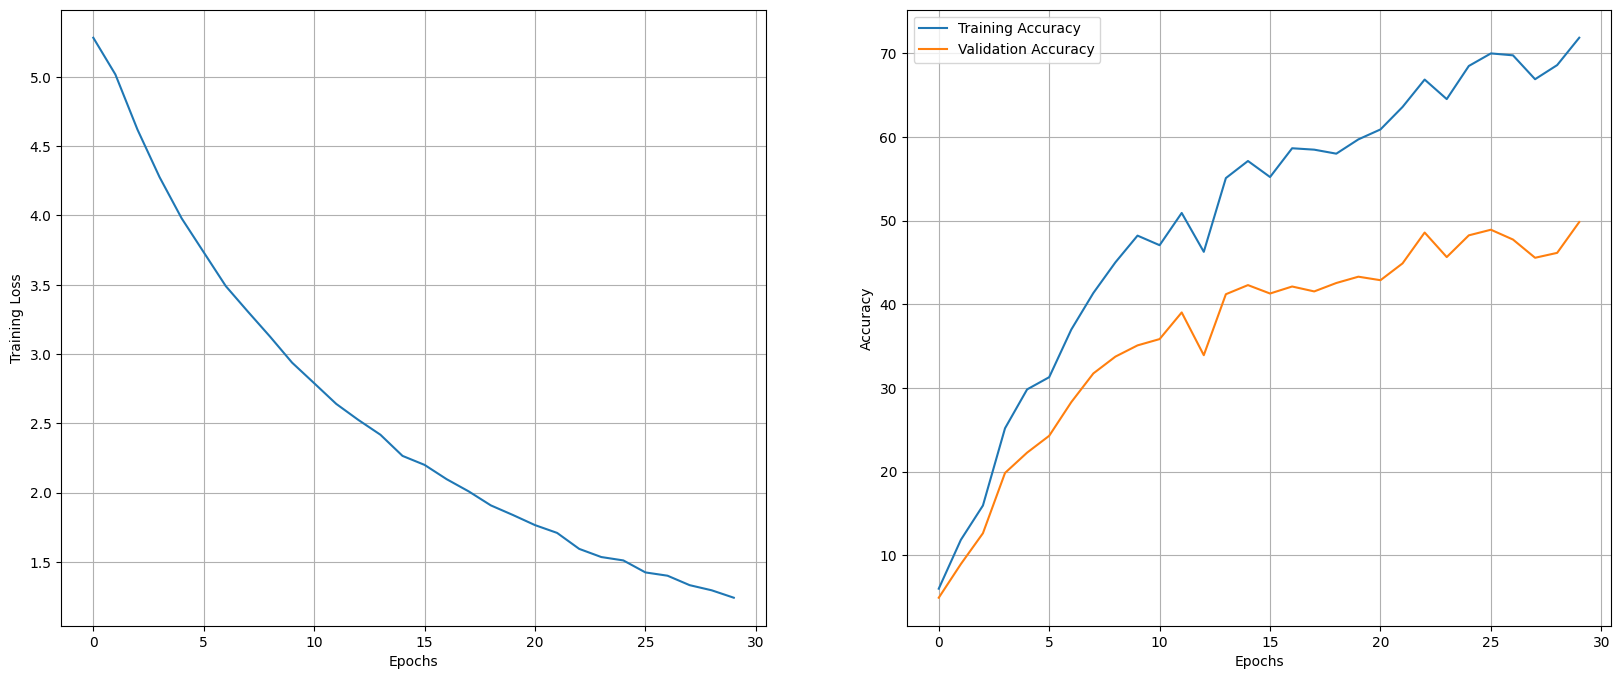

100%|██████████| 2400/2400 [00:26<00:00, 91.33it/s] 


Epoch [31/50], Loss: 0.1797


100%|██████████| 2400/2400 [00:20<00:00, 114.74it/s]


Accuracy of the network on the 2400 train images: 73.64583333333333


100%|██████████| 597/597 [00:06<00:00, 88.11it/s] 


Accuracy of the network on the 597 validation images: 48.743718592964825


100%|██████████| 2400/2400 [00:26<00:00, 90.39it/s] 


Epoch [32/50], Loss: 0.1926


100%|██████████| 2400/2400 [00:19<00:00, 122.61it/s]


Accuracy of the network on the 2400 train images: 70.27083333333333


100%|██████████| 597/597 [00:07<00:00, 84.52it/s] 


Accuracy of the network on the 597 validation images: 46.984924623115575


100%|██████████| 2400/2400 [00:25<00:00, 93.23it/s] 


Epoch [33/50], Loss: 0.5223


100%|██████████| 2400/2400 [00:21<00:00, 112.44it/s]


Accuracy of the network on the 2400 train images: 74.70833333333333


100%|██████████| 597/597 [00:07<00:00, 84.44it/s] 


Accuracy of the network on the 597 validation images: 48.743718592964825


100%|██████████| 2400/2400 [00:28<00:00, 83.59it/s]


Epoch [34/50], Loss: 0.7522


100%|██████████| 2400/2400 [00:20<00:00, 118.51it/s]


Accuracy of the network on the 2400 train images: 74.5


100%|██████████| 597/597 [00:07<00:00, 82.02it/s] 


Accuracy of the network on the 597 validation images: 50.0


100%|██████████| 2400/2400 [00:27<00:00, 86.80it/s] 


Epoch [35/50], Loss: 0.3999


100%|██████████| 2400/2400 [00:21<00:00, 111.16it/s]


Accuracy of the network on the 2400 train images: 72.375


100%|██████████| 597/597 [00:07<00:00, 84.78it/s] 


Accuracy of the network on the 597 validation images: 47.31993299832496


100%|██████████| 2400/2400 [00:27<00:00, 88.80it/s] 


Epoch [36/50], Loss: 2.2280


100%|██████████| 2400/2400 [00:20<00:00, 117.60it/s]


Accuracy of the network on the 2400 train images: 71.91666666666667


100%|██████████| 597/597 [00:07<00:00, 84.67it/s] 


Accuracy of the network on the 597 validation images: 50.67001675041876


100%|██████████| 2400/2400 [00:27<00:00, 88.41it/s] 


Epoch [37/50], Loss: 0.0755


100%|██████████| 2400/2400 [00:21<00:00, 114.02it/s]


Accuracy of the network on the 2400 train images: 75.47916666666667


100%|██████████| 597/597 [00:06<00:00, 87.36it/s] 


Accuracy of the network on the 597 validation images: 50.9212730318258


100%|██████████| 2400/2400 [00:28<00:00, 84.63it/s] 


Epoch [38/50], Loss: 1.6593


100%|██████████| 2400/2400 [00:20<00:00, 118.87it/s]


Accuracy of the network on the 2400 train images: 74.8125


100%|██████████| 597/597 [00:07<00:00, 82.93it/s] 


Accuracy of the network on the 597 validation images: 49.246231155778894


100%|██████████| 2400/2400 [00:25<00:00, 93.13it/s] 


Epoch [39/50], Loss: 0.5041


100%|██████████| 2400/2400 [00:20<00:00, 117.17it/s]


Accuracy of the network on the 2400 train images: 76.9375


100%|██████████| 597/597 [00:06<00:00, 87.90it/s] 


Accuracy of the network on the 597 validation images: 50.335008375209384


100%|██████████| 2400/2400 [00:26<00:00, 89.62it/s] 


Epoch [40/50], Loss: 1.9448


100%|██████████| 2400/2400 [00:19<00:00, 125.28it/s]


Accuracy of the network on the 2400 train images: 78.0


100%|██████████| 597/597 [00:06<00:00, 85.33it/s] 

Accuracy of the network on the 597 validation images: 51.42378559463987


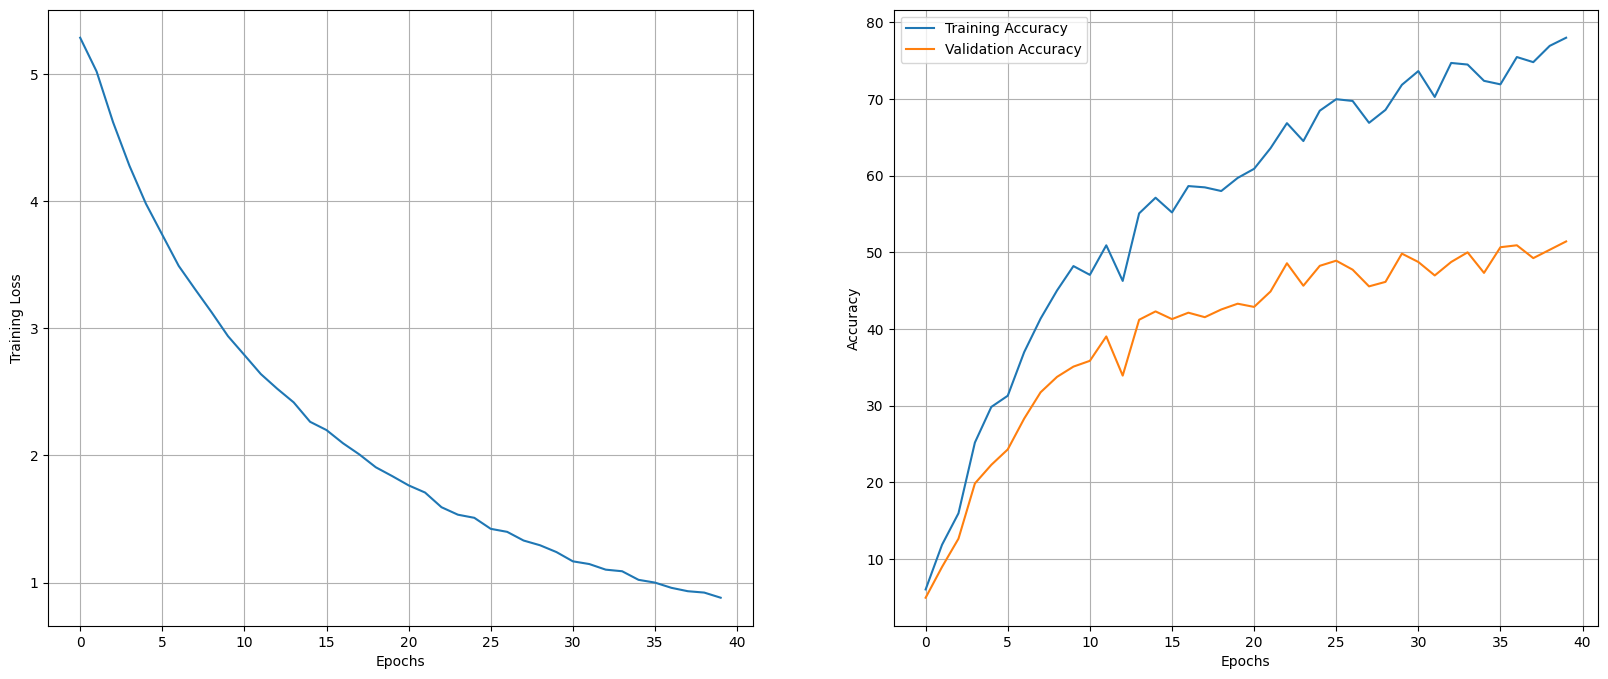

100%|██████████| 2400/2400 [00:25<00:00, 95.83it/s] 


Epoch [41/50], Loss: 0.4889


100%|██████████| 2400/2400 [00:20<00:00, 118.41it/s]


Accuracy of the network on the 2400 train images: 77.64583333333333


100%|██████████| 597/597 [00:06<00:00, 88.24it/s] 


Accuracy of the network on the 597 validation images: 50.41876046901172


100%|██████████| 2400/2400 [00:26<00:00, 90.72it/s] 


Epoch [42/50], Loss: 0.3407


100%|██████████| 2400/2400 [00:19<00:00, 123.17it/s]


Accuracy of the network on the 2400 train images: 75.89583333333333


100%|██████████| 597/597 [00:06<00:00, 85.61it/s] 


Accuracy of the network on the 597 validation images: 50.0


100%|██████████| 2400/2400 [00:25<00:00, 94.86it/s] 


Epoch [43/50], Loss: 0.1703


100%|██████████| 2400/2400 [00:19<00:00, 122.85it/s]


Accuracy of the network on the 2400 train images: 73.02083333333333


100%|██████████| 597/597 [00:06<00:00, 91.91it/s] 


Accuracy of the network on the 597 validation images: 47.31993299832496


100%|██████████| 2400/2400 [00:27<00:00, 88.69it/s] 


Epoch [44/50], Loss: 0.3794


100%|██████████| 2400/2400 [00:20<00:00, 119.42it/s]


Accuracy of the network on the 2400 train images: 74.5625


100%|██████████| 597/597 [00:07<00:00, 82.53it/s] 


Accuracy of the network on the 597 validation images: 48.40871021775544


100%|██████████| 2400/2400 [00:27<00:00, 87.52it/s] 


Epoch [45/50], Loss: 0.1401


100%|██████████| 2400/2400 [00:21<00:00, 112.33it/s]


Accuracy of the network on the 2400 train images: 75.85416666666667


100%|██████████| 597/597 [00:06<00:00, 89.46it/s] 


Accuracy of the network on the 597 validation images: 48.743718592964825


100%|██████████| 2400/2400 [00:28<00:00, 82.91it/s] 


Epoch [46/50], Loss: 1.2407


100%|██████████| 2400/2400 [00:19<00:00, 120.54it/s]


Accuracy of the network on the 2400 train images: 74.29166666666667


100%|██████████| 597/597 [00:07<00:00, 82.80it/s] 


Accuracy of the network on the 597 validation images: 47.73869346733668


100%|██████████| 2400/2400 [00:27<00:00, 88.11it/s] 


Epoch [47/50], Loss: 0.2009


100%|██████████| 2400/2400 [00:21<00:00, 112.45it/s]


Accuracy of the network on the 2400 train images: 78.27083333333333


100%|██████████| 597/597 [00:06<00:00, 87.84it/s] 


Accuracy of the network on the 597 validation images: 50.41876046901172


100%|██████████| 2400/2400 [00:29<00:00, 82.47it/s] 


Epoch [48/50], Loss: 0.0111


100%|██████████| 2400/2400 [00:19<00:00, 121.02it/s]


Accuracy of the network on the 2400 train images: 75.91666666666667


100%|██████████| 597/597 [00:07<00:00, 82.43it/s] 


Accuracy of the network on the 597 validation images: 50.0


100%|██████████| 2400/2400 [00:27<00:00, 88.02it/s] 


Epoch [49/50], Loss: 3.2046


100%|██████████| 2400/2400 [00:19<00:00, 123.11it/s]


Accuracy of the network on the 2400 train images: 75.10416666666667


100%|██████████| 597/597 [00:07<00:00, 84.11it/s] 


Accuracy of the network on the 597 validation images: 47.571189279731996


100%|██████████| 2400/2400 [00:25<00:00, 94.75it/s] 


Epoch [50/50], Loss: 0.0317


100%|██████████| 2400/2400 [00:20<00:00, 119.12it/s]


Accuracy of the network on the 2400 train images: 78.0


100%|██████████| 597/597 [00:06<00:00, 89.39it/s] 

Accuracy of the network on the 597 validation images: 51.84254606365159


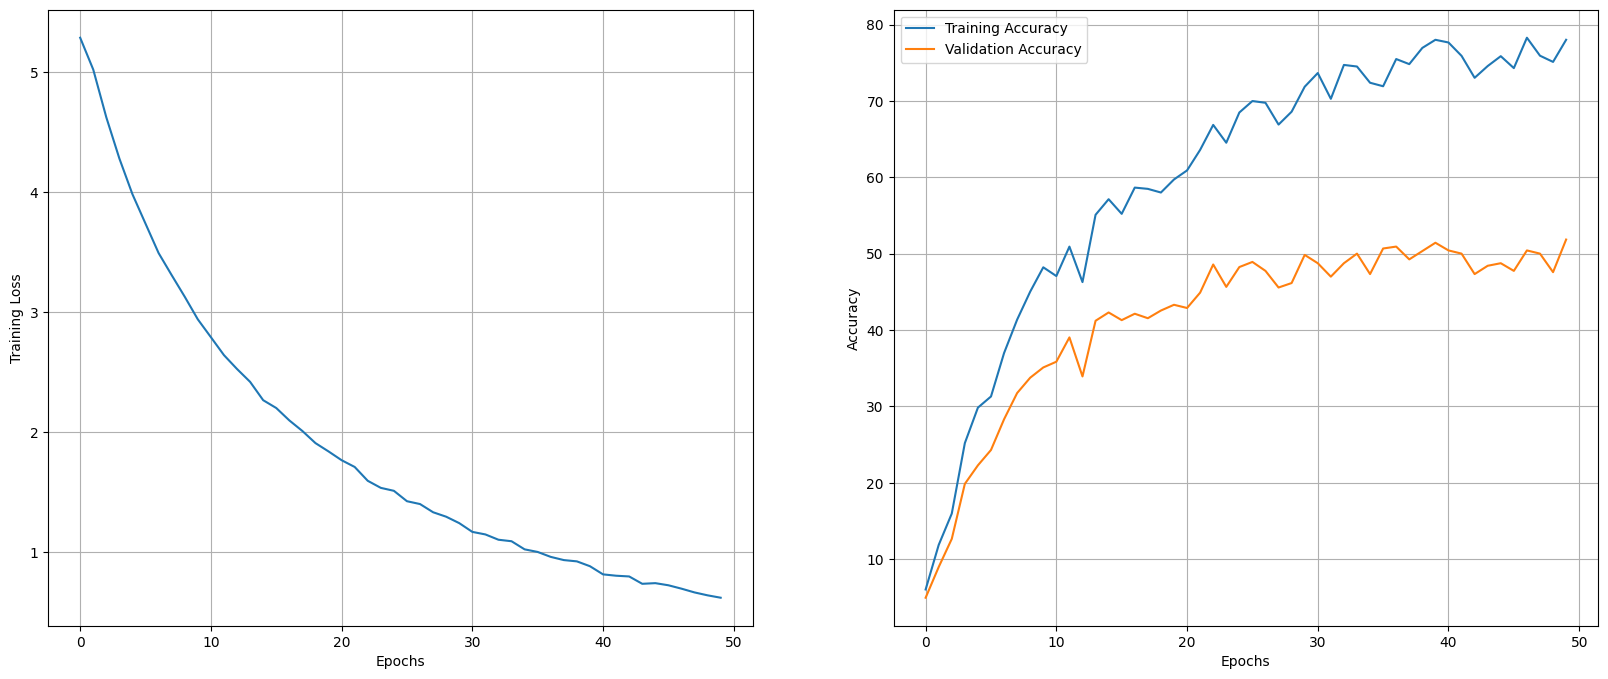

100%|██████████| 2897/2897 [00:23<00:00, 121.31it/s]

Accuracy of the network on the 2897 test images: 50.01725923369003


50.01725923369003

In [52]:
checkModel = copy.deepcopy(NewModel)
checkModel.to(device)

torch.cuda.empty_cache()
gc.collect()

training_accuracy = []
training_loss = []
validation_accuracy = []

# Number of epochs
num_epochs = 50

optimizer = optim.Adam(params=checkModel.parameters(), lr=1e-4, weight_decay=0)

for epoch in range(num_epochs):
    checkModel.train()

    running_loss = 0    
    for input_data, labels in tqdm.tqdm(TrainLoader, total=len(TrainLoader)):
        # Forward pass
        labels, input_data = labels.to(device), input_data.to(device)
        output = checkModel(input_data)
        
        # Compute loss
        loss = criterion(output, labels.long())
        running_loss += loss.item()
        # Backward pass
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights
    # scheduler.step(running_loss)  # Update learning rate
        
    # Print training progress
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    training_loss.append(running_loss / len(TrainLoader))

    training_accuracy.append(calculate_accuracy(checkModel, TrainLoader, data_type='train'))
    validation_accuracy.append(calculate_accuracy(checkModel, ValidationLoader, data_type='validation'))
    

    if (epoch + 1) % 10 == 0:
        fig, ax = plt.subplots(1, 2, figsize=(20, 8))
        ax[0].plot(range(len(training_loss)), training_loss)
        ax[1].plot(range(len(training_accuracy)), training_accuracy, label='Training Accuracy')
        ax[1].plot(range(len(validation_accuracy)), validation_accuracy, label='Validation Accuracy')
        ax[1].grid()
        ax[0].grid()
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Training Loss')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
        plt.show()
        torch.save(checkModel.state_dict(), f"checkModel_{epoch}.pth")
calculate_accuracy(checkModel, TestLoader, data_type='test')

100%|██████████| 2400/2400 [03:09<00:00, 12.68it/s]


Epoch [51/50], Loss: 0.2995


100%|██████████| 2400/2400 [00:51<00:00, 47.01it/s]


Accuracy of the network on the 2400 train images: 88.08333333333333


100%|██████████| 597/597 [00:21<00:00, 27.90it/s]


Accuracy of the network on the 597 validation images: 61.222780569514235


100%|██████████| 2400/2400 [03:02<00:00, 13.16it/s]


Epoch [52/50], Loss: 0.0754


100%|██████████| 2400/2400 [00:19<00:00, 125.49it/s]


Accuracy of the network on the 2400 train images: 90.39583333333333


100%|██████████| 597/597 [00:07<00:00, 83.94it/s] 


Accuracy of the network on the 597 validation images: 61.641541038525965


100%|██████████| 2400/2400 [01:12<00:00, 33.22it/s]


Epoch [53/50], Loss: 1.4087


100%|██████████| 2400/2400 [00:21<00:00, 109.72it/s]


Accuracy of the network on the 2400 train images: 93.41666666666667


100%|██████████| 597/597 [00:10<00:00, 58.29it/s] 


Accuracy of the network on the 597 validation images: 63.73534338358459


100%|██████████| 2400/2400 [01:17<00:00, 30.79it/s]


Epoch [54/50], Loss: 0.0601


100%|██████████| 2400/2400 [00:18<00:00, 126.44it/s]


Accuracy of the network on the 2400 train images: 92.52083333333333


100%|██████████| 597/597 [00:06<00:00, 85.51it/s] 


Accuracy of the network on the 597 validation images: 59.882747068676714


100%|██████████| 2400/2400 [01:11<00:00, 33.35it/s]


Epoch [55/50], Loss: 0.0196


100%|██████████| 2400/2400 [00:20<00:00, 118.87it/s]


Accuracy of the network on the 2400 train images: 95.58333333333333


100%|██████████| 597/597 [00:18<00:00, 32.09it/s] 


Accuracy of the network on the 597 validation images: 64.57286432160804


100%|██████████| 2400/2400 [01:13<00:00, 32.81it/s]


Epoch [56/50], Loss: 0.0301


100%|██████████| 2400/2400 [00:31<00:00, 75.99it/s] 


Accuracy of the network on the 2400 train images: 95.08333333333333


100%|██████████| 597/597 [00:07<00:00, 82.34it/s] 


Accuracy of the network on the 597 validation images: 62.814070351758794


100%|██████████| 2400/2400 [01:29<00:00, 26.67it/s]


Epoch [57/50], Loss: 0.0114


100%|██████████| 2400/2400 [00:35<00:00, 67.20it/s] 


Accuracy of the network on the 2400 train images: 95.47916666666667


100%|██████████| 597/597 [00:08<00:00, 67.48it/s] 


Accuracy of the network on the 597 validation images: 64.07035175879398


100%|██████████| 2400/2400 [01:15<00:00, 31.93it/s]


Epoch [58/50], Loss: 0.0007


100%|██████████| 2400/2400 [00:33<00:00, 72.26it/s] 


Accuracy of the network on the 2400 train images: 94.625


100%|██████████| 597/597 [00:29<00:00, 20.05it/s]


Accuracy of the network on the 597 validation images: 63.40033500837521


100%|██████████| 2400/2400 [01:34<00:00, 25.28it/s]


Epoch [59/50], Loss: 0.0599


100%|██████████| 2400/2400 [00:20<00:00, 118.12it/s]


Accuracy of the network on the 2400 train images: 95.375


100%|██████████| 597/597 [00:06<00:00, 86.67it/s] 


Accuracy of the network on the 597 validation images: 63.651591289782246


100%|██████████| 2400/2400 [01:10<00:00, 34.10it/s]


Epoch [60/50], Loss: 0.7157


100%|██████████| 2400/2400 [00:20<00:00, 115.36it/s]


Accuracy of the network on the 2400 train images: 96.35416666666667


100%|██████████| 597/597 [00:08<00:00, 73.09it/s] 


Accuracy of the network on the 597 validation images: 63.31658291457286


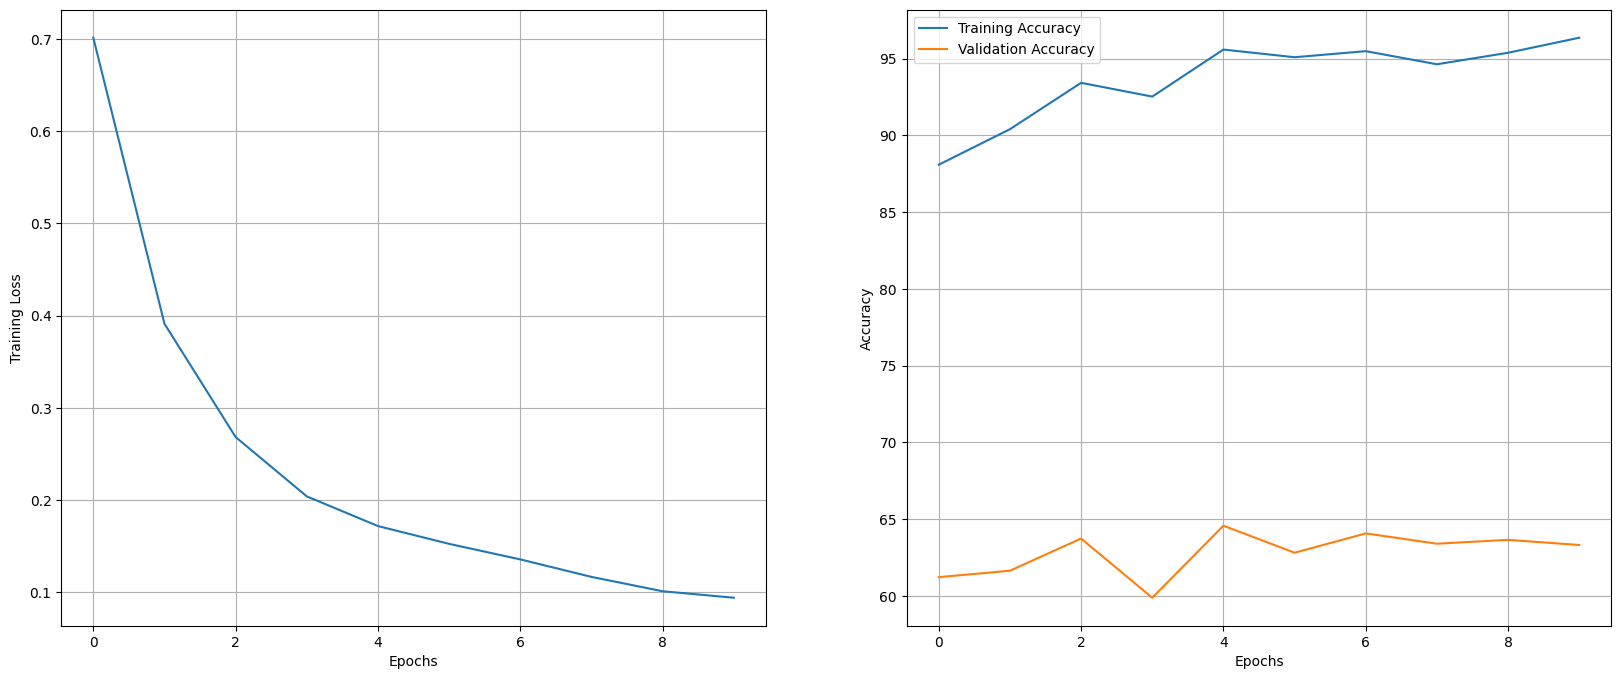

100%|██████████| 2400/2400 [02:22<00:00, 16.82it/s]


Epoch [61/50], Loss: 0.0001


100%|██████████| 2400/2400 [00:27<00:00, 88.81it/s] 


Accuracy of the network on the 2400 train images: 93.85416666666667


100%|██████████| 597/597 [00:18<00:00, 31.85it/s] 


Accuracy of the network on the 597 validation images: 60.63651591289782


100%|██████████| 2400/2400 [01:13<00:00, 32.71it/s]


Epoch [62/50], Loss: 0.2737


100%|██████████| 2400/2400 [00:22<00:00, 106.15it/s]


Accuracy of the network on the 2400 train images: 95.5625


100%|██████████| 597/597 [00:07<00:00, 77.67it/s] 


Accuracy of the network on the 597 validation images: 61.55778894472362


100%|██████████| 2400/2400 [01:09<00:00, 34.67it/s]


Epoch [63/50], Loss: 0.2261


100%|██████████| 2400/2400 [00:19<00:00, 124.77it/s]


Accuracy of the network on the 2400 train images: 94.3125


100%|██████████| 597/597 [00:06<00:00, 92.25it/s] 


Accuracy of the network on the 597 validation images: 59.12897822445561


100%|██████████| 2400/2400 [01:03<00:00, 37.82it/s]


Epoch [64/50], Loss: 0.0012


100%|██████████| 2400/2400 [00:25<00:00, 93.26it/s] 


Accuracy of the network on the 2400 train images: 95.22916666666667


100%|██████████| 597/597 [00:06<00:00, 87.97it/s] 


Accuracy of the network on the 597 validation images: 62.981574539363486


100%|██████████| 2400/2400 [01:08<00:00, 35.00it/s]


Epoch [65/50], Loss: 0.0007


100%|██████████| 2400/2400 [00:19<00:00, 123.71it/s]


Accuracy of the network on the 2400 train images: 95.29166666666667


100%|██████████| 597/597 [00:06<00:00, 85.90it/s] 


Accuracy of the network on the 597 validation images: 60.38525963149079


100%|██████████| 2400/2400 [01:04<00:00, 37.22it/s]


Epoch [66/50], Loss: 0.0092


100%|██████████| 2400/2400 [00:19<00:00, 124.49it/s]


Accuracy of the network on the 2400 train images: 94.95833333333333


100%|██████████| 597/597 [00:06<00:00, 89.24it/s] 


Accuracy of the network on the 597 validation images: 61.72529313232831


100%|██████████| 2400/2400 [01:04<00:00, 37.11it/s]


Epoch [67/50], Loss: 0.0007


100%|██████████| 2400/2400 [00:31<00:00, 75.51it/s] 


Accuracy of the network on the 2400 train images: 95.0625


100%|██████████| 597/597 [00:06<00:00, 89.19it/s] 


Accuracy of the network on the 597 validation images: 61.47403685092127


100%|██████████| 2400/2400 [01:05<00:00, 36.68it/s]


Epoch [68/50], Loss: 0.0235


100%|██████████| 2400/2400 [00:47<00:00, 50.92it/s] 


Accuracy of the network on the 2400 train images: 96.33333333333333


100%|██████████| 597/597 [00:17<00:00, 33.73it/s]


Accuracy of the network on the 597 validation images: 62.89782244556114


100%|██████████| 2400/2400 [01:16<00:00, 31.20it/s]


Epoch [69/50], Loss: 0.0065


100%|██████████| 2400/2400 [00:19<00:00, 123.99it/s]


Accuracy of the network on the 2400 train images: 96.77083333333333


100%|██████████| 597/597 [00:06<00:00, 89.05it/s] 


Accuracy of the network on the 597 validation images: 63.90284757118928


100%|██████████| 2400/2400 [01:17<00:00, 30.91it/s]


Epoch [70/50], Loss: 0.2222


100%|██████████| 2400/2400 [00:23<00:00, 100.42it/s]


Accuracy of the network on the 2400 train images: 94.89583333333333


100%|██████████| 597/597 [00:06<00:00, 86.08it/s] 


Accuracy of the network on the 597 validation images: 61.892797319932995


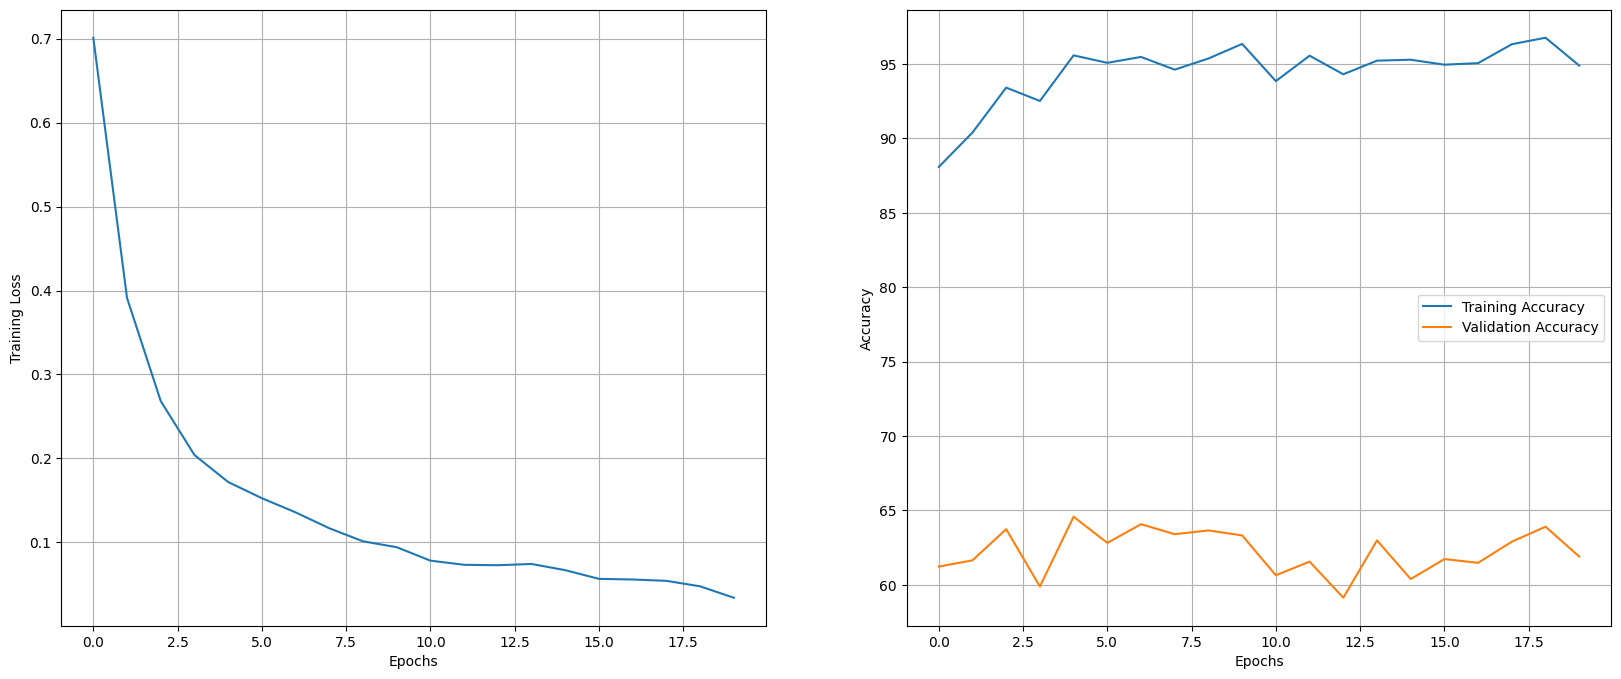

100%|██████████| 2400/2400 [01:05<00:00, 36.69it/s]


Epoch [71/50], Loss: 0.0001


100%|██████████| 2400/2400 [00:19<00:00, 123.65it/s]


Accuracy of the network on the 2400 train images: 96.4375


100%|██████████| 597/597 [00:06<00:00, 88.65it/s] 


Accuracy of the network on the 597 validation images: 61.80904522613066


100%|██████████| 2400/2400 [01:04<00:00, 36.93it/s]


Epoch [72/50], Loss: 0.0167


100%|██████████| 2400/2400 [00:19<00:00, 122.90it/s]


Accuracy of the network on the 2400 train images: 96.52083333333333


100%|██████████| 597/597 [00:06<00:00, 86.19it/s] 


Accuracy of the network on the 597 validation images: 63.90284757118928


100%|██████████| 2400/2400 [01:04<00:00, 37.17it/s]


Epoch [73/50], Loss: 0.0020


100%|██████████| 2400/2400 [00:19<00:00, 124.46it/s]


Accuracy of the network on the 2400 train images: 94.875


100%|██████████| 597/597 [00:11<00:00, 50.29it/s] 


Accuracy of the network on the 597 validation images: 60.469011725293136


100%|██████████| 2400/2400 [01:13<00:00, 32.47it/s]


Epoch [74/50], Loss: 0.0390


100%|██████████| 2400/2400 [00:30<00:00, 79.45it/s] 


Accuracy of the network on the 2400 train images: 95.60416666666667


100%|██████████| 597/597 [00:07<00:00, 82.99it/s] 


Accuracy of the network on the 597 validation images: 62.562814070351756


100%|██████████| 2400/2400 [01:35<00:00, 25.22it/s]


Epoch [75/50], Loss: 0.0076


100%|██████████| 2400/2400 [00:22<00:00, 105.77it/s]


Accuracy of the network on the 2400 train images: 97.04166666666667


100%|██████████| 597/597 [00:06<00:00, 86.23it/s] 


Accuracy of the network on the 597 validation images: 65.2428810720268


100%|██████████| 2400/2400 [01:08<00:00, 34.82it/s]


Epoch [76/50], Loss: 0.0050


100%|██████████| 2400/2400 [00:28<00:00, 85.07it/s] 


Accuracy of the network on the 2400 train images: 96.20833333333333


100%|██████████| 597/597 [00:07<00:00, 76.80it/s] 


Accuracy of the network on the 597 validation images: 61.222780569514235


100%|██████████| 2400/2400 [01:04<00:00, 36.96it/s]


Epoch [77/50], Loss: 0.0180


100%|██████████| 2400/2400 [00:19<00:00, 124.29it/s]


Accuracy of the network on the 2400 train images: 95.41666666666667


100%|██████████| 597/597 [00:11<00:00, 53.35it/s] 


Accuracy of the network on the 597 validation images: 62.981574539363486


100%|██████████| 2400/2400 [01:14<00:00, 32.08it/s]


Epoch [78/50], Loss: 0.0001


100%|██████████| 2400/2400 [00:22<00:00, 107.47it/s]


Accuracy of the network on the 2400 train images: 96.66666666666667


100%|██████████| 597/597 [00:06<00:00, 90.48it/s] 


Accuracy of the network on the 597 validation images: 63.651591289782246


100%|██████████| 2400/2400 [01:44<00:00, 22.92it/s]


Epoch [79/50], Loss: 0.0125


100%|██████████| 2400/2400 [00:39<00:00, 60.16it/s] 


Accuracy of the network on the 2400 train images: 94.79166666666667


100%|██████████| 597/597 [00:09<00:00, 64.17it/s] 


Accuracy of the network on the 597 validation images: 59.63149078726968


100%|██████████| 2400/2400 [02:14<00:00, 17.89it/s]


Epoch [80/50], Loss: 0.0038


100%|██████████| 2400/2400 [00:27<00:00, 85.88it/s] 


Accuracy of the network on the 2400 train images: 97.02083333333333


100%|██████████| 597/597 [00:19<00:00, 30.20it/s] 


Accuracy of the network on the 597 validation images: 63.14907872696818


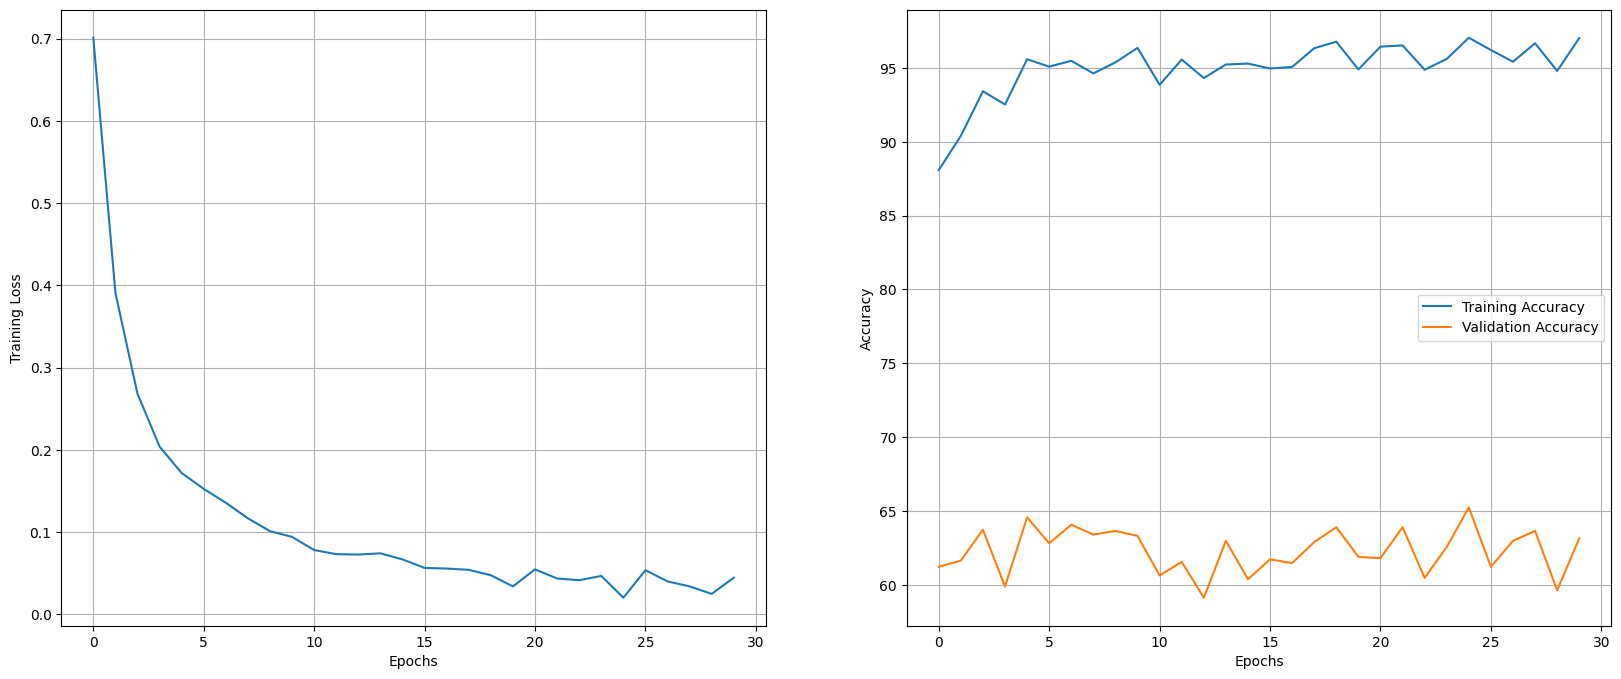

100%|██████████| 2400/2400 [01:56<00:00, 20.64it/s]


Epoch [81/50], Loss: 0.0369


100%|██████████| 2400/2400 [00:44<00:00, 54.53it/s] 


Accuracy of the network on the 2400 train images: 96.14583333333333


100%|██████████| 597/597 [00:15<00:00, 37.68it/s] 


Accuracy of the network on the 597 validation images: 62.14405360134003


100%|██████████| 2400/2400 [02:04<00:00, 19.22it/s]


Epoch [82/50], Loss: 0.0074


100%|██████████| 2400/2400 [00:37<00:00, 64.85it/s] 


Accuracy of the network on the 2400 train images: 93.75


100%|██████████| 597/597 [00:16<00:00, 36.27it/s]


Accuracy of the network on the 597 validation images: 59.380234505862646


100%|██████████| 2400/2400 [02:01<00:00, 19.81it/s]


Epoch [83/50], Loss: 0.0143


100%|██████████| 2400/2400 [00:28<00:00, 82.81it/s] 


Accuracy of the network on the 2400 train images: 92.95833333333333


100%|██████████| 597/597 [00:06<00:00, 89.42it/s] 


Accuracy of the network on the 597 validation images: 60.301507537688444


100%|██████████| 2400/2400 [01:37<00:00, 24.68it/s]


Epoch [84/50], Loss: 0.1393


100%|██████████| 2400/2400 [00:28<00:00, 84.94it/s] 


Accuracy of the network on the 2400 train images: 95.54166666666667


100%|██████████| 597/597 [00:20<00:00, 28.76it/s] 


Accuracy of the network on the 597 validation images: 61.80904522613066


100%|██████████| 2400/2400 [01:39<00:00, 24.09it/s]


Epoch [85/50], Loss: 0.0161


100%|██████████| 2400/2400 [00:25<00:00, 94.50it/s] 


Accuracy of the network on the 2400 train images: 96.89583333333333


100%|██████████| 597/597 [00:06<00:00, 86.22it/s] 


Accuracy of the network on the 597 validation images: 64.40536013400335


100%|██████████| 2400/2400 [01:10<00:00, 33.87it/s]


Epoch [86/50], Loss: 0.0000


100%|██████████| 2400/2400 [00:24<00:00, 96.99it/s] 


Accuracy of the network on the 2400 train images: 94.83333333333333


100%|██████████| 597/597 [00:13<00:00, 44.75it/s] 


Accuracy of the network on the 597 validation images: 59.46398659966499


100%|██████████| 2400/2400 [01:28<00:00, 27.19it/s]


Epoch [87/50], Loss: 0.0001


100%|██████████| 2400/2400 [00:26<00:00, 91.49it/s] 


Accuracy of the network on the 2400 train images: 97.25


100%|██████████| 597/597 [00:07<00:00, 82.06it/s] 


Accuracy of the network on the 597 validation images: 64.65661641541038


100%|██████████| 2400/2400 [01:50<00:00, 21.67it/s]


Epoch [88/50], Loss: 0.0000


100%|██████████| 2400/2400 [00:27<00:00, 87.41it/s] 


Accuracy of the network on the 2400 train images: 95.66666666666667


100%|██████████| 597/597 [00:07<00:00, 83.39it/s] 


Accuracy of the network on the 597 validation images: 59.54773869346734


100%|██████████| 2400/2400 [01:12<00:00, 33.25it/s]


Epoch [89/50], Loss: 0.0024


100%|██████████| 2400/2400 [00:19<00:00, 123.52it/s]


Accuracy of the network on the 2400 train images: 95.85416666666667


100%|██████████| 597/597 [00:08<00:00, 72.21it/s] 


Accuracy of the network on the 597 validation images: 60.63651591289782


100%|██████████| 2400/2400 [01:26<00:00, 27.65it/s]


Epoch [90/50], Loss: 0.0044


100%|██████████| 2400/2400 [00:19<00:00, 123.32it/s]


Accuracy of the network on the 2400 train images: 96.97916666666667


100%|██████████| 597/597 [00:06<00:00, 85.91it/s] 


Accuracy of the network on the 597 validation images: 62.6465661641541


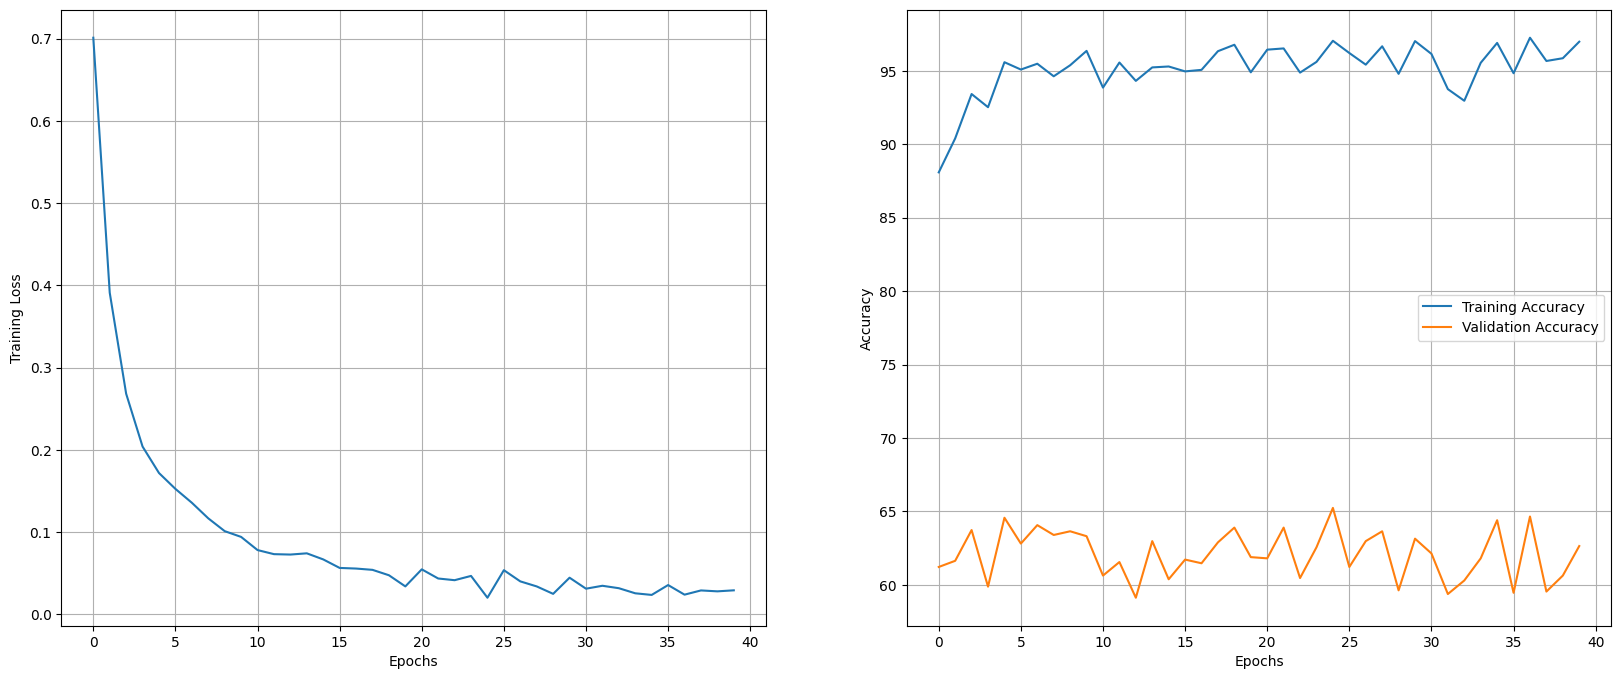

100%|██████████| 2400/2400 [01:04<00:00, 36.95it/s]


Epoch [91/50], Loss: 0.0000


100%|██████████| 2400/2400 [00:19<00:00, 122.48it/s]


Accuracy of the network on the 2400 train images: 96.4375


100%|██████████| 597/597 [00:06<00:00, 87.24it/s] 


Accuracy of the network on the 597 validation images: 60.469011725293136


100%|██████████| 2400/2400 [01:05<00:00, 36.63it/s]


Epoch [92/50], Loss: 0.0002


100%|██████████| 2400/2400 [00:20<00:00, 119.89it/s]


Accuracy of the network on the 2400 train images: 97.04166666666667


100%|██████████| 597/597 [00:06<00:00, 89.25it/s] 


Accuracy of the network on the 597 validation images: 63.81909547738694


100%|██████████| 2400/2400 [01:40<00:00, 23.80it/s]


Epoch [93/50], Loss: 0.0589


100%|██████████| 2400/2400 [00:24<00:00, 98.39it/s] 


Accuracy of the network on the 2400 train images: 95.39583333333333


100%|██████████| 597/597 [00:08<00:00, 72.49it/s] 


Accuracy of the network on the 597 validation images: 58.79396984924623


100%|██████████| 2400/2400 [01:35<00:00, 25.02it/s]


Epoch [94/50], Loss: 0.0002


100%|██████████| 2400/2400 [00:39<00:00, 60.12it/s] 


Accuracy of the network on the 2400 train images: 95.66666666666667


100%|██████████| 597/597 [00:08<00:00, 73.50it/s] 


Accuracy of the network on the 597 validation images: 60.72026800670017


100%|██████████| 2400/2400 [01:31<00:00, 26.33it/s]


Epoch [95/50], Loss: 0.0024


100%|██████████| 2400/2400 [00:20<00:00, 119.26it/s]


Accuracy of the network on the 2400 train images: 97.02083333333333


100%|██████████| 597/597 [00:07<00:00, 80.52it/s] 


Accuracy of the network on the 597 validation images: 65.2428810720268


100%|██████████| 2400/2400 [01:05<00:00, 36.37it/s]


Epoch [96/50], Loss: 0.0000


100%|██████████| 2400/2400 [00:20<00:00, 119.94it/s]


Accuracy of the network on the 2400 train images: 97.20833333333333


100%|██████████| 597/597 [00:07<00:00, 77.46it/s] 


Accuracy of the network on the 597 validation images: 64.40536013400335


100%|██████████| 2400/2400 [01:03<00:00, 37.55it/s]


Epoch [97/50], Loss: 0.0006


100%|██████████| 2400/2400 [00:18<00:00, 126.94it/s]


Accuracy of the network on the 2400 train images: 96.4375


100%|██████████| 597/597 [00:06<00:00, 90.10it/s] 


Accuracy of the network on the 597 validation images: 60.2177554438861


100%|██████████| 2400/2400 [01:03<00:00, 37.72it/s]


Epoch [98/50], Loss: 0.2830


100%|██████████| 2400/2400 [00:20<00:00, 117.64it/s]


Accuracy of the network on the 2400 train images: 96.9375


100%|██████████| 597/597 [00:06<00:00, 91.29it/s] 


Accuracy of the network on the 597 validation images: 62.981574539363486


100%|██████████| 2400/2400 [01:03<00:00, 37.72it/s]


Epoch [99/50], Loss: 0.0137


100%|██████████| 2400/2400 [00:20<00:00, 116.89it/s]


Accuracy of the network on the 2400 train images: 96.97916666666667


100%|██████████| 597/597 [00:07<00:00, 75.57it/s] 


Accuracy of the network on the 597 validation images: 63.90284757118928


100%|██████████| 2400/2400 [01:08<00:00, 34.86it/s]


Epoch [100/50], Loss: 0.0000


100%|██████████| 2400/2400 [00:18<00:00, 127.03it/s]


Accuracy of the network on the 2400 train images: 95.6875


100%|██████████| 597/597 [00:06<00:00, 88.01it/s] 


Accuracy of the network on the 597 validation images: 60.72026800670017


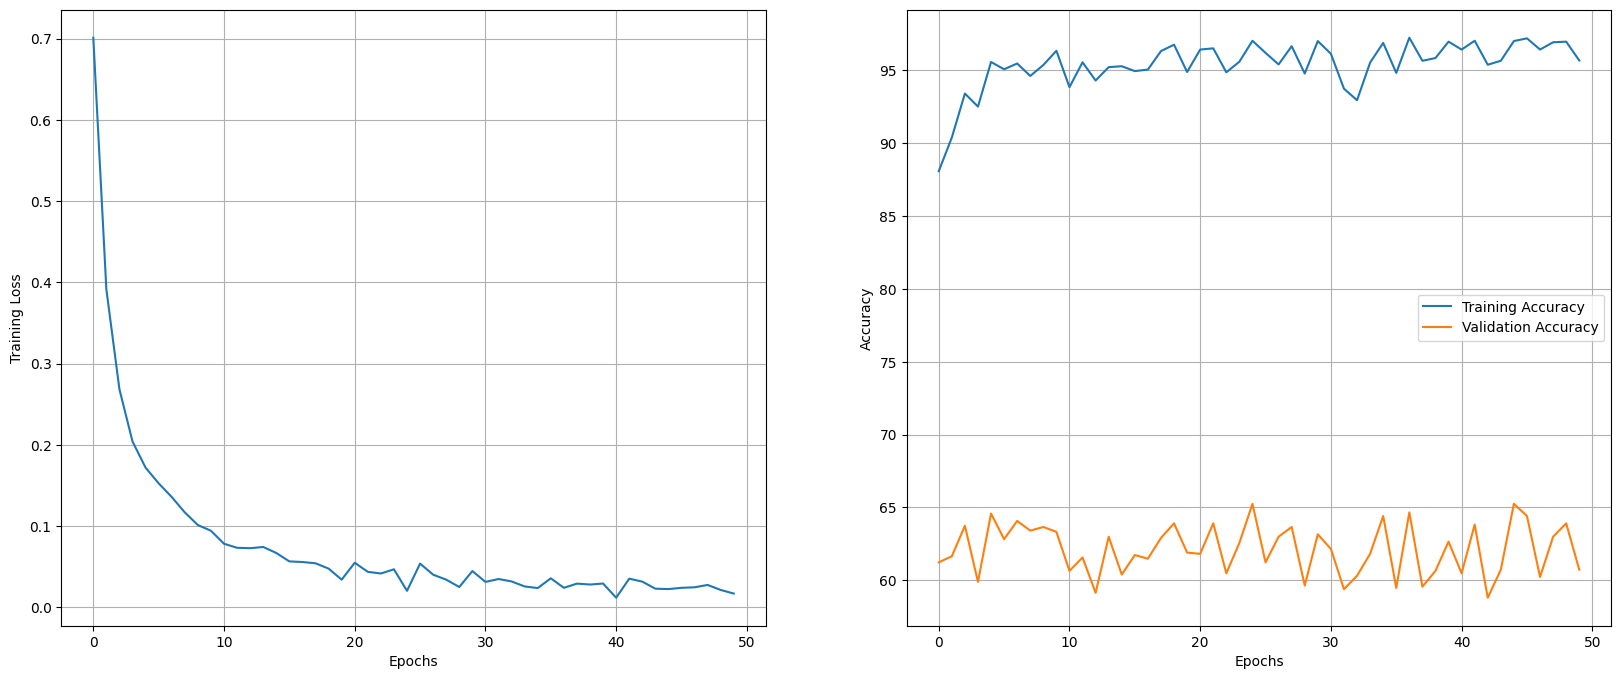

100%|██████████| 2897/2897 [00:37<00:00, 76.87it/s] 

Accuracy of the network on the 2897 test images: 61.132205730065586


61.132205730065586

In [23]:
checkVariables = torch.load('checkModel_49.pth')
checkModel = models.resnet50()
checkModel.fc = nn.Sequential(
    nn.Linear(checkModel.fc.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, 200),
)
checkModel.load_state_dict(checkVariables)
criterion = nn.CrossEntropyLoss()
 
checkModel.to(device)

torch.cuda.empty_cache()
gc.collect()

training_accuracy = []
training_loss = []
validation_accuracy = []

# Number of epochs
num_epochs = 50
base=50
optimizer = optim.Adam(params=checkModel.parameters(), lr=1e-4, weight_decay=0)

for epoch in range(base, num_epochs+base):
    checkModel.train()

    running_loss = 0    
    for input_data, labels in tqdm.tqdm(TrainLoader, total=len(TrainLoader)):
        # Forward pass
        labels, input_data = labels.to(device), input_data.to(device)
        output = checkModel(input_data)
        
        # Compute loss
        loss = criterion(output, labels.long())
        running_loss += loss.item()
        # Backward pass
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights
    # scheduler.step(running_loss)  # Update learning rate
        
    # Print training progress
    print(f'Epoch [{epoch + 1}/{num_epochs + base}], Loss: {loss.item():.4f}')
    training_loss.append(running_loss / len(TrainLoader))

    training_accuracy.append(calculate_accuracy(checkModel, TrainLoader, data_type='train'))
    validation_accuracy.append(calculate_accuracy(checkModel, ValidationLoader, data_type='validation'))
    

    if (epoch + 1) % 10 == 0:
        fig, ax = plt.subplots(1, 2, figsize=(20, 8))
        ax[0].plot(range(len(training_loss)), training_loss)
        ax[1].plot(range(len(training_accuracy)), training_accuracy, label='Training Accuracy')
        ax[1].plot(range(len(validation_accuracy)), validation_accuracy, label='Validation Accuracy')
        ax[1].grid()
        ax[0].grid()
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Training Loss')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Accuracy')
        ax[1].legend()
        plt.show()
        torch.save(checkModel.state_dict(), f"checkModel_{epoch + base}.pth")
calculate_accuracy(checkModel, TestLoader, data_type='test')